# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

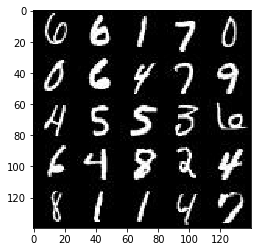

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

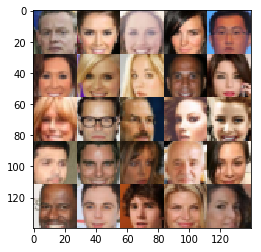

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return real, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start\n    handler_func(fd_obj, events)', 'File "/opt/conda/lib/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [32]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha * x, x)
    
    kernel = 4
    drop_rate = 0.4
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        conv1 = tf.layers.conv2d(images, 64, kernel, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = leaky_relu(conv1) #14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.layers.dropout(conv2, rate=drop_rate)
        conv2 = leaky_relu(conv2) #7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.layers.dropout(conv3, rate=drop_rate)
        conv3 = leaky_relu(conv3) #4x4x256

        flat = tf.reshape(conv3, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    def leaky_relu(x, alpha=0.2):
        return tf.maximum(alpha * x, x)
    
    kernel = 4
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 2*2*1024, use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.reshape(x, [-1, 2, 2, 1024])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x) #2*2*1024
        
        conv1 = tf.layers.conv2d_transpose(x, 512, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = leaky_relu(conv1) #4*4*512

        #output_size = (input_size - 1) * strides + kernel (because padding = valid)
        conv2 = tf.layers.conv2d_transpose(conv1, 256, kernel, strides=1, padding='valid', use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = leaky_relu(conv2) #7*7*256
        
        conv3 = tf.layers.conv2d_transpose(conv2, 128, kernel, strides=2, padding='same', use_bias=False, kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = leaky_relu(conv3) #14*14*128

        conv4 = tf.layers.conv2d_transpose(conv3, out_channel_dim, kernel, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(conv4) #28*28*out_channel_dim
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9)) #smooth
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, example_z=None):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    
    if example_z is None:
        print("Generating new sample noise")
        example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    print_every = 10
    show_every = 100
    
    #sample for training to observe the evolution of the same random noise
    example_z = np.random.uniform(-1, 1, size=[16, z_dim])
    
    _, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch in get_batches(batch_size):
                steps += 1
                
                batch_images = batch * 2 #scale images to -1, 1 range (from -0.5 to 0.5) to match generator tanh output
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images}) #why?

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})

                    print("Epoch {}/{}...Batch {}".format(epoch_i + 1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode, example_z=example_z)
                
        show_generator_output(sess, 25, input_z, channels, data_image_mode)
        saver.save(sess, './checkpoints/generator.ckpt')
        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2...Batch 10 Discriminator Loss: 1.1013... Generator Loss: 0.9544
Epoch 1/2...Batch 20 Discriminator Loss: 6.9053... Generator Loss: 0.0017
Epoch 1/2...Batch 30 Discriminator Loss: 3.1477... Generator Loss: 0.0973
Epoch 1/2...Batch 40 Discriminator Loss: 1.4517... Generator Loss: 1.9598
Epoch 1/2...Batch 50 Discriminator Loss: 0.9294... Generator Loss: 2.3403
Epoch 1/2...Batch 60 Discriminator Loss: 1.3386... Generator Loss: 4.1669
Epoch 1/2...Batch 70 Discriminator Loss: 0.6621... Generator Loss: 1.7936
Epoch 1/2...Batch 80 Discriminator Loss: 1.3096... Generator Loss: 0.6129
Epoch 1/2...Batch 90 Discriminator Loss: 1.9587... Generator Loss: 0.6375
Epoch 1/2...Batch 100 Discriminator Loss: 1.0588... Generator Loss: 1.3035


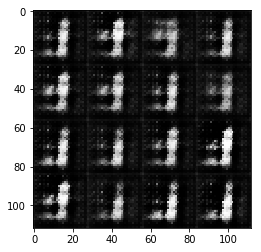

Epoch 1/2...Batch 110 Discriminator Loss: 0.8079... Generator Loss: 4.4409
Epoch 1/2...Batch 120 Discriminator Loss: 0.8393... Generator Loss: 2.2854
Epoch 1/2...Batch 130 Discriminator Loss: 1.1864... Generator Loss: 1.6694
Epoch 1/2...Batch 140 Discriminator Loss: 1.4119... Generator Loss: 0.6279
Epoch 1/2...Batch 150 Discriminator Loss: 0.9560... Generator Loss: 0.9953
Epoch 1/2...Batch 160 Discriminator Loss: 1.0040... Generator Loss: 1.1090
Epoch 1/2...Batch 170 Discriminator Loss: 1.2322... Generator Loss: 1.0319
Epoch 1/2...Batch 180 Discriminator Loss: 0.6811... Generator Loss: 2.1101
Epoch 1/2...Batch 190 Discriminator Loss: 0.9984... Generator Loss: 1.7091
Epoch 1/2...Batch 200 Discriminator Loss: 0.8450... Generator Loss: 1.0607


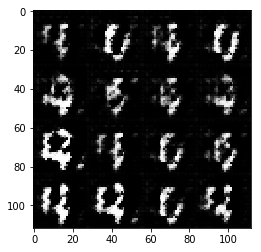

Epoch 1/2...Batch 210 Discriminator Loss: 1.0505... Generator Loss: 3.8081
Epoch 1/2...Batch 220 Discriminator Loss: 1.1513... Generator Loss: 1.7739
Epoch 1/2...Batch 230 Discriminator Loss: 1.5378... Generator Loss: 3.5392
Epoch 1/2...Batch 240 Discriminator Loss: 1.2514... Generator Loss: 0.8092
Epoch 1/2...Batch 250 Discriminator Loss: 1.7301... Generator Loss: 0.4039
Epoch 1/2...Batch 260 Discriminator Loss: 1.2408... Generator Loss: 0.7096
Epoch 1/2...Batch 270 Discriminator Loss: 1.3668... Generator Loss: 1.2012
Epoch 1/2...Batch 280 Discriminator Loss: 0.9888... Generator Loss: 1.6993
Epoch 1/2...Batch 290 Discriminator Loss: 1.0252... Generator Loss: 2.2736
Epoch 1/2...Batch 300 Discriminator Loss: 1.1819... Generator Loss: 2.6205


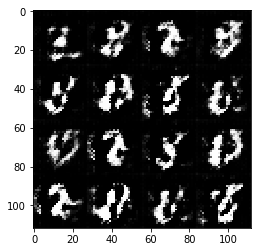

Epoch 1/2...Batch 310 Discriminator Loss: 1.0035... Generator Loss: 0.8847
Epoch 1/2...Batch 320 Discriminator Loss: 1.0205... Generator Loss: 0.9843
Epoch 1/2...Batch 330 Discriminator Loss: 1.8228... Generator Loss: 0.3165
Epoch 1/2...Batch 340 Discriminator Loss: 1.2903... Generator Loss: 0.6030
Epoch 1/2...Batch 350 Discriminator Loss: 1.1833... Generator Loss: 0.8682
Epoch 1/2...Batch 360 Discriminator Loss: 1.2591... Generator Loss: 1.1328
Epoch 1/2...Batch 370 Discriminator Loss: 1.0551... Generator Loss: 0.8802
Epoch 1/2...Batch 380 Discriminator Loss: 1.3198... Generator Loss: 2.1489
Epoch 1/2...Batch 390 Discriminator Loss: 1.1414... Generator Loss: 1.7372
Epoch 1/2...Batch 400 Discriminator Loss: 1.3223... Generator Loss: 2.2930


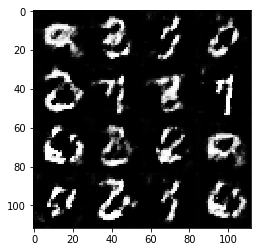

Epoch 1/2...Batch 410 Discriminator Loss: 1.0320... Generator Loss: 1.9349
Epoch 1/2...Batch 420 Discriminator Loss: 1.4854... Generator Loss: 3.0470
Epoch 1/2...Batch 430 Discriminator Loss: 1.2682... Generator Loss: 0.6129
Epoch 1/2...Batch 440 Discriminator Loss: 1.2398... Generator Loss: 0.9365
Epoch 1/2...Batch 450 Discriminator Loss: 1.6108... Generator Loss: 0.4329
Epoch 1/2...Batch 460 Discriminator Loss: 1.0867... Generator Loss: 1.2279
Epoch 1/2...Batch 470 Discriminator Loss: 1.1857... Generator Loss: 1.5807
Epoch 1/2...Batch 480 Discriminator Loss: 1.0434... Generator Loss: 1.2870
Epoch 1/2...Batch 490 Discriminator Loss: 1.0520... Generator Loss: 1.0697
Epoch 1/2...Batch 500 Discriminator Loss: 1.1379... Generator Loss: 0.7664


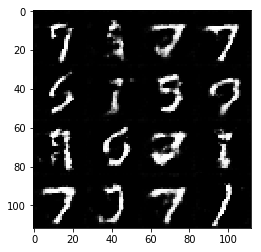

Epoch 1/2...Batch 510 Discriminator Loss: 1.6205... Generator Loss: 0.4025
Epoch 1/2...Batch 520 Discriminator Loss: 1.1766... Generator Loss: 0.9187
Epoch 1/2...Batch 530 Discriminator Loss: 1.5423... Generator Loss: 0.4135
Epoch 1/2...Batch 540 Discriminator Loss: 1.6449... Generator Loss: 0.3528
Epoch 1/2...Batch 550 Discriminator Loss: 1.0288... Generator Loss: 1.3307
Epoch 1/2...Batch 560 Discriminator Loss: 1.2561... Generator Loss: 0.7190
Epoch 1/2...Batch 570 Discriminator Loss: 1.5216... Generator Loss: 0.4743
Epoch 1/2...Batch 580 Discriminator Loss: 1.2640... Generator Loss: 1.6740
Epoch 1/2...Batch 590 Discriminator Loss: 1.3248... Generator Loss: 0.6352
Epoch 1/2...Batch 600 Discriminator Loss: 1.3703... Generator Loss: 0.5741


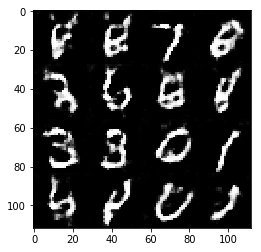

Epoch 1/2...Batch 610 Discriminator Loss: 1.1418... Generator Loss: 0.7589
Epoch 1/2...Batch 620 Discriminator Loss: 1.5652... Generator Loss: 0.4113
Epoch 1/2...Batch 630 Discriminator Loss: 1.1713... Generator Loss: 0.7943
Epoch 1/2...Batch 640 Discriminator Loss: 1.2310... Generator Loss: 0.8938
Epoch 1/2...Batch 650 Discriminator Loss: 1.7214... Generator Loss: 0.4315
Epoch 1/2...Batch 660 Discriminator Loss: 1.1113... Generator Loss: 1.4550
Epoch 1/2...Batch 670 Discriminator Loss: 1.1902... Generator Loss: 0.9774
Epoch 1/2...Batch 680 Discriminator Loss: 1.2307... Generator Loss: 1.7874
Epoch 1/2...Batch 690 Discriminator Loss: 1.6572... Generator Loss: 2.2816
Epoch 1/2...Batch 700 Discriminator Loss: 1.1271... Generator Loss: 1.0348


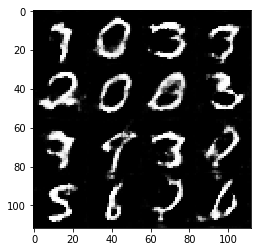

Epoch 1/2...Batch 710 Discriminator Loss: 1.1745... Generator Loss: 1.8895
Epoch 1/2...Batch 720 Discriminator Loss: 1.3266... Generator Loss: 0.5651
Epoch 1/2...Batch 730 Discriminator Loss: 1.2863... Generator Loss: 0.5477
Epoch 1/2...Batch 740 Discriminator Loss: 1.4629... Generator Loss: 0.4917
Epoch 1/2...Batch 750 Discriminator Loss: 1.1533... Generator Loss: 0.7503
Epoch 1/2...Batch 760 Discriminator Loss: 1.0797... Generator Loss: 1.0469
Epoch 1/2...Batch 770 Discriminator Loss: 1.1592... Generator Loss: 0.8302
Epoch 1/2...Batch 780 Discriminator Loss: 1.0635... Generator Loss: 1.5422
Epoch 1/2...Batch 790 Discriminator Loss: 1.4124... Generator Loss: 0.4462
Epoch 1/2...Batch 800 Discriminator Loss: 1.2472... Generator Loss: 0.6670


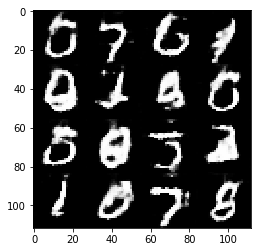

Epoch 1/2...Batch 810 Discriminator Loss: 1.3010... Generator Loss: 0.6928
Epoch 1/2...Batch 820 Discriminator Loss: 1.2706... Generator Loss: 0.7785
Epoch 1/2...Batch 830 Discriminator Loss: 1.2085... Generator Loss: 0.8682
Epoch 1/2...Batch 840 Discriminator Loss: 1.2434... Generator Loss: 0.8720
Epoch 1/2...Batch 850 Discriminator Loss: 1.3573... Generator Loss: 1.3300
Epoch 1/2...Batch 860 Discriminator Loss: 1.2594... Generator Loss: 2.1022
Epoch 1/2...Batch 870 Discriminator Loss: 1.6934... Generator Loss: 2.0538
Epoch 1/2...Batch 880 Discriminator Loss: 1.1711... Generator Loss: 1.8374
Epoch 1/2...Batch 890 Discriminator Loss: 1.2723... Generator Loss: 0.7473
Epoch 1/2...Batch 900 Discriminator Loss: 1.2177... Generator Loss: 0.8531


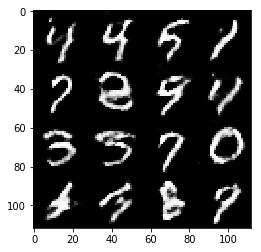

Epoch 1/2...Batch 910 Discriminator Loss: 1.1786... Generator Loss: 0.9099
Epoch 1/2...Batch 920 Discriminator Loss: 1.1042... Generator Loss: 1.6687
Epoch 1/2...Batch 930 Discriminator Loss: 1.0052... Generator Loss: 1.2700
Epoch 1/2...Batch 940 Discriminator Loss: 1.2090... Generator Loss: 1.4903
Epoch 1/2...Batch 950 Discriminator Loss: 2.0443... Generator Loss: 0.2382
Epoch 1/2...Batch 960 Discriminator Loss: 1.2747... Generator Loss: 1.1989
Epoch 1/2...Batch 970 Discriminator Loss: 1.2824... Generator Loss: 0.6376
Epoch 1/2...Batch 980 Discriminator Loss: 1.1927... Generator Loss: 1.9515
Epoch 1/2...Batch 990 Discriminator Loss: 1.1377... Generator Loss: 0.7180
Epoch 1/2...Batch 1000 Discriminator Loss: 1.2040... Generator Loss: 0.7508


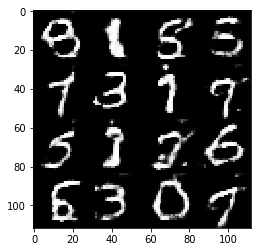

Epoch 1/2...Batch 1010 Discriminator Loss: 1.1452... Generator Loss: 1.9432
Epoch 1/2...Batch 1020 Discriminator Loss: 1.0462... Generator Loss: 1.2938
Epoch 1/2...Batch 1030 Discriminator Loss: 1.0403... Generator Loss: 1.4089
Epoch 1/2...Batch 1040 Discriminator Loss: 1.3883... Generator Loss: 1.9208
Epoch 1/2...Batch 1050 Discriminator Loss: 1.2998... Generator Loss: 0.6006
Epoch 1/2...Batch 1060 Discriminator Loss: 1.0259... Generator Loss: 0.8825
Epoch 1/2...Batch 1070 Discriminator Loss: 2.2122... Generator Loss: 2.8936
Epoch 1/2...Batch 1080 Discriminator Loss: 1.3906... Generator Loss: 0.5067
Epoch 1/2...Batch 1090 Discriminator Loss: 1.2045... Generator Loss: 0.6932
Epoch 1/2...Batch 1100 Discriminator Loss: 0.9557... Generator Loss: 1.2278


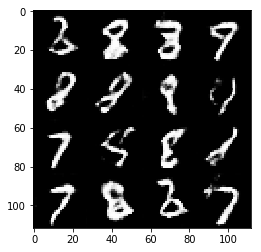

Epoch 1/2...Batch 1110 Discriminator Loss: 1.3989... Generator Loss: 0.4954
Epoch 1/2...Batch 1120 Discriminator Loss: 1.1962... Generator Loss: 0.6357
Epoch 1/2...Batch 1130 Discriminator Loss: 1.6806... Generator Loss: 0.3415
Epoch 1/2...Batch 1140 Discriminator Loss: 1.5030... Generator Loss: 2.0937
Epoch 1/2...Batch 1150 Discriminator Loss: 1.2815... Generator Loss: 0.5305
Epoch 1/2...Batch 1160 Discriminator Loss: 1.2251... Generator Loss: 0.8334
Epoch 1/2...Batch 1170 Discriminator Loss: 0.9073... Generator Loss: 1.1177
Epoch 1/2...Batch 1180 Discriminator Loss: 1.0985... Generator Loss: 1.9133
Epoch 1/2...Batch 1190 Discriminator Loss: 1.3480... Generator Loss: 2.3289
Epoch 1/2...Batch 1200 Discriminator Loss: 1.4219... Generator Loss: 0.4554


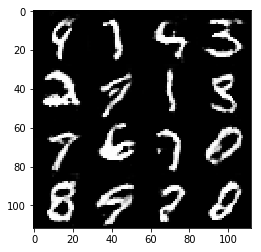

Epoch 1/2...Batch 1210 Discriminator Loss: 1.2303... Generator Loss: 1.0052
Epoch 1/2...Batch 1220 Discriminator Loss: 1.1745... Generator Loss: 1.5446
Epoch 1/2...Batch 1230 Discriminator Loss: 1.0885... Generator Loss: 1.4977
Epoch 1/2...Batch 1240 Discriminator Loss: 1.0629... Generator Loss: 1.5150
Epoch 1/2...Batch 1250 Discriminator Loss: 0.9062... Generator Loss: 1.0196
Epoch 1/2...Batch 1260 Discriminator Loss: 1.4216... Generator Loss: 0.5779
Epoch 1/2...Batch 1270 Discriminator Loss: 1.1812... Generator Loss: 0.9780
Epoch 1/2...Batch 1280 Discriminator Loss: 0.9778... Generator Loss: 1.0007
Epoch 1/2...Batch 1290 Discriminator Loss: 1.5188... Generator Loss: 0.4431
Epoch 1/2...Batch 1300 Discriminator Loss: 0.9638... Generator Loss: 1.6374


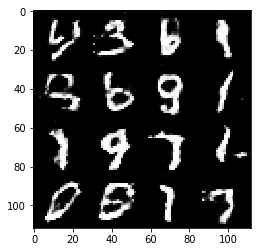

Epoch 1/2...Batch 1310 Discriminator Loss: 1.7284... Generator Loss: 2.1712
Epoch 1/2...Batch 1320 Discriminator Loss: 1.5504... Generator Loss: 0.4376
Epoch 1/2...Batch 1330 Discriminator Loss: 1.0712... Generator Loss: 1.4125
Epoch 1/2...Batch 1340 Discriminator Loss: 0.8999... Generator Loss: 0.9351
Epoch 1/2...Batch 1350 Discriminator Loss: 1.4233... Generator Loss: 0.5195
Epoch 1/2...Batch 1360 Discriminator Loss: 1.1711... Generator Loss: 0.8002
Epoch 1/2...Batch 1370 Discriminator Loss: 1.2847... Generator Loss: 2.2111
Epoch 1/2...Batch 1380 Discriminator Loss: 1.2437... Generator Loss: 2.1559
Epoch 1/2...Batch 1390 Discriminator Loss: 0.8866... Generator Loss: 1.3721
Epoch 1/2...Batch 1400 Discriminator Loss: 1.1658... Generator Loss: 0.8076


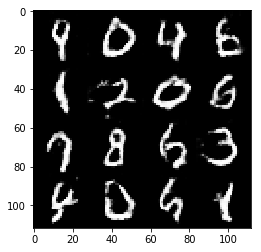

Epoch 1/2...Batch 1410 Discriminator Loss: 1.2036... Generator Loss: 0.6948
Epoch 1/2...Batch 1420 Discriminator Loss: 1.0271... Generator Loss: 1.1868
Epoch 1/2...Batch 1430 Discriminator Loss: 0.9524... Generator Loss: 1.0747
Epoch 1/2...Batch 1440 Discriminator Loss: 0.9467... Generator Loss: 1.2616
Epoch 1/2...Batch 1450 Discriminator Loss: 1.0770... Generator Loss: 1.5510
Epoch 1/2...Batch 1460 Discriminator Loss: 1.0808... Generator Loss: 0.7352
Epoch 1/2...Batch 1470 Discriminator Loss: 1.9723... Generator Loss: 0.2469
Epoch 1/2...Batch 1480 Discriminator Loss: 1.6757... Generator Loss: 0.3817
Epoch 1/2...Batch 1490 Discriminator Loss: 1.8817... Generator Loss: 0.2995
Epoch 1/2...Batch 1500 Discriminator Loss: 0.7627... Generator Loss: 1.3547


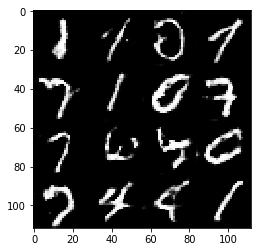

Epoch 1/2...Batch 1510 Discriminator Loss: 1.2986... Generator Loss: 0.5527
Epoch 1/2...Batch 1520 Discriminator Loss: 1.1902... Generator Loss: 0.6518
Epoch 1/2...Batch 1530 Discriminator Loss: 0.8596... Generator Loss: 1.5358
Epoch 1/2...Batch 1540 Discriminator Loss: 0.9177... Generator Loss: 0.9190
Epoch 1/2...Batch 1550 Discriminator Loss: 0.6780... Generator Loss: 1.4619
Epoch 1/2...Batch 1560 Discriminator Loss: 2.2571... Generator Loss: 2.6747
Epoch 1/2...Batch 1570 Discriminator Loss: 1.0228... Generator Loss: 0.7859
Epoch 1/2...Batch 1580 Discriminator Loss: 0.8902... Generator Loss: 1.2794
Epoch 1/2...Batch 1590 Discriminator Loss: 1.3456... Generator Loss: 0.5075
Epoch 1/2...Batch 1600 Discriminator Loss: 0.8990... Generator Loss: 1.8263


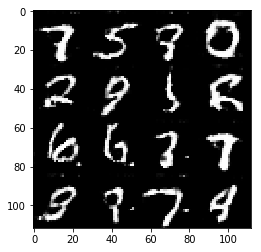

Epoch 1/2...Batch 1610 Discriminator Loss: 0.8359... Generator Loss: 1.1196
Epoch 1/2...Batch 1620 Discriminator Loss: 2.0049... Generator Loss: 0.2655
Epoch 1/2...Batch 1630 Discriminator Loss: 0.9957... Generator Loss: 0.8103
Epoch 1/2...Batch 1640 Discriminator Loss: 0.5892... Generator Loss: 1.9476
Epoch 1/2...Batch 1650 Discriminator Loss: 0.9711... Generator Loss: 1.9273
Epoch 1/2...Batch 1660 Discriminator Loss: 0.7677... Generator Loss: 2.2533
Epoch 1/2...Batch 1670 Discriminator Loss: 1.3213... Generator Loss: 0.5668
Epoch 1/2...Batch 1680 Discriminator Loss: 1.2734... Generator Loss: 0.6204
Epoch 1/2...Batch 1690 Discriminator Loss: 1.7653... Generator Loss: 0.3777
Epoch 1/2...Batch 1700 Discriminator Loss: 1.8438... Generator Loss: 3.3838


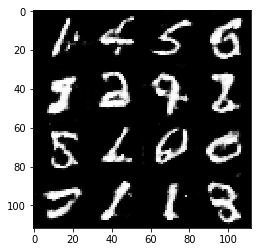

Epoch 1/2...Batch 1710 Discriminator Loss: 1.3282... Generator Loss: 0.5269
Epoch 1/2...Batch 1720 Discriminator Loss: 1.2766... Generator Loss: 0.5977
Epoch 1/2...Batch 1730 Discriminator Loss: 0.7772... Generator Loss: 1.7621
Epoch 1/2...Batch 1740 Discriminator Loss: 1.2193... Generator Loss: 0.6272
Epoch 1/2...Batch 1750 Discriminator Loss: 1.7581... Generator Loss: 0.3177
Epoch 1/2...Batch 1760 Discriminator Loss: 0.5956... Generator Loss: 1.8627
Epoch 1/2...Batch 1770 Discriminator Loss: 1.3917... Generator Loss: 0.5490
Epoch 1/2...Batch 1780 Discriminator Loss: 1.0802... Generator Loss: 0.7859
Epoch 1/2...Batch 1790 Discriminator Loss: 0.8153... Generator Loss: 1.3360
Epoch 1/2...Batch 1800 Discriminator Loss: 0.8317... Generator Loss: 1.6052


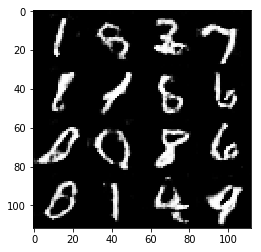

Epoch 1/2...Batch 1810 Discriminator Loss: 0.9271... Generator Loss: 1.0136
Epoch 1/2...Batch 1820 Discriminator Loss: 0.7669... Generator Loss: 1.5714
Epoch 1/2...Batch 1830 Discriminator Loss: 1.4843... Generator Loss: 2.6480
Epoch 1/2...Batch 1840 Discriminator Loss: 1.0648... Generator Loss: 0.8868
Epoch 1/2...Batch 1850 Discriminator Loss: 1.4848... Generator Loss: 0.5122
Epoch 1/2...Batch 1860 Discriminator Loss: 1.3194... Generator Loss: 0.5352
Epoch 1/2...Batch 1870 Discriminator Loss: 0.7449... Generator Loss: 1.3163
Epoch 2/2...Batch 1880 Discriminator Loss: 0.8239... Generator Loss: 1.0781
Epoch 2/2...Batch 1890 Discriminator Loss: 1.0695... Generator Loss: 0.8922
Epoch 2/2...Batch 1900 Discriminator Loss: 1.2432... Generator Loss: 0.5925


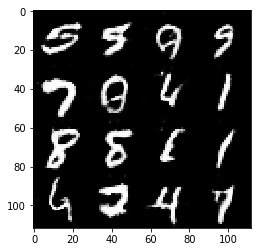

Epoch 2/2...Batch 1910 Discriminator Loss: 1.3758... Generator Loss: 0.5092
Epoch 2/2...Batch 1920 Discriminator Loss: 1.0018... Generator Loss: 0.7901
Epoch 2/2...Batch 1930 Discriminator Loss: 2.2877... Generator Loss: 3.9636
Epoch 2/2...Batch 1940 Discriminator Loss: 1.2288... Generator Loss: 0.7357
Epoch 2/2...Batch 1950 Discriminator Loss: 0.7756... Generator Loss: 1.3458
Epoch 2/2...Batch 1960 Discriminator Loss: 0.8576... Generator Loss: 1.0618
Epoch 2/2...Batch 1970 Discriminator Loss: 0.8996... Generator Loss: 1.6431
Epoch 2/2...Batch 1980 Discriminator Loss: 0.9814... Generator Loss: 0.8555
Epoch 2/2...Batch 1990 Discriminator Loss: 2.1185... Generator Loss: 0.2390
Epoch 2/2...Batch 2000 Discriminator Loss: 1.5944... Generator Loss: 0.4077


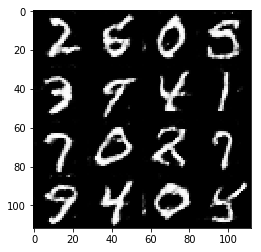

Epoch 2/2...Batch 2010 Discriminator Loss: 1.0417... Generator Loss: 0.8212
Epoch 2/2...Batch 2020 Discriminator Loss: 1.6752... Generator Loss: 0.3986
Epoch 2/2...Batch 2030 Discriminator Loss: 0.8330... Generator Loss: 1.0897
Epoch 2/2...Batch 2040 Discriminator Loss: 1.0040... Generator Loss: 2.0362
Epoch 2/2...Batch 2050 Discriminator Loss: 0.8731... Generator Loss: 0.9986
Epoch 2/2...Batch 2060 Discriminator Loss: 2.0391... Generator Loss: 0.2823
Epoch 2/2...Batch 2070 Discriminator Loss: 1.2232... Generator Loss: 0.6432
Epoch 2/2...Batch 2080 Discriminator Loss: 0.9388... Generator Loss: 1.5447
Epoch 2/2...Batch 2090 Discriminator Loss: 0.9624... Generator Loss: 1.0306
Epoch 2/2...Batch 2100 Discriminator Loss: 1.0525... Generator Loss: 0.7400


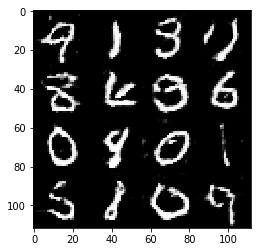

Epoch 2/2...Batch 2110 Discriminator Loss: 1.4085... Generator Loss: 0.5002
Epoch 2/2...Batch 2120 Discriminator Loss: 1.1483... Generator Loss: 0.7086
Epoch 2/2...Batch 2130 Discriminator Loss: 1.0531... Generator Loss: 0.9999
Epoch 2/2...Batch 2140 Discriminator Loss: 0.9708... Generator Loss: 2.4076
Epoch 2/2...Batch 2150 Discriminator Loss: 0.7708... Generator Loss: 1.2143
Epoch 2/2...Batch 2160 Discriminator Loss: 1.0015... Generator Loss: 2.5049
Epoch 2/2...Batch 2170 Discriminator Loss: 1.7435... Generator Loss: 3.0410
Epoch 2/2...Batch 2180 Discriminator Loss: 1.1685... Generator Loss: 0.6586
Epoch 2/2...Batch 2190 Discriminator Loss: 0.9189... Generator Loss: 0.9769
Epoch 2/2...Batch 2200 Discriminator Loss: 1.5380... Generator Loss: 0.4903


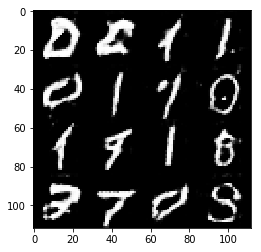

Epoch 2/2...Batch 2210 Discriminator Loss: 0.7732... Generator Loss: 1.1751
Epoch 2/2...Batch 2220 Discriminator Loss: 0.9700... Generator Loss: 1.3596
Epoch 2/2...Batch 2230 Discriminator Loss: 0.6935... Generator Loss: 1.6166
Epoch 2/2...Batch 2240 Discriminator Loss: 1.1011... Generator Loss: 0.7953
Epoch 2/2...Batch 2250 Discriminator Loss: 1.0467... Generator Loss: 2.0666
Epoch 2/2...Batch 2260 Discriminator Loss: 0.9933... Generator Loss: 0.8609
Epoch 2/2...Batch 2270 Discriminator Loss: 0.5006... Generator Loss: 2.1384
Epoch 2/2...Batch 2280 Discriminator Loss: 0.8075... Generator Loss: 1.5489
Epoch 2/2...Batch 2290 Discriminator Loss: 0.7620... Generator Loss: 1.3779
Epoch 2/2...Batch 2300 Discriminator Loss: 1.4149... Generator Loss: 0.5157


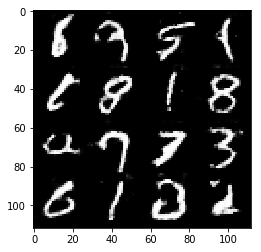

Epoch 2/2...Batch 2310 Discriminator Loss: 0.8554... Generator Loss: 2.2572
Epoch 2/2...Batch 2320 Discriminator Loss: 1.2954... Generator Loss: 0.6544
Epoch 2/2...Batch 2330 Discriminator Loss: 1.0730... Generator Loss: 0.8203
Epoch 2/2...Batch 2340 Discriminator Loss: 0.8963... Generator Loss: 1.0378
Epoch 2/2...Batch 2350 Discriminator Loss: 1.2232... Generator Loss: 2.2592
Epoch 2/2...Batch 2360 Discriminator Loss: 0.8684... Generator Loss: 1.0226
Epoch 2/2...Batch 2370 Discriminator Loss: 0.9353... Generator Loss: 0.9903
Epoch 2/2...Batch 2380 Discriminator Loss: 0.8626... Generator Loss: 2.4522
Epoch 2/2...Batch 2390 Discriminator Loss: 0.9464... Generator Loss: 0.9589
Epoch 2/2...Batch 2400 Discriminator Loss: 0.7667... Generator Loss: 2.3568


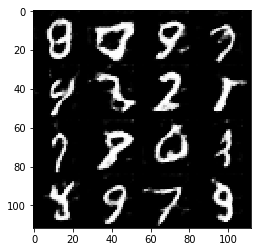

Epoch 2/2...Batch 2410 Discriminator Loss: 0.5940... Generator Loss: 1.7089
Epoch 2/2...Batch 2420 Discriminator Loss: 1.2329... Generator Loss: 0.6525
Epoch 2/2...Batch 2430 Discriminator Loss: 0.7616... Generator Loss: 1.3861
Epoch 2/2...Batch 2440 Discriminator Loss: 1.8240... Generator Loss: 0.4000
Epoch 2/2...Batch 2450 Discriminator Loss: 0.8565... Generator Loss: 1.0375
Epoch 2/2...Batch 2460 Discriminator Loss: 0.8460... Generator Loss: 1.2510
Epoch 2/2...Batch 2470 Discriminator Loss: 0.9062... Generator Loss: 1.7178
Epoch 2/2...Batch 2480 Discriminator Loss: 1.0990... Generator Loss: 0.6888
Epoch 2/2...Batch 2490 Discriminator Loss: 0.8598... Generator Loss: 1.5387
Epoch 2/2...Batch 2500 Discriminator Loss: 1.6565... Generator Loss: 0.4321


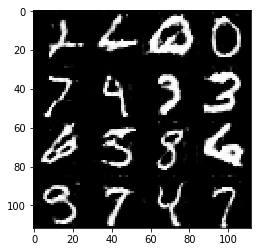

Epoch 2/2...Batch 2510 Discriminator Loss: 1.0373... Generator Loss: 3.2220
Epoch 2/2...Batch 2520 Discriminator Loss: 1.2972... Generator Loss: 0.5935
Epoch 2/2...Batch 2530 Discriminator Loss: 0.7863... Generator Loss: 1.8341
Epoch 2/2...Batch 2540 Discriminator Loss: 1.9153... Generator Loss: 0.4245
Epoch 2/2...Batch 2550 Discriminator Loss: 1.4054... Generator Loss: 0.5153
Epoch 2/2...Batch 2560 Discriminator Loss: 1.0125... Generator Loss: 0.8724
Epoch 2/2...Batch 2570 Discriminator Loss: 0.9747... Generator Loss: 0.9278
Epoch 2/2...Batch 2580 Discriminator Loss: 0.8782... Generator Loss: 1.1670
Epoch 2/2...Batch 2590 Discriminator Loss: 0.6922... Generator Loss: 1.6776
Epoch 2/2...Batch 2600 Discriminator Loss: 0.6991... Generator Loss: 1.4354


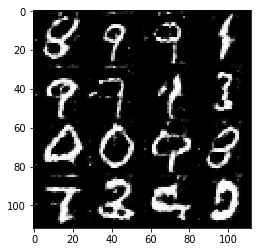

Epoch 2/2...Batch 2610 Discriminator Loss: 0.9177... Generator Loss: 1.0130
Epoch 2/2...Batch 2620 Discriminator Loss: 2.0494... Generator Loss: 0.2550
Epoch 2/2...Batch 2630 Discriminator Loss: 0.6538... Generator Loss: 1.7818
Epoch 2/2...Batch 2640 Discriminator Loss: 0.5981... Generator Loss: 1.7910
Epoch 2/2...Batch 2650 Discriminator Loss: 2.1891... Generator Loss: 0.2997
Epoch 2/2...Batch 2660 Discriminator Loss: 1.1134... Generator Loss: 2.2414
Epoch 2/2...Batch 2670 Discriminator Loss: 0.7715... Generator Loss: 1.6947
Epoch 2/2...Batch 2680 Discriminator Loss: 1.0252... Generator Loss: 0.8914
Epoch 2/2...Batch 2690 Discriminator Loss: 0.7720... Generator Loss: 1.3041
Epoch 2/2...Batch 2700 Discriminator Loss: 1.8482... Generator Loss: 0.4489


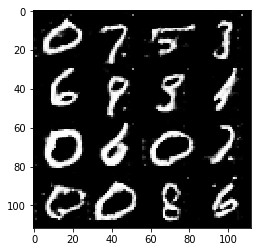

Epoch 2/2...Batch 2710 Discriminator Loss: 0.7182... Generator Loss: 1.9461
Epoch 2/2...Batch 2720 Discriminator Loss: 1.1292... Generator Loss: 0.6958
Epoch 2/2...Batch 2730 Discriminator Loss: 0.8801... Generator Loss: 1.0576
Epoch 2/2...Batch 2740 Discriminator Loss: 0.8147... Generator Loss: 2.0685
Epoch 2/2...Batch 2750 Discriminator Loss: 0.9843... Generator Loss: 0.9383
Epoch 2/2...Batch 2760 Discriminator Loss: 2.0117... Generator Loss: 0.3783
Epoch 2/2...Batch 2770 Discriminator Loss: 1.3042... Generator Loss: 0.5772
Epoch 2/2...Batch 2780 Discriminator Loss: 0.5544... Generator Loss: 1.8642
Epoch 2/2...Batch 2790 Discriminator Loss: 1.9325... Generator Loss: 0.3437
Epoch 2/2...Batch 2800 Discriminator Loss: 2.0299... Generator Loss: 0.4153


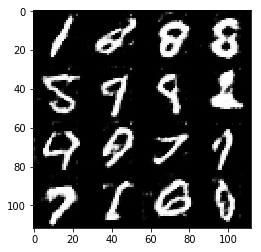

Epoch 2/2...Batch 2810 Discriminator Loss: 0.9188... Generator Loss: 1.9371
Epoch 2/2...Batch 2820 Discriminator Loss: 0.6759... Generator Loss: 2.1656
Epoch 2/2...Batch 2830 Discriminator Loss: 2.1878... Generator Loss: 0.2801
Epoch 2/2...Batch 2840 Discriminator Loss: 0.5531... Generator Loss: 2.0441
Epoch 2/2...Batch 2850 Discriminator Loss: 1.7125... Generator Loss: 0.5344
Epoch 2/2...Batch 2860 Discriminator Loss: 0.9820... Generator Loss: 2.9315
Epoch 2/2...Batch 2870 Discriminator Loss: 0.5479... Generator Loss: 2.0212
Epoch 2/2...Batch 2880 Discriminator Loss: 1.5986... Generator Loss: 0.4674
Epoch 2/2...Batch 2890 Discriminator Loss: 1.0415... Generator Loss: 2.2117
Epoch 2/2...Batch 2900 Discriminator Loss: 1.1631... Generator Loss: 2.8628


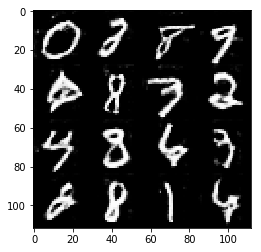

Epoch 2/2...Batch 2910 Discriminator Loss: 0.8364... Generator Loss: 1.1103
Epoch 2/2...Batch 2920 Discriminator Loss: 0.7779... Generator Loss: 1.7738
Epoch 2/2...Batch 2930 Discriminator Loss: 1.3358... Generator Loss: 0.5644
Epoch 2/2...Batch 2940 Discriminator Loss: 0.7244... Generator Loss: 2.2565
Epoch 2/2...Batch 2950 Discriminator Loss: 0.9442... Generator Loss: 2.5680
Epoch 2/2...Batch 2960 Discriminator Loss: 1.2070... Generator Loss: 0.6395
Epoch 2/2...Batch 2970 Discriminator Loss: 0.7010... Generator Loss: 1.3897
Epoch 2/2...Batch 2980 Discriminator Loss: 0.7309... Generator Loss: 1.4012
Epoch 2/2...Batch 2990 Discriminator Loss: 0.5940... Generator Loss: 1.7531
Epoch 2/2...Batch 3000 Discriminator Loss: 1.1672... Generator Loss: 0.7362


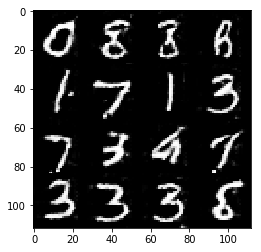

Epoch 2/2...Batch 3010 Discriminator Loss: 1.4403... Generator Loss: 0.4746
Epoch 2/2...Batch 3020 Discriminator Loss: 1.3127... Generator Loss: 0.5885
Epoch 2/2...Batch 3030 Discriminator Loss: 0.6225... Generator Loss: 1.6517
Epoch 2/2...Batch 3040 Discriminator Loss: 0.9988... Generator Loss: 0.9050
Epoch 2/2...Batch 3050 Discriminator Loss: 0.8031... Generator Loss: 2.3576
Epoch 2/2...Batch 3060 Discriminator Loss: 0.7603... Generator Loss: 1.3295
Epoch 2/2...Batch 3070 Discriminator Loss: 1.0438... Generator Loss: 2.8768
Epoch 2/2...Batch 3080 Discriminator Loss: 0.8844... Generator Loss: 2.8125
Epoch 2/2...Batch 3090 Discriminator Loss: 0.8362... Generator Loss: 1.0553
Epoch 2/2...Batch 3100 Discriminator Loss: 1.6087... Generator Loss: 0.4434


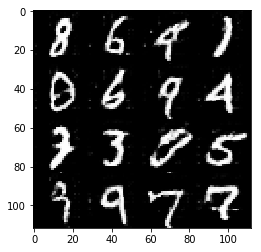

Epoch 2/2...Batch 3110 Discriminator Loss: 1.1646... Generator Loss: 0.6900
Epoch 2/2...Batch 3120 Discriminator Loss: 0.6710... Generator Loss: 1.7452
Epoch 2/2...Batch 3130 Discriminator Loss: 1.4477... Generator Loss: 0.5033
Epoch 2/2...Batch 3140 Discriminator Loss: 2.2122... Generator Loss: 0.2224
Epoch 2/2...Batch 3150 Discriminator Loss: 0.5863... Generator Loss: 2.0270
Epoch 2/2...Batch 3160 Discriminator Loss: 0.7306... Generator Loss: 1.7377
Epoch 2/2...Batch 3170 Discriminator Loss: 0.9232... Generator Loss: 0.9504
Epoch 2/2...Batch 3180 Discriminator Loss: 0.6381... Generator Loss: 2.5344
Epoch 2/2...Batch 3190 Discriminator Loss: 0.8350... Generator Loss: 1.2384
Epoch 2/2...Batch 3200 Discriminator Loss: 0.8214... Generator Loss: 2.2099


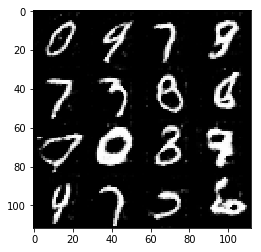

Epoch 2/2...Batch 3210 Discriminator Loss: 0.9957... Generator Loss: 0.8550
Epoch 2/2...Batch 3220 Discriminator Loss: 0.6690... Generator Loss: 2.5660
Epoch 2/2...Batch 3230 Discriminator Loss: 0.8642... Generator Loss: 2.7487
Epoch 2/2...Batch 3240 Discriminator Loss: 1.3158... Generator Loss: 0.6067
Epoch 2/2...Batch 3250 Discriminator Loss: 0.6740... Generator Loss: 1.7532
Epoch 2/2...Batch 3260 Discriminator Loss: 0.5921... Generator Loss: 1.7837
Epoch 2/2...Batch 3270 Discriminator Loss: 1.0215... Generator Loss: 0.7964
Epoch 2/2...Batch 3280 Discriminator Loss: 1.2295... Generator Loss: 0.7245
Epoch 2/2...Batch 3290 Discriminator Loss: 0.9217... Generator Loss: 1.0250
Epoch 2/2...Batch 3300 Discriminator Loss: 1.1351... Generator Loss: 0.7373


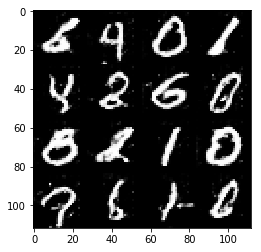

Epoch 2/2...Batch 3310 Discriminator Loss: 1.0331... Generator Loss: 0.9340
Epoch 2/2...Batch 3320 Discriminator Loss: 0.7466... Generator Loss: 1.5054
Epoch 2/2...Batch 3330 Discriminator Loss: 0.5908... Generator Loss: 1.8049
Epoch 2/2...Batch 3340 Discriminator Loss: 1.5335... Generator Loss: 0.4729
Epoch 2/2...Batch 3350 Discriminator Loss: 1.1190... Generator Loss: 0.8764
Epoch 2/2...Batch 3360 Discriminator Loss: 1.3100... Generator Loss: 0.7014
Epoch 2/2...Batch 3370 Discriminator Loss: 0.9507... Generator Loss: 0.9252
Epoch 2/2...Batch 3380 Discriminator Loss: 0.5993... Generator Loss: 1.7228
Epoch 2/2...Batch 3390 Discriminator Loss: 0.7029... Generator Loss: 1.5659
Epoch 2/2...Batch 3400 Discriminator Loss: 1.0454... Generator Loss: 1.0386


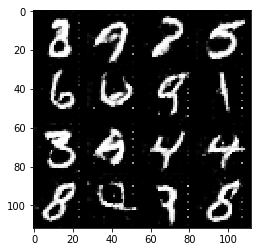

Epoch 2/2...Batch 3410 Discriminator Loss: 1.6672... Generator Loss: 3.2950
Epoch 2/2...Batch 3420 Discriminator Loss: 0.8257... Generator Loss: 1.9639
Epoch 2/2...Batch 3430 Discriminator Loss: 1.3492... Generator Loss: 0.5802
Epoch 2/2...Batch 3440 Discriminator Loss: 0.9189... Generator Loss: 2.5593
Epoch 2/2...Batch 3450 Discriminator Loss: 0.8332... Generator Loss: 1.2171
Epoch 2/2...Batch 3460 Discriminator Loss: 1.1159... Generator Loss: 0.7424
Epoch 2/2...Batch 3470 Discriminator Loss: 0.6758... Generator Loss: 1.4005
Epoch 2/2...Batch 3480 Discriminator Loss: 0.7654... Generator Loss: 3.1807
Epoch 2/2...Batch 3490 Discriminator Loss: 0.9969... Generator Loss: 1.9406
Epoch 2/2...Batch 3500 Discriminator Loss: 0.7100... Generator Loss: 1.4246


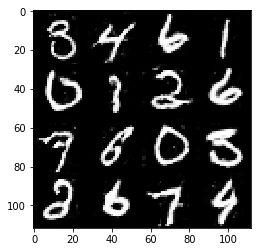

Epoch 2/2...Batch 3510 Discriminator Loss: 0.7723... Generator Loss: 1.2849
Epoch 2/2...Batch 3520 Discriminator Loss: 0.5773... Generator Loss: 1.9336
Epoch 2/2...Batch 3530 Discriminator Loss: 0.7086... Generator Loss: 1.3836
Epoch 2/2...Batch 3540 Discriminator Loss: 1.6118... Generator Loss: 0.4872
Epoch 2/2...Batch 3550 Discriminator Loss: 1.6354... Generator Loss: 0.4800
Epoch 2/2...Batch 3560 Discriminator Loss: 1.1245... Generator Loss: 0.8141
Epoch 2/2...Batch 3570 Discriminator Loss: 1.3591... Generator Loss: 4.3775
Epoch 2/2...Batch 3580 Discriminator Loss: 0.6930... Generator Loss: 1.7505
Epoch 2/2...Batch 3590 Discriminator Loss: 1.1937... Generator Loss: 0.7181
Epoch 2/2...Batch 3600 Discriminator Loss: 1.1894... Generator Loss: 0.6788


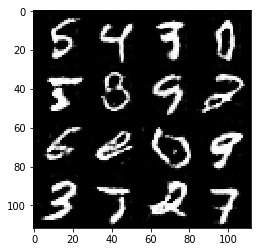

Epoch 2/2...Batch 3610 Discriminator Loss: 1.8116... Generator Loss: 0.4424
Epoch 2/2...Batch 3620 Discriminator Loss: 0.6558... Generator Loss: 1.5795
Epoch 2/2...Batch 3630 Discriminator Loss: 0.8557... Generator Loss: 1.1389
Epoch 2/2...Batch 3640 Discriminator Loss: 0.6750... Generator Loss: 1.4852
Epoch 2/2...Batch 3650 Discriminator Loss: 0.4312... Generator Loss: 2.6515
Epoch 2/2...Batch 3660 Discriminator Loss: 0.8154... Generator Loss: 1.2305
Epoch 2/2...Batch 3670 Discriminator Loss: 0.7793... Generator Loss: 1.4277
Epoch 2/2...Batch 3680 Discriminator Loss: 0.7960... Generator Loss: 1.9818
Epoch 2/2...Batch 3690 Discriminator Loss: 1.1690... Generator Loss: 0.6762
Epoch 2/2...Batch 3700 Discriminator Loss: 0.5527... Generator Loss: 1.7947


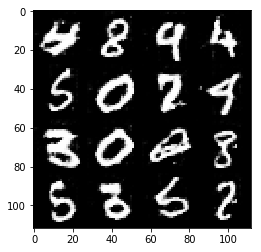

Epoch 2/2...Batch 3710 Discriminator Loss: 1.1641... Generator Loss: 3.2006
Epoch 2/2...Batch 3720 Discriminator Loss: 1.0788... Generator Loss: 0.7915
Epoch 2/2...Batch 3730 Discriminator Loss: 1.2440... Generator Loss: 0.6162
Epoch 2/2...Batch 3740 Discriminator Loss: 1.5359... Generator Loss: 2.4604
Epoch 2/2...Batch 3750 Discriminator Loss: 0.8443... Generator Loss: 1.4912


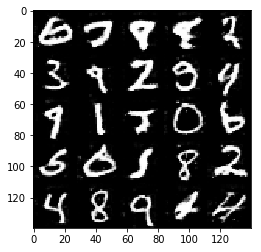

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1...Batch 10 Discriminator Loss: 5.7954... Generator Loss: 0.0051
Epoch 1/1...Batch 20 Discriminator Loss: 2.2472... Generator Loss: 7.9940
Epoch 1/1...Batch 30 Discriminator Loss: 1.0755... Generator Loss: 3.8319
Epoch 1/1...Batch 40 Discriminator Loss: 1.7821... Generator Loss: 0.4903
Epoch 1/1...Batch 50 Discriminator Loss: 1.4717... Generator Loss: 1.1481
Epoch 1/1...Batch 60 Discriminator Loss: 1.9965... Generator Loss: 1.9204
Epoch 1/1...Batch 70 Discriminator Loss: 2.4452... Generator Loss: 0.2114
Epoch 1/1...Batch 80 Discriminator Loss: 1.2327... Generator Loss: 0.7607
Epoch 1/1...Batch 90 Discriminator Loss: 1.9217... Generator Loss: 0.4479
Epoch 1/1...Batch 100 Discriminator Loss: 1.8299... Generator Loss: 0.5496


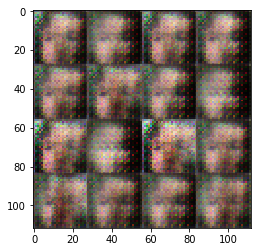

Epoch 1/1...Batch 110 Discriminator Loss: 1.1486... Generator Loss: 1.1171
Epoch 1/1...Batch 120 Discriminator Loss: 1.1404... Generator Loss: 1.0448
Epoch 1/1...Batch 130 Discriminator Loss: 1.5380... Generator Loss: 0.7061
Epoch 1/1...Batch 140 Discriminator Loss: 2.0398... Generator Loss: 0.4360
Epoch 1/1...Batch 150 Discriminator Loss: 1.4549... Generator Loss: 1.0461
Epoch 1/1...Batch 160 Discriminator Loss: 1.3819... Generator Loss: 1.3019
Epoch 1/1...Batch 170 Discriminator Loss: 1.6334... Generator Loss: 0.6646
Epoch 1/1...Batch 180 Discriminator Loss: 1.5831... Generator Loss: 0.8034
Epoch 1/1...Batch 190 Discriminator Loss: 1.3940... Generator Loss: 0.6531
Epoch 1/1...Batch 200 Discriminator Loss: 1.7055... Generator Loss: 0.6259


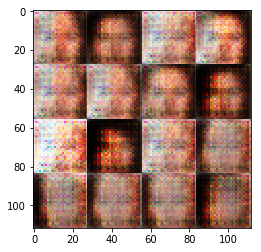

Epoch 1/1...Batch 210 Discriminator Loss: 1.4174... Generator Loss: 0.9098
Epoch 1/1...Batch 220 Discriminator Loss: 1.5707... Generator Loss: 0.7789
Epoch 1/1...Batch 230 Discriminator Loss: 1.4794... Generator Loss: 1.5170
Epoch 1/1...Batch 240 Discriminator Loss: 1.5536... Generator Loss: 0.7438
Epoch 1/1...Batch 250 Discriminator Loss: 1.8395... Generator Loss: 0.5610
Epoch 1/1...Batch 260 Discriminator Loss: 1.5075... Generator Loss: 0.7463
Epoch 1/1...Batch 270 Discriminator Loss: 1.3949... Generator Loss: 0.8143
Epoch 1/1...Batch 280 Discriminator Loss: 1.4023... Generator Loss: 0.7048
Epoch 1/1...Batch 290 Discriminator Loss: 1.2873... Generator Loss: 0.8038
Epoch 1/1...Batch 300 Discriminator Loss: 1.4139... Generator Loss: 0.8610


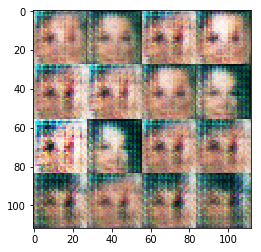

Epoch 1/1...Batch 310 Discriminator Loss: 1.5836... Generator Loss: 0.7742
Epoch 1/1...Batch 320 Discriminator Loss: 1.1803... Generator Loss: 0.8681
Epoch 1/1...Batch 330 Discriminator Loss: 1.4318... Generator Loss: 0.8647
Epoch 1/1...Batch 340 Discriminator Loss: 1.3988... Generator Loss: 0.8925
Epoch 1/1...Batch 350 Discriminator Loss: 1.4430... Generator Loss: 0.6678
Epoch 1/1...Batch 360 Discriminator Loss: 1.3451... Generator Loss: 0.7160
Epoch 1/1...Batch 370 Discriminator Loss: 1.7007... Generator Loss: 0.6260
Epoch 1/1...Batch 380 Discriminator Loss: 1.7681... Generator Loss: 0.7364
Epoch 1/1...Batch 390 Discriminator Loss: 1.5779... Generator Loss: 0.5981
Epoch 1/1...Batch 400 Discriminator Loss: 1.7451... Generator Loss: 1.5259


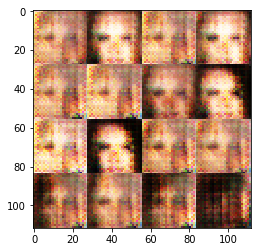

Epoch 1/1...Batch 410 Discriminator Loss: 1.4559... Generator Loss: 0.8010
Epoch 1/1...Batch 420 Discriminator Loss: 1.2860... Generator Loss: 1.0736
Epoch 1/1...Batch 430 Discriminator Loss: 1.2313... Generator Loss: 0.9644
Epoch 1/1...Batch 440 Discriminator Loss: 1.4967... Generator Loss: 0.7380
Epoch 1/1...Batch 450 Discriminator Loss: 1.4934... Generator Loss: 0.6948
Epoch 1/1...Batch 460 Discriminator Loss: 1.3346... Generator Loss: 0.8597
Epoch 1/1...Batch 470 Discriminator Loss: 1.3154... Generator Loss: 0.7493
Epoch 1/1...Batch 480 Discriminator Loss: 1.4387... Generator Loss: 0.5539
Epoch 1/1...Batch 490 Discriminator Loss: 1.5821... Generator Loss: 0.7070
Epoch 1/1...Batch 500 Discriminator Loss: 1.6087... Generator Loss: 0.4680


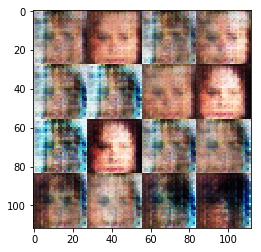

Epoch 1/1...Batch 510 Discriminator Loss: 1.3923... Generator Loss: 0.7629
Epoch 1/1...Batch 520 Discriminator Loss: 1.4152... Generator Loss: 0.8838
Epoch 1/1...Batch 530 Discriminator Loss: 1.2978... Generator Loss: 1.1692
Epoch 1/1...Batch 540 Discriminator Loss: 1.2604... Generator Loss: 0.9992
Epoch 1/1...Batch 550 Discriminator Loss: 1.4487... Generator Loss: 0.8612
Epoch 1/1...Batch 560 Discriminator Loss: 1.3166... Generator Loss: 0.8745
Epoch 1/1...Batch 570 Discriminator Loss: 1.5647... Generator Loss: 0.4591
Epoch 1/1...Batch 580 Discriminator Loss: 1.3629... Generator Loss: 0.6612
Epoch 1/1...Batch 590 Discriminator Loss: 1.1680... Generator Loss: 1.1037
Epoch 1/1...Batch 600 Discriminator Loss: 1.4025... Generator Loss: 0.6781


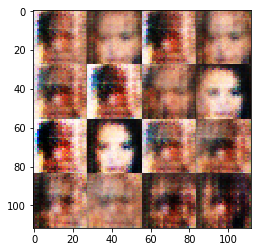

Epoch 1/1...Batch 610 Discriminator Loss: 1.2232... Generator Loss: 0.8041
Epoch 1/1...Batch 620 Discriminator Loss: 1.3199... Generator Loss: 0.7607
Epoch 1/1...Batch 630 Discriminator Loss: 1.4400... Generator Loss: 0.5301
Epoch 1/1...Batch 640 Discriminator Loss: 2.0385... Generator Loss: 1.6352
Epoch 1/1...Batch 650 Discriminator Loss: 1.3753... Generator Loss: 0.8456
Epoch 1/1...Batch 660 Discriminator Loss: 1.3452... Generator Loss: 0.7118
Epoch 1/1...Batch 670 Discriminator Loss: 1.3686... Generator Loss: 0.7240
Epoch 1/1...Batch 680 Discriminator Loss: 1.2603... Generator Loss: 0.7894
Epoch 1/1...Batch 690 Discriminator Loss: 1.8170... Generator Loss: 0.3050
Epoch 1/1...Batch 700 Discriminator Loss: 1.3666... Generator Loss: 0.9546


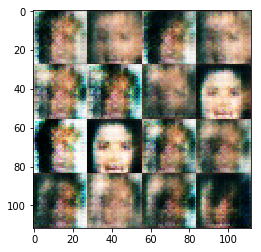

Epoch 1/1...Batch 710 Discriminator Loss: 1.4077... Generator Loss: 0.8702
Epoch 1/1...Batch 720 Discriminator Loss: 1.1642... Generator Loss: 1.0633
Epoch 1/1...Batch 730 Discriminator Loss: 1.8970... Generator Loss: 0.2652
Epoch 1/1...Batch 740 Discriminator Loss: 1.3291... Generator Loss: 0.7967
Epoch 1/1...Batch 750 Discriminator Loss: 1.3011... Generator Loss: 0.7980
Epoch 1/1...Batch 760 Discriminator Loss: 1.4476... Generator Loss: 0.8306
Epoch 1/1...Batch 770 Discriminator Loss: 1.2822... Generator Loss: 0.8423
Epoch 1/1...Batch 780 Discriminator Loss: 1.3106... Generator Loss: 0.6441
Epoch 1/1...Batch 790 Discriminator Loss: 1.3498... Generator Loss: 1.1292
Epoch 1/1...Batch 800 Discriminator Loss: 1.3094... Generator Loss: 0.6891


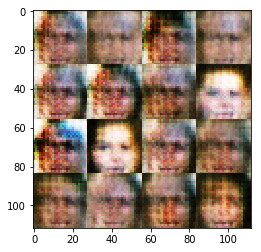

Epoch 1/1...Batch 810 Discriminator Loss: 1.2689... Generator Loss: 0.9651
Epoch 1/1...Batch 820 Discriminator Loss: 1.0959... Generator Loss: 0.8691
Epoch 1/1...Batch 830 Discriminator Loss: 1.5177... Generator Loss: 0.7904
Epoch 1/1...Batch 840 Discriminator Loss: 1.5525... Generator Loss: 0.5308
Epoch 1/1...Batch 850 Discriminator Loss: 1.4325... Generator Loss: 0.7773
Epoch 1/1...Batch 860 Discriminator Loss: 1.0876... Generator Loss: 0.9534
Epoch 1/1...Batch 870 Discriminator Loss: 1.3253... Generator Loss: 0.6399
Epoch 1/1...Batch 880 Discriminator Loss: 1.2718... Generator Loss: 1.5122
Epoch 1/1...Batch 890 Discriminator Loss: 1.2331... Generator Loss: 0.8761
Epoch 1/1...Batch 900 Discriminator Loss: 1.1854... Generator Loss: 0.9189


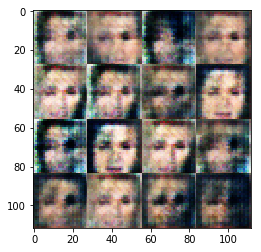

Epoch 1/1...Batch 910 Discriminator Loss: 1.3243... Generator Loss: 0.5925
Epoch 1/1...Batch 920 Discriminator Loss: 1.3380... Generator Loss: 1.4512
Epoch 1/1...Batch 930 Discriminator Loss: 1.1704... Generator Loss: 0.8814
Epoch 1/1...Batch 940 Discriminator Loss: 1.2833... Generator Loss: 0.9950
Epoch 1/1...Batch 950 Discriminator Loss: 1.3403... Generator Loss: 0.8868
Epoch 1/1...Batch 960 Discriminator Loss: 1.2662... Generator Loss: 0.6452
Epoch 1/1...Batch 970 Discriminator Loss: 1.4146... Generator Loss: 0.8262
Epoch 1/1...Batch 980 Discriminator Loss: 1.0937... Generator Loss: 0.7519
Epoch 1/1...Batch 990 Discriminator Loss: 1.2589... Generator Loss: 0.5720
Epoch 1/1...Batch 1000 Discriminator Loss: 1.2448... Generator Loss: 0.9930


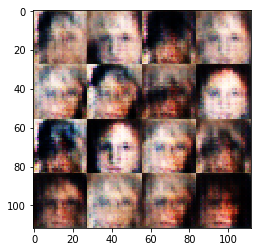

Epoch 1/1...Batch 1010 Discriminator Loss: 1.5504... Generator Loss: 0.7607
Epoch 1/1...Batch 1020 Discriminator Loss: 1.3517... Generator Loss: 0.9345
Epoch 1/1...Batch 1030 Discriminator Loss: 1.4075... Generator Loss: 0.9992
Epoch 1/1...Batch 1040 Discriminator Loss: 1.2494... Generator Loss: 0.6872
Epoch 1/1...Batch 1050 Discriminator Loss: 1.3674... Generator Loss: 1.1168
Epoch 1/1...Batch 1060 Discriminator Loss: 1.1713... Generator Loss: 0.8859
Epoch 1/1...Batch 1070 Discriminator Loss: 1.7351... Generator Loss: 0.3547
Epoch 1/1...Batch 1080 Discriminator Loss: 1.3699... Generator Loss: 1.1067
Epoch 1/1...Batch 1090 Discriminator Loss: 1.5211... Generator Loss: 0.6963
Epoch 1/1...Batch 1100 Discriminator Loss: 1.1661... Generator Loss: 0.7337


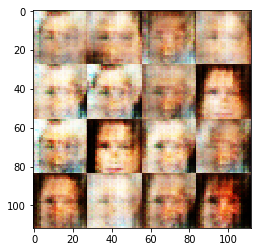

Epoch 1/1...Batch 1110 Discriminator Loss: 1.3983... Generator Loss: 0.6483
Epoch 1/1...Batch 1120 Discriminator Loss: 1.1398... Generator Loss: 1.0261
Epoch 1/1...Batch 1130 Discriminator Loss: 1.2364... Generator Loss: 0.9500
Epoch 1/1...Batch 1140 Discriminator Loss: 1.0895... Generator Loss: 1.1881
Epoch 1/1...Batch 1150 Discriminator Loss: 1.3237... Generator Loss: 0.7090
Epoch 1/1...Batch 1160 Discriminator Loss: 1.3877... Generator Loss: 1.3354
Epoch 1/1...Batch 1170 Discriminator Loss: 1.1666... Generator Loss: 1.0404
Epoch 1/1...Batch 1180 Discriminator Loss: 1.1198... Generator Loss: 1.0331
Epoch 1/1...Batch 1190 Discriminator Loss: 1.4366... Generator Loss: 0.7054
Epoch 1/1...Batch 1200 Discriminator Loss: 1.2874... Generator Loss: 0.8373


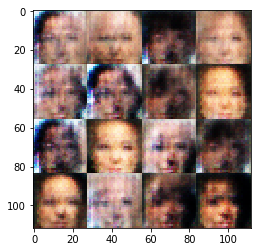

Epoch 1/1...Batch 1210 Discriminator Loss: 1.5415... Generator Loss: 0.3945
Epoch 1/1...Batch 1220 Discriminator Loss: 1.4590... Generator Loss: 0.6735
Epoch 1/1...Batch 1230 Discriminator Loss: 1.3365... Generator Loss: 0.7949
Epoch 1/1...Batch 1240 Discriminator Loss: 1.3416... Generator Loss: 0.5831
Epoch 1/1...Batch 1250 Discriminator Loss: 1.7747... Generator Loss: 0.3399
Epoch 1/1...Batch 1260 Discriminator Loss: 1.1354... Generator Loss: 0.7751
Epoch 1/1...Batch 1270 Discriminator Loss: 1.6368... Generator Loss: 0.4078
Epoch 1/1...Batch 1280 Discriminator Loss: 1.3869... Generator Loss: 0.6166
Epoch 1/1...Batch 1290 Discriminator Loss: 1.2367... Generator Loss: 0.8963
Epoch 1/1...Batch 1300 Discriminator Loss: 1.1988... Generator Loss: 0.7640


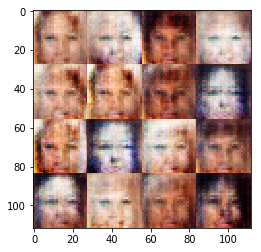

Epoch 1/1...Batch 1310 Discriminator Loss: 1.3809... Generator Loss: 0.7110
Epoch 1/1...Batch 1320 Discriminator Loss: 1.4387... Generator Loss: 0.6367
Epoch 1/1...Batch 1330 Discriminator Loss: 1.2989... Generator Loss: 1.0280
Epoch 1/1...Batch 1340 Discriminator Loss: 1.2032... Generator Loss: 1.1101
Epoch 1/1...Batch 1350 Discriminator Loss: 1.4660... Generator Loss: 0.5248
Epoch 1/1...Batch 1360 Discriminator Loss: 1.4239... Generator Loss: 0.8437
Epoch 1/1...Batch 1370 Discriminator Loss: 1.4791... Generator Loss: 0.8012
Epoch 1/1...Batch 1380 Discriminator Loss: 1.5710... Generator Loss: 0.5091
Epoch 1/1...Batch 1390 Discriminator Loss: 1.2297... Generator Loss: 0.6124
Epoch 1/1...Batch 1400 Discriminator Loss: 1.1993... Generator Loss: 0.7173


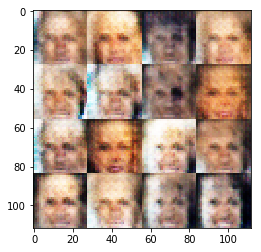

Epoch 1/1...Batch 1410 Discriminator Loss: 1.0078... Generator Loss: 1.6271
Epoch 1/1...Batch 1420 Discriminator Loss: 1.2250... Generator Loss: 1.1602
Epoch 1/1...Batch 1430 Discriminator Loss: 1.2192... Generator Loss: 0.6885
Epoch 1/1...Batch 1440 Discriminator Loss: 1.5459... Generator Loss: 0.4347
Epoch 1/1...Batch 1450 Discriminator Loss: 1.1754... Generator Loss: 0.8608
Epoch 1/1...Batch 1460 Discriminator Loss: 1.3920... Generator Loss: 0.5412
Epoch 1/1...Batch 1470 Discriminator Loss: 1.2385... Generator Loss: 0.8963
Epoch 1/1...Batch 1480 Discriminator Loss: 1.2757... Generator Loss: 0.8421
Epoch 1/1...Batch 1490 Discriminator Loss: 1.6390... Generator Loss: 0.6232
Epoch 1/1...Batch 1500 Discriminator Loss: 1.5154... Generator Loss: 0.5219


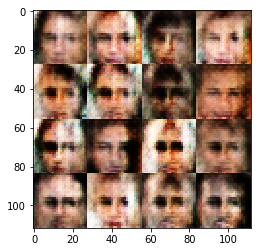

Epoch 1/1...Batch 1510 Discriminator Loss: 1.3329... Generator Loss: 0.7922
Epoch 1/1...Batch 1520 Discriminator Loss: 1.2896... Generator Loss: 0.6716
Epoch 1/1...Batch 1530 Discriminator Loss: 1.4431... Generator Loss: 0.7328
Epoch 1/1...Batch 1540 Discriminator Loss: 1.3903... Generator Loss: 0.7887
Epoch 1/1...Batch 1550 Discriminator Loss: 1.4157... Generator Loss: 0.6699
Epoch 1/1...Batch 1560 Discriminator Loss: 1.4696... Generator Loss: 0.8770
Epoch 1/1...Batch 1570 Discriminator Loss: 1.2805... Generator Loss: 0.9491
Epoch 1/1...Batch 1580 Discriminator Loss: 1.3442... Generator Loss: 0.6986
Epoch 1/1...Batch 1590 Discriminator Loss: 1.1589... Generator Loss: 1.0456
Epoch 1/1...Batch 1600 Discriminator Loss: 1.4126... Generator Loss: 0.7155


Epoch 1/1...Batch 1610 Discriminator Loss: 1.3799... Generator Loss: 0.6887
Epoch 1/1...Batch 1620 Discriminator Loss: 1.1876... Generator Loss: 0.8378
Epoch 1/1...Batch 1630 Discriminator Loss: 1.2909... Generator Loss: 1.1786
Epoch 1/1...Batch 1640 Discriminator Loss: 1.2548... Generator Loss: 1.1024
Epoch 1/1...Batch 1650 Discriminator Loss: 1.1738... Generator Loss: 1.0195
Epoch 1/1...Batch 1660 Discriminator Loss: 1.1311... Generator Loss: 0.9569
Epoch 1/1...Batch 1670 Discriminator Loss: 1.2854... Generator Loss: 1.1504
Epoch 1/1...Batch 1680 Discriminator Loss: 1.2367... Generator Loss: 0.8382
Epoch 1/1...Batch 1690 Discriminator Loss: 1.5898... Generator Loss: 0.3914
Epoch 1/1...Batch 1700 Discriminator Loss: 1.4777... Generator Loss: 0.5839


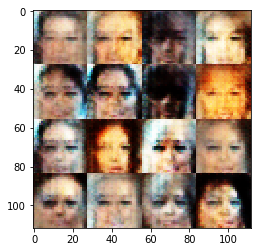

Epoch 1/1...Batch 1710 Discriminator Loss: 1.1399... Generator Loss: 0.8225
Epoch 1/1...Batch 1720 Discriminator Loss: 1.2422... Generator Loss: 1.1932
Epoch 1/1...Batch 1730 Discriminator Loss: 1.5410... Generator Loss: 0.6215
Epoch 1/1...Batch 1740 Discriminator Loss: 1.4260... Generator Loss: 0.5792
Epoch 1/1...Batch 1750 Discriminator Loss: 1.3226... Generator Loss: 0.8671
Epoch 1/1...Batch 1760 Discriminator Loss: 1.3286... Generator Loss: 0.7783
Epoch 1/1...Batch 1770 Discriminator Loss: 1.4301... Generator Loss: 0.5193
Epoch 1/1...Batch 1780 Discriminator Loss: 1.3088... Generator Loss: 0.9894
Epoch 1/1...Batch 1790 Discriminator Loss: 1.3279... Generator Loss: 0.6259
Epoch 1/1...Batch 1800 Discriminator Loss: 1.4395... Generator Loss: 0.5332


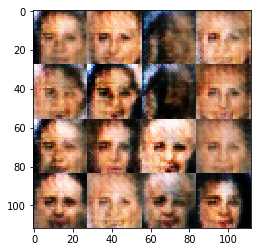

Epoch 1/1...Batch 1810 Discriminator Loss: 1.2541... Generator Loss: 0.6752
Epoch 1/1...Batch 1820 Discriminator Loss: 1.2469... Generator Loss: 0.9645
Epoch 1/1...Batch 1830 Discriminator Loss: 1.2629... Generator Loss: 0.6287
Epoch 1/1...Batch 1840 Discriminator Loss: 1.3176... Generator Loss: 0.7843
Epoch 1/1...Batch 1850 Discriminator Loss: 1.2591... Generator Loss: 0.6502
Epoch 1/1...Batch 1860 Discriminator Loss: 1.2030... Generator Loss: 0.9818
Epoch 1/1...Batch 1870 Discriminator Loss: 1.3298... Generator Loss: 0.6242
Epoch 1/1...Batch 1880 Discriminator Loss: 1.3083... Generator Loss: 0.7321
Epoch 1/1...Batch 1890 Discriminator Loss: 1.0531... Generator Loss: 1.2692
Epoch 1/1...Batch 1900 Discriminator Loss: 1.3902... Generator Loss: 0.5966


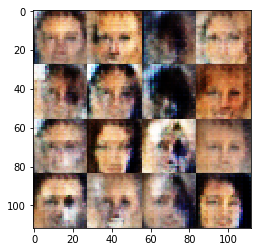

Epoch 1/1...Batch 1910 Discriminator Loss: 1.3671... Generator Loss: 0.7028
Epoch 1/1...Batch 1920 Discriminator Loss: 1.2577... Generator Loss: 0.8233
Epoch 1/1...Batch 1930 Discriminator Loss: 1.1548... Generator Loss: 1.0150
Epoch 1/1...Batch 1940 Discriminator Loss: 1.3973... Generator Loss: 0.8293
Epoch 1/1...Batch 1950 Discriminator Loss: 1.3937... Generator Loss: 1.4034
Epoch 1/1...Batch 1960 Discriminator Loss: 1.2098... Generator Loss: 0.8436
Epoch 1/1...Batch 1970 Discriminator Loss: 1.3507... Generator Loss: 0.7358
Epoch 1/1...Batch 1980 Discriminator Loss: 1.3778... Generator Loss: 0.7653
Epoch 1/1...Batch 1990 Discriminator Loss: 1.2833... Generator Loss: 0.7025
Epoch 1/1...Batch 2000 Discriminator Loss: 1.3675... Generator Loss: 1.8692


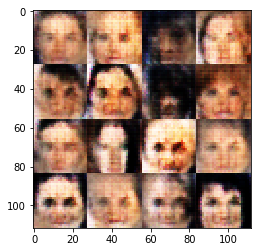

Epoch 1/1...Batch 2010 Discriminator Loss: 1.2773... Generator Loss: 0.6959
Epoch 1/1...Batch 2020 Discriminator Loss: 1.2879... Generator Loss: 0.7221
Epoch 1/1...Batch 2030 Discriminator Loss: 1.1690... Generator Loss: 0.7748
Epoch 1/1...Batch 2040 Discriminator Loss: 1.4144... Generator Loss: 0.6160
Epoch 1/1...Batch 2050 Discriminator Loss: 1.4421... Generator Loss: 0.4999
Epoch 1/1...Batch 2060 Discriminator Loss: 1.3905... Generator Loss: 0.4881
Epoch 1/1...Batch 2070 Discriminator Loss: 1.0549... Generator Loss: 0.7977
Epoch 1/1...Batch 2080 Discriminator Loss: 1.3819... Generator Loss: 0.6780
Epoch 1/1...Batch 2090 Discriminator Loss: 1.2530... Generator Loss: 0.7878
Epoch 1/1...Batch 2100 Discriminator Loss: 1.3451... Generator Loss: 0.8125


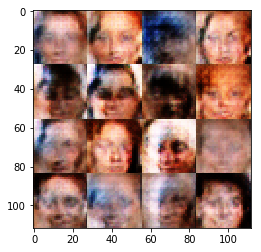

Epoch 1/1...Batch 2110 Discriminator Loss: 1.3052... Generator Loss: 1.2304
Epoch 1/1...Batch 2120 Discriminator Loss: 1.2520... Generator Loss: 1.0175
Epoch 1/1...Batch 2130 Discriminator Loss: 1.4813... Generator Loss: 0.5113
Epoch 1/1...Batch 2140 Discriminator Loss: 1.2451... Generator Loss: 0.8575
Epoch 1/1...Batch 2150 Discriminator Loss: 1.4538... Generator Loss: 0.5464
Epoch 1/1...Batch 2160 Discriminator Loss: 1.3588... Generator Loss: 0.5833
Epoch 1/1...Batch 2170 Discriminator Loss: 1.4418... Generator Loss: 1.7510
Epoch 1/1...Batch 2180 Discriminator Loss: 1.3210... Generator Loss: 0.6198
Epoch 1/1...Batch 2190 Discriminator Loss: 1.3536... Generator Loss: 0.7614
Epoch 1/1...Batch 2200 Discriminator Loss: 1.2951... Generator Loss: 0.8395


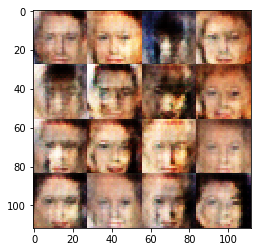

Epoch 1/1...Batch 2210 Discriminator Loss: 1.5532... Generator Loss: 0.5238
Epoch 1/1...Batch 2220 Discriminator Loss: 1.4617... Generator Loss: 1.8927
Epoch 1/1...Batch 2230 Discriminator Loss: 1.2010... Generator Loss: 1.1499
Epoch 1/1...Batch 2240 Discriminator Loss: 1.2146... Generator Loss: 1.0649
Epoch 1/1...Batch 2250 Discriminator Loss: 1.2581... Generator Loss: 0.6103
Epoch 1/1...Batch 2260 Discriminator Loss: 1.3442... Generator Loss: 0.6512
Epoch 1/1...Batch 2270 Discriminator Loss: 1.3105... Generator Loss: 0.7260
Epoch 1/1...Batch 2280 Discriminator Loss: 1.5149... Generator Loss: 0.4414
Epoch 1/1...Batch 2290 Discriminator Loss: 1.3718... Generator Loss: 0.5642
Epoch 1/1...Batch 2300 Discriminator Loss: 1.3715... Generator Loss: 0.9017


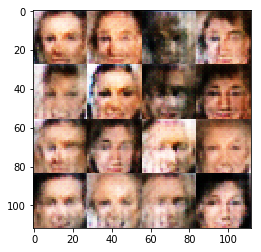

Epoch 1/1...Batch 2310 Discriminator Loss: 1.2051... Generator Loss: 1.1151
Epoch 1/1...Batch 2320 Discriminator Loss: 1.2873... Generator Loss: 0.7309
Epoch 1/1...Batch 2330 Discriminator Loss: 1.4428... Generator Loss: 0.4724
Epoch 1/1...Batch 2340 Discriminator Loss: 1.1311... Generator Loss: 0.8606
Epoch 1/1...Batch 2350 Discriminator Loss: 1.3137... Generator Loss: 0.9355
Epoch 1/1...Batch 2360 Discriminator Loss: 1.2327... Generator Loss: 0.9781
Epoch 1/1...Batch 2370 Discriminator Loss: 1.0780... Generator Loss: 1.4895
Epoch 1/1...Batch 2380 Discriminator Loss: 1.2574... Generator Loss: 0.7821
Epoch 1/1...Batch 2390 Discriminator Loss: 1.2360... Generator Loss: 0.7813
Epoch 1/1...Batch 2400 Discriminator Loss: 1.2473... Generator Loss: 0.9196


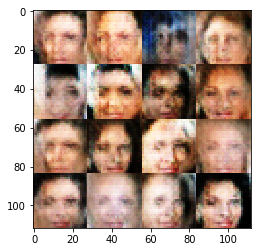

Epoch 1/1...Batch 2410 Discriminator Loss: 1.2747... Generator Loss: 0.8624
Epoch 1/1...Batch 2420 Discriminator Loss: 1.4549... Generator Loss: 1.1795
Epoch 1/1...Batch 2430 Discriminator Loss: 1.1420... Generator Loss: 0.8605
Epoch 1/1...Batch 2440 Discriminator Loss: 1.3315... Generator Loss: 0.7485
Epoch 1/1...Batch 2450 Discriminator Loss: 1.2794... Generator Loss: 0.6661
Epoch 1/1...Batch 2460 Discriminator Loss: 1.2196... Generator Loss: 0.8286
Epoch 1/1...Batch 2470 Discriminator Loss: 1.4206... Generator Loss: 0.5156
Epoch 1/1...Batch 2480 Discriminator Loss: 1.3844... Generator Loss: 0.5226
Epoch 1/1...Batch 2490 Discriminator Loss: 1.3424... Generator Loss: 0.8031
Epoch 1/1...Batch 2500 Discriminator Loss: 1.4952... Generator Loss: 0.7185


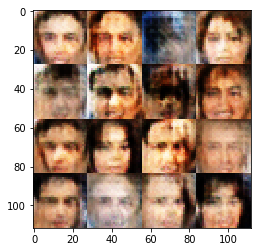

Epoch 1/1...Batch 2510 Discriminator Loss: 1.2178... Generator Loss: 0.8181
Epoch 1/1...Batch 2520 Discriminator Loss: 1.2673... Generator Loss: 1.0754
Epoch 1/1...Batch 2530 Discriminator Loss: 1.5408... Generator Loss: 0.4442
Epoch 1/1...Batch 2540 Discriminator Loss: 1.4007... Generator Loss: 0.6357
Epoch 1/1...Batch 2550 Discriminator Loss: 1.2513... Generator Loss: 0.9258
Epoch 1/1...Batch 2560 Discriminator Loss: 1.2653... Generator Loss: 0.8832
Epoch 1/1...Batch 2570 Discriminator Loss: 1.4512... Generator Loss: 0.4583
Epoch 1/1...Batch 2580 Discriminator Loss: 1.3314... Generator Loss: 1.5897
Epoch 1/1...Batch 2590 Discriminator Loss: 1.2547... Generator Loss: 1.1050
Epoch 1/1...Batch 2600 Discriminator Loss: 1.2936... Generator Loss: 0.8152


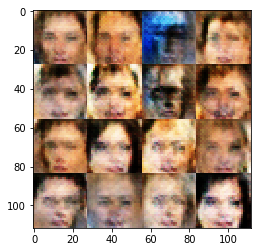

Epoch 1/1...Batch 2610 Discriminator Loss: 1.3081... Generator Loss: 0.5773
Epoch 1/1...Batch 2620 Discriminator Loss: 1.5532... Generator Loss: 0.4080
Epoch 1/1...Batch 2630 Discriminator Loss: 1.3305... Generator Loss: 1.3785
Epoch 1/1...Batch 2640 Discriminator Loss: 1.0424... Generator Loss: 1.1616
Epoch 1/1...Batch 2650 Discriminator Loss: 1.4022... Generator Loss: 0.7036
Epoch 1/1...Batch 2660 Discriminator Loss: 1.3807... Generator Loss: 0.6406
Epoch 1/1...Batch 2670 Discriminator Loss: 1.2108... Generator Loss: 1.0585
Epoch 1/1...Batch 2680 Discriminator Loss: 1.1990... Generator Loss: 1.2537
Epoch 1/1...Batch 2690 Discriminator Loss: 1.1856... Generator Loss: 1.2198
Epoch 1/1...Batch 2700 Discriminator Loss: 1.1885... Generator Loss: 0.9727


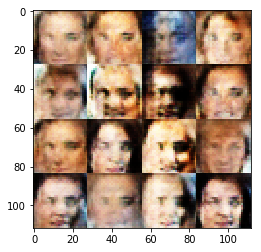

Epoch 1/1...Batch 2710 Discriminator Loss: 1.3605... Generator Loss: 0.5688
Epoch 1/1...Batch 2720 Discriminator Loss: 1.4367... Generator Loss: 0.5935
Epoch 1/1...Batch 2730 Discriminator Loss: 1.2427... Generator Loss: 0.9263
Epoch 1/1...Batch 2740 Discriminator Loss: 1.3112... Generator Loss: 1.4808
Epoch 1/1...Batch 2750 Discriminator Loss: 1.3076... Generator Loss: 0.6538
Epoch 1/1...Batch 2760 Discriminator Loss: 1.3119... Generator Loss: 0.5934
Epoch 1/1...Batch 2770 Discriminator Loss: 1.2366... Generator Loss: 0.9462
Epoch 1/1...Batch 2780 Discriminator Loss: 1.2653... Generator Loss: 0.6946
Epoch 1/1...Batch 2790 Discriminator Loss: 1.3127... Generator Loss: 0.8090
Epoch 1/1...Batch 2800 Discriminator Loss: 1.1730... Generator Loss: 0.9882


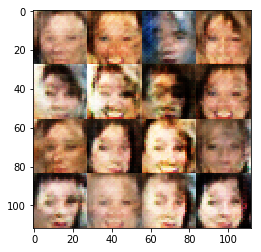

Epoch 1/1...Batch 2810 Discriminator Loss: 1.3321... Generator Loss: 0.6058
Epoch 1/1...Batch 2820 Discriminator Loss: 1.2490... Generator Loss: 0.7416
Epoch 1/1...Batch 2830 Discriminator Loss: 1.2034... Generator Loss: 1.0753
Epoch 1/1...Batch 2840 Discriminator Loss: 1.4256... Generator Loss: 0.4854
Epoch 1/1...Batch 2850 Discriminator Loss: 1.1740... Generator Loss: 1.0918
Epoch 1/1...Batch 2860 Discriminator Loss: 1.4481... Generator Loss: 0.5274
Epoch 1/1...Batch 2870 Discriminator Loss: 1.2779... Generator Loss: 0.7144
Epoch 1/1...Batch 2880 Discriminator Loss: 1.5047... Generator Loss: 0.4604
Epoch 1/1...Batch 2890 Discriminator Loss: 1.4956... Generator Loss: 0.5028
Epoch 1/1...Batch 2900 Discriminator Loss: 1.3541... Generator Loss: 0.8119


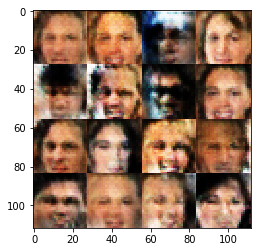

Epoch 1/1...Batch 2910 Discriminator Loss: 1.0637... Generator Loss: 0.8699
Epoch 1/1...Batch 2920 Discriminator Loss: 1.3196... Generator Loss: 0.7170
Epoch 1/1...Batch 2930 Discriminator Loss: 1.2342... Generator Loss: 0.9385
Epoch 1/1...Batch 2940 Discriminator Loss: 1.4304... Generator Loss: 0.4953
Epoch 1/1...Batch 2950 Discriminator Loss: 1.4180... Generator Loss: 0.6667
Epoch 1/1...Batch 2960 Discriminator Loss: 1.3222... Generator Loss: 0.5680
Epoch 1/1...Batch 2970 Discriminator Loss: 1.3510... Generator Loss: 1.1867
Epoch 1/1...Batch 2980 Discriminator Loss: 1.5586... Generator Loss: 0.4837
Epoch 1/1...Batch 2990 Discriminator Loss: 1.2285... Generator Loss: 0.9069
Epoch 1/1...Batch 3000 Discriminator Loss: 1.1722... Generator Loss: 1.0637


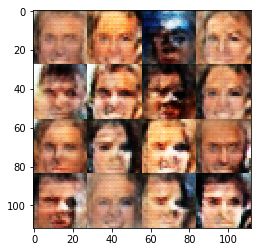

Epoch 1/1...Batch 3010 Discriminator Loss: 1.2098... Generator Loss: 1.1760
Epoch 1/1...Batch 3020 Discriminator Loss: 1.1947... Generator Loss: 1.0083
Epoch 1/1...Batch 3030 Discriminator Loss: 1.1685... Generator Loss: 1.1778
Epoch 1/1...Batch 3040 Discriminator Loss: 1.3737... Generator Loss: 0.5057
Epoch 1/1...Batch 3050 Discriminator Loss: 1.3407... Generator Loss: 0.6986
Epoch 1/1...Batch 3060 Discriminator Loss: 1.4146... Generator Loss: 0.5096
Epoch 1/1...Batch 3070 Discriminator Loss: 1.1962... Generator Loss: 0.8694
Epoch 1/1...Batch 3080 Discriminator Loss: 1.4055... Generator Loss: 0.6589
Epoch 1/1...Batch 3090 Discriminator Loss: 1.1134... Generator Loss: 1.1488
Epoch 1/1...Batch 3100 Discriminator Loss: 1.2890... Generator Loss: 1.1727


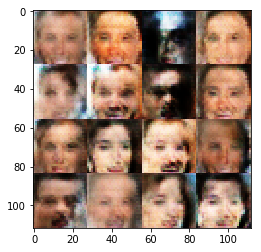

Epoch 1/1...Batch 3110 Discriminator Loss: 0.9345... Generator Loss: 1.0895
Epoch 1/1...Batch 3120 Discriminator Loss: 1.2850... Generator Loss: 0.6938
Epoch 1/1...Batch 3130 Discriminator Loss: 1.3049... Generator Loss: 1.0098
Epoch 1/1...Batch 3140 Discriminator Loss: 1.5123... Generator Loss: 0.4210
Epoch 1/1...Batch 3150 Discriminator Loss: 1.2731... Generator Loss: 0.7974
Epoch 1/1...Batch 3160 Discriminator Loss: 1.5126... Generator Loss: 1.3547
Epoch 1/1...Batch 3170 Discriminator Loss: 1.4159... Generator Loss: 0.5690
Epoch 1/1...Batch 3180 Discriminator Loss: 1.0183... Generator Loss: 1.1841
Epoch 1/1...Batch 3190 Discriminator Loss: 1.4720... Generator Loss: 0.4969
Epoch 1/1...Batch 3200 Discriminator Loss: 1.3068... Generator Loss: 0.7133


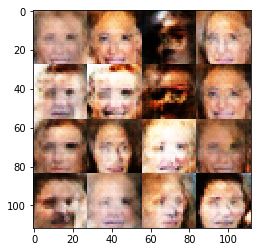

Epoch 1/1...Batch 3210 Discriminator Loss: 1.0587... Generator Loss: 1.1090
Epoch 1/1...Batch 3220 Discriminator Loss: 1.1296... Generator Loss: 0.8654
Epoch 1/1...Batch 3230 Discriminator Loss: 1.2622... Generator Loss: 1.0173
Epoch 1/1...Batch 3240 Discriminator Loss: 1.2047... Generator Loss: 0.6757
Epoch 1/1...Batch 3250 Discriminator Loss: 1.2690... Generator Loss: 0.7477
Epoch 1/1...Batch 3260 Discriminator Loss: 1.2394... Generator Loss: 1.0916
Epoch 1/1...Batch 3270 Discriminator Loss: 1.1760... Generator Loss: 0.8146
Epoch 1/1...Batch 3280 Discriminator Loss: 1.2563... Generator Loss: 1.6737
Epoch 1/1...Batch 3290 Discriminator Loss: 1.2386... Generator Loss: 0.6687
Epoch 1/1...Batch 3300 Discriminator Loss: 1.2804... Generator Loss: 0.6459


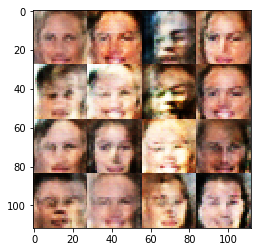

Epoch 1/1...Batch 3310 Discriminator Loss: 1.3843... Generator Loss: 0.5822
Epoch 1/1...Batch 3320 Discriminator Loss: 1.3893... Generator Loss: 0.5418
Epoch 1/1...Batch 3330 Discriminator Loss: 1.3186... Generator Loss: 0.8843
Epoch 1/1...Batch 3340 Discriminator Loss: 1.3476... Generator Loss: 1.8971
Epoch 1/1...Batch 3350 Discriminator Loss: 1.2475... Generator Loss: 0.8444
Epoch 1/1...Batch 3360 Discriminator Loss: 1.2341... Generator Loss: 1.3557
Epoch 1/1...Batch 3370 Discriminator Loss: 1.2894... Generator Loss: 0.9606
Epoch 1/1...Batch 3380 Discriminator Loss: 1.2933... Generator Loss: 0.6117
Epoch 1/1...Batch 3390 Discriminator Loss: 1.5235... Generator Loss: 0.4343
Epoch 1/1...Batch 3400 Discriminator Loss: 1.4008... Generator Loss: 0.5194


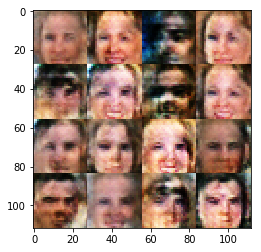

Epoch 1/1...Batch 3410 Discriminator Loss: 1.0805... Generator Loss: 1.0836
Epoch 1/1...Batch 3420 Discriminator Loss: 1.3095... Generator Loss: 0.6464
Epoch 1/1...Batch 3430 Discriminator Loss: 1.3673... Generator Loss: 0.8709
Epoch 1/1...Batch 3440 Discriminator Loss: 1.2687... Generator Loss: 1.0331
Epoch 1/1...Batch 3450 Discriminator Loss: 1.5941... Generator Loss: 0.4061
Epoch 1/1...Batch 3460 Discriminator Loss: 1.2234... Generator Loss: 0.7118
Epoch 1/1...Batch 3470 Discriminator Loss: 1.2316... Generator Loss: 0.8758
Epoch 1/1...Batch 3480 Discriminator Loss: 1.4164... Generator Loss: 1.0631
Epoch 1/1...Batch 3490 Discriminator Loss: 1.2391... Generator Loss: 0.7778
Epoch 1/1...Batch 3500 Discriminator Loss: 1.4077... Generator Loss: 0.8304


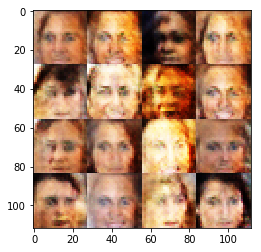

Epoch 1/1...Batch 3510 Discriminator Loss: 1.1442... Generator Loss: 1.2751
Epoch 1/1...Batch 3520 Discriminator Loss: 1.3542... Generator Loss: 0.6200
Epoch 1/1...Batch 3530 Discriminator Loss: 1.4095... Generator Loss: 0.5474
Epoch 1/1...Batch 3540 Discriminator Loss: 1.0637... Generator Loss: 0.8313
Epoch 1/1...Batch 3550 Discriminator Loss: 1.2410... Generator Loss: 0.6580
Epoch 1/1...Batch 3560 Discriminator Loss: 1.3115... Generator Loss: 0.5347
Epoch 1/1...Batch 3570 Discriminator Loss: 1.1862... Generator Loss: 1.4548
Epoch 1/1...Batch 3580 Discriminator Loss: 0.9549... Generator Loss: 1.2708
Epoch 1/1...Batch 3590 Discriminator Loss: 1.4090... Generator Loss: 0.5404
Epoch 1/1...Batch 3600 Discriminator Loss: 1.0858... Generator Loss: 1.0724


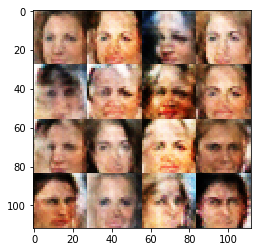

Epoch 1/1...Batch 3610 Discriminator Loss: 1.4289... Generator Loss: 0.5897
Epoch 1/1...Batch 3620 Discriminator Loss: 1.4972... Generator Loss: 0.4645
Epoch 1/1...Batch 3630 Discriminator Loss: 1.5711... Generator Loss: 1.5805
Epoch 1/1...Batch 3640 Discriminator Loss: 1.2665... Generator Loss: 0.7443
Epoch 1/1...Batch 3650 Discriminator Loss: 1.1678... Generator Loss: 1.0042
Epoch 1/1...Batch 3660 Discriminator Loss: 1.4151... Generator Loss: 0.4608
Epoch 1/1...Batch 3670 Discriminator Loss: 1.1833... Generator Loss: 1.0665
Epoch 1/1...Batch 3680 Discriminator Loss: 1.2967... Generator Loss: 0.6465
Epoch 1/1...Batch 3690 Discriminator Loss: 1.4097... Generator Loss: 0.6144
Epoch 1/1...Batch 3700 Discriminator Loss: 1.7044... Generator Loss: 0.3265


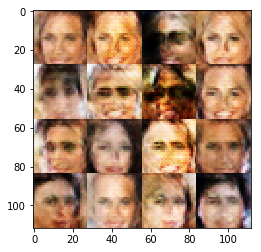

Epoch 1/1...Batch 3710 Discriminator Loss: 1.3698... Generator Loss: 0.4991
Epoch 1/1...Batch 3720 Discriminator Loss: 1.4659... Generator Loss: 0.5503
Epoch 1/1...Batch 3730 Discriminator Loss: 1.0734... Generator Loss: 0.9997
Epoch 1/1...Batch 3740 Discriminator Loss: 1.2487... Generator Loss: 0.6581
Epoch 1/1...Batch 3750 Discriminator Loss: 1.1067... Generator Loss: 0.9470
Epoch 1/1...Batch 3760 Discriminator Loss: 1.2425... Generator Loss: 0.7930
Epoch 1/1...Batch 3770 Discriminator Loss: 1.4027... Generator Loss: 0.6098
Epoch 1/1...Batch 3780 Discriminator Loss: 1.6749... Generator Loss: 0.3487
Epoch 1/1...Batch 3790 Discriminator Loss: 1.3895... Generator Loss: 0.7360
Epoch 1/1...Batch 3800 Discriminator Loss: 1.2153... Generator Loss: 0.7911


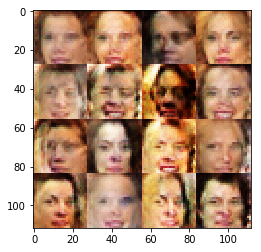

Epoch 1/1...Batch 3810 Discriminator Loss: 1.1843... Generator Loss: 0.6990
Epoch 1/1...Batch 3820 Discriminator Loss: 1.3673... Generator Loss: 0.5096
Epoch 1/1...Batch 3830 Discriminator Loss: 1.3973... Generator Loss: 0.5887
Epoch 1/1...Batch 3840 Discriminator Loss: 1.2823... Generator Loss: 0.6786
Epoch 1/1...Batch 3850 Discriminator Loss: 1.4223... Generator Loss: 0.5482
Epoch 1/1...Batch 3860 Discriminator Loss: 1.1318... Generator Loss: 0.7750
Epoch 1/1...Batch 3870 Discriminator Loss: 1.3652... Generator Loss: 0.7322
Epoch 1/1...Batch 3880 Discriminator Loss: 1.3712... Generator Loss: 0.8138
Epoch 1/1...Batch 3890 Discriminator Loss: 1.4613... Generator Loss: 0.4783
Epoch 1/1...Batch 3900 Discriminator Loss: 1.0773... Generator Loss: 0.8946


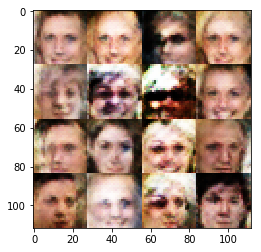

Epoch 1/1...Batch 3910 Discriminator Loss: 1.2589... Generator Loss: 1.3167
Epoch 1/1...Batch 3920 Discriminator Loss: 1.3002... Generator Loss: 0.7298
Epoch 1/1...Batch 3930 Discriminator Loss: 1.2140... Generator Loss: 0.8103
Epoch 1/1...Batch 3940 Discriminator Loss: 1.3409... Generator Loss: 0.6783
Epoch 1/1...Batch 3950 Discriminator Loss: 1.2523... Generator Loss: 0.9334
Epoch 1/1...Batch 3960 Discriminator Loss: 1.4932... Generator Loss: 0.4475
Epoch 1/1...Batch 3970 Discriminator Loss: 1.2295... Generator Loss: 0.8380
Epoch 1/1...Batch 3980 Discriminator Loss: 1.4190... Generator Loss: 0.4585
Epoch 1/1...Batch 3990 Discriminator Loss: 1.1747... Generator Loss: 0.7807
Epoch 1/1...Batch 4000 Discriminator Loss: 1.2195... Generator Loss: 0.6823


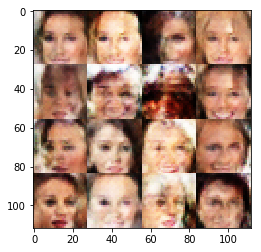

Epoch 1/1...Batch 4010 Discriminator Loss: 1.2779... Generator Loss: 0.8590
Epoch 1/1...Batch 4020 Discriminator Loss: 1.1094... Generator Loss: 1.0690
Epoch 1/1...Batch 4030 Discriminator Loss: 1.1593... Generator Loss: 1.2224
Epoch 1/1...Batch 4040 Discriminator Loss: 1.2011... Generator Loss: 0.9969
Epoch 1/1...Batch 4050 Discriminator Loss: 1.2915... Generator Loss: 0.7287
Epoch 1/1...Batch 4060 Discriminator Loss: 1.2773... Generator Loss: 0.6401
Epoch 1/1...Batch 4070 Discriminator Loss: 1.4431... Generator Loss: 1.8882
Epoch 1/1...Batch 4080 Discriminator Loss: 1.4705... Generator Loss: 0.5578
Epoch 1/1...Batch 4090 Discriminator Loss: 1.5140... Generator Loss: 0.6557
Epoch 1/1...Batch 4100 Discriminator Loss: 1.2468... Generator Loss: 1.3997


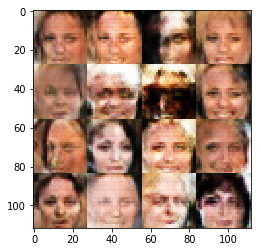

Epoch 1/1...Batch 4110 Discriminator Loss: 1.1611... Generator Loss: 0.8074
Epoch 1/1...Batch 4120 Discriminator Loss: 1.4043... Generator Loss: 0.6752
Epoch 1/1...Batch 4130 Discriminator Loss: 1.1358... Generator Loss: 0.9763
Epoch 1/1...Batch 4140 Discriminator Loss: 1.2491... Generator Loss: 0.8280
Epoch 1/1...Batch 4150 Discriminator Loss: 1.4106... Generator Loss: 0.5193
Epoch 1/1...Batch 4160 Discriminator Loss: 1.3629... Generator Loss: 0.6420
Epoch 1/1...Batch 4170 Discriminator Loss: 1.0254... Generator Loss: 1.1119
Epoch 1/1...Batch 4180 Discriminator Loss: 1.3693... Generator Loss: 0.7132
Epoch 1/1...Batch 4190 Discriminator Loss: 1.1858... Generator Loss: 0.7845
Epoch 1/1...Batch 4200 Discriminator Loss: 1.2909... Generator Loss: 0.6818


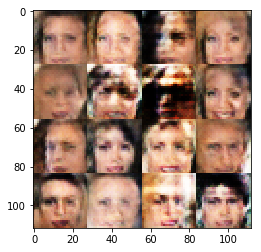

Epoch 1/1...Batch 4210 Discriminator Loss: 1.3054... Generator Loss: 0.8541
Epoch 1/1...Batch 4220 Discriminator Loss: 1.2591... Generator Loss: 0.7684
Epoch 1/1...Batch 4230 Discriminator Loss: 1.1888... Generator Loss: 0.9239
Epoch 1/1...Batch 4240 Discriminator Loss: 1.2040... Generator Loss: 0.7848
Epoch 1/1...Batch 4250 Discriminator Loss: 1.3859... Generator Loss: 0.5422
Epoch 1/1...Batch 4260 Discriminator Loss: 1.2016... Generator Loss: 1.1330
Epoch 1/1...Batch 4270 Discriminator Loss: 1.1670... Generator Loss: 0.9599
Epoch 1/1...Batch 4280 Discriminator Loss: 1.1094... Generator Loss: 0.9826
Epoch 1/1...Batch 4290 Discriminator Loss: 1.4455... Generator Loss: 0.5586
Epoch 1/1...Batch 4300 Discriminator Loss: 1.2538... Generator Loss: 0.8402


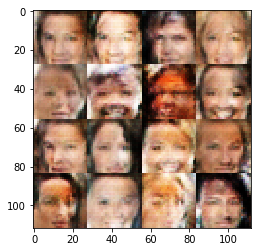

Epoch 1/1...Batch 4310 Discriminator Loss: 1.2617... Generator Loss: 0.9135
Epoch 1/1...Batch 4320 Discriminator Loss: 1.3249... Generator Loss: 0.6795
Epoch 1/1...Batch 4330 Discriminator Loss: 1.1279... Generator Loss: 0.9627
Epoch 1/1...Batch 4340 Discriminator Loss: 1.0859... Generator Loss: 1.2454
Epoch 1/1...Batch 4350 Discriminator Loss: 1.1660... Generator Loss: 1.1497
Epoch 1/1...Batch 4360 Discriminator Loss: 1.3762... Generator Loss: 0.5222
Epoch 1/1...Batch 4370 Discriminator Loss: 1.3681... Generator Loss: 0.5445
Epoch 1/1...Batch 4380 Discriminator Loss: 1.1615... Generator Loss: 1.1132
Epoch 1/1...Batch 4390 Discriminator Loss: 1.5701... Generator Loss: 0.4249
Epoch 1/1...Batch 4400 Discriminator Loss: 1.2590... Generator Loss: 0.7630


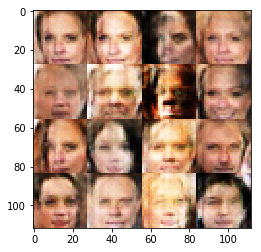

Epoch 1/1...Batch 4410 Discriminator Loss: 1.2468... Generator Loss: 0.6048
Epoch 1/1...Batch 4420 Discriminator Loss: 1.2566... Generator Loss: 1.0207
Epoch 1/1...Batch 4430 Discriminator Loss: 1.2073... Generator Loss: 0.8827
Epoch 1/1...Batch 4440 Discriminator Loss: 1.1761... Generator Loss: 0.9280
Epoch 1/1...Batch 4450 Discriminator Loss: 1.8567... Generator Loss: 0.2904
Epoch 1/1...Batch 4460 Discriminator Loss: 1.1080... Generator Loss: 0.7806
Epoch 1/1...Batch 4470 Discriminator Loss: 1.1997... Generator Loss: 0.8544
Epoch 1/1...Batch 4480 Discriminator Loss: 1.4044... Generator Loss: 0.5218
Epoch 1/1...Batch 4490 Discriminator Loss: 1.2298... Generator Loss: 0.6975
Epoch 1/1...Batch 4500 Discriminator Loss: 1.4298... Generator Loss: 0.5015


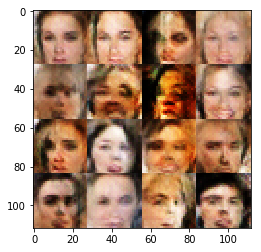

Epoch 1/1...Batch 4510 Discriminator Loss: 1.3832... Generator Loss: 0.5067
Epoch 1/1...Batch 4520 Discriminator Loss: 1.2382... Generator Loss: 0.6838
Epoch 1/1...Batch 4530 Discriminator Loss: 1.4908... Generator Loss: 0.5072
Epoch 1/1...Batch 4540 Discriminator Loss: 1.3291... Generator Loss: 0.5882
Epoch 1/1...Batch 4550 Discriminator Loss: 1.2152... Generator Loss: 0.7482
Epoch 1/1...Batch 4560 Discriminator Loss: 1.0905... Generator Loss: 0.8417
Epoch 1/1...Batch 4570 Discriminator Loss: 1.3362... Generator Loss: 0.6017
Epoch 1/1...Batch 4580 Discriminator Loss: 1.1919... Generator Loss: 0.7303
Epoch 1/1...Batch 4590 Discriminator Loss: 1.1787... Generator Loss: 0.9504
Epoch 1/1...Batch 4600 Discriminator Loss: 1.2485... Generator Loss: 0.9149


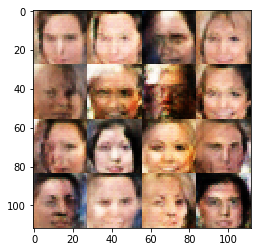

Epoch 1/1...Batch 4610 Discriminator Loss: 1.2905... Generator Loss: 0.5267
Epoch 1/1...Batch 4620 Discriminator Loss: 1.5091... Generator Loss: 0.5241
Epoch 1/1...Batch 4630 Discriminator Loss: 1.3050... Generator Loss: 0.5862
Epoch 1/1...Batch 4640 Discriminator Loss: 1.2590... Generator Loss: 0.7354
Epoch 1/1...Batch 4650 Discriminator Loss: 1.1747... Generator Loss: 0.7232
Epoch 1/1...Batch 4660 Discriminator Loss: 1.5418... Generator Loss: 0.3977
Epoch 1/1...Batch 4670 Discriminator Loss: 1.1043... Generator Loss: 0.8937
Epoch 1/1...Batch 4680 Discriminator Loss: 1.4608... Generator Loss: 0.4797
Epoch 1/1...Batch 4690 Discriminator Loss: 1.2819... Generator Loss: 0.6440
Epoch 1/1...Batch 4700 Discriminator Loss: 1.2192... Generator Loss: 1.1208


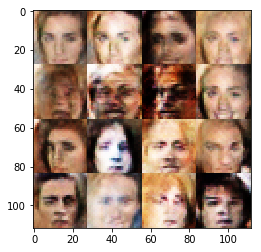

Epoch 1/1...Batch 4710 Discriminator Loss: 1.1996... Generator Loss: 1.1253
Epoch 1/1...Batch 4720 Discriminator Loss: 1.2989... Generator Loss: 0.7188
Epoch 1/1...Batch 4730 Discriminator Loss: 1.1438... Generator Loss: 0.8269
Epoch 1/1...Batch 4740 Discriminator Loss: 1.5202... Generator Loss: 0.4783
Epoch 1/1...Batch 4750 Discriminator Loss: 1.1550... Generator Loss: 0.8688
Epoch 1/1...Batch 4760 Discriminator Loss: 1.1250... Generator Loss: 1.1233
Epoch 1/1...Batch 4770 Discriminator Loss: 1.2394... Generator Loss: 0.7496
Epoch 1/1...Batch 4780 Discriminator Loss: 1.1521... Generator Loss: 0.6897
Epoch 1/1...Batch 4790 Discriminator Loss: 1.1826... Generator Loss: 0.7361
Epoch 1/1...Batch 4800 Discriminator Loss: 1.1637... Generator Loss: 1.0217


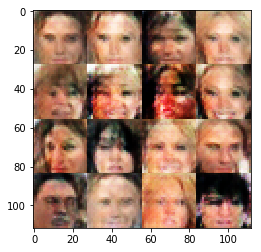

Epoch 1/1...Batch 4810 Discriminator Loss: 1.5584... Generator Loss: 0.4147
Epoch 1/1...Batch 4820 Discriminator Loss: 1.3956... Generator Loss: 0.5431
Epoch 1/1...Batch 4830 Discriminator Loss: 1.2074... Generator Loss: 1.0298
Epoch 1/1...Batch 4840 Discriminator Loss: 1.1059... Generator Loss: 0.9030
Epoch 1/1...Batch 4850 Discriminator Loss: 1.3786... Generator Loss: 0.4934
Epoch 1/1...Batch 4860 Discriminator Loss: 1.2741... Generator Loss: 0.5670
Epoch 1/1...Batch 4870 Discriminator Loss: 1.2639... Generator Loss: 0.7726
Epoch 1/1...Batch 4880 Discriminator Loss: 1.4142... Generator Loss: 0.4958
Epoch 1/1...Batch 4890 Discriminator Loss: 1.0283... Generator Loss: 0.9307
Epoch 1/1...Batch 4900 Discriminator Loss: 1.1510... Generator Loss: 0.7798


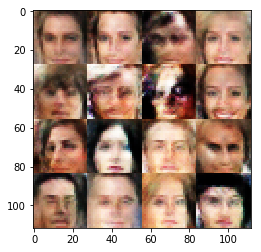

Epoch 1/1...Batch 4910 Discriminator Loss: 1.5029... Generator Loss: 0.4751
Epoch 1/1...Batch 4920 Discriminator Loss: 1.3637... Generator Loss: 0.5778
Epoch 1/1...Batch 4930 Discriminator Loss: 1.1879... Generator Loss: 0.8010
Epoch 1/1...Batch 4940 Discriminator Loss: 1.3225... Generator Loss: 0.5965
Epoch 1/1...Batch 4950 Discriminator Loss: 1.1622... Generator Loss: 1.0811
Epoch 1/1...Batch 4960 Discriminator Loss: 1.3922... Generator Loss: 0.4928
Epoch 1/1...Batch 4970 Discriminator Loss: 1.2195... Generator Loss: 1.2535
Epoch 1/1...Batch 4980 Discriminator Loss: 1.2256... Generator Loss: 0.8849
Epoch 1/1...Batch 4990 Discriminator Loss: 1.0247... Generator Loss: 1.0230
Epoch 1/1...Batch 5000 Discriminator Loss: 1.4177... Generator Loss: 1.7021


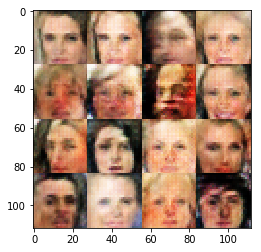

Epoch 1/1...Batch 5010 Discriminator Loss: 1.1685... Generator Loss: 0.8417
Epoch 1/1...Batch 5020 Discriminator Loss: 1.2459... Generator Loss: 0.6400
Epoch 1/1...Batch 5030 Discriminator Loss: 1.6771... Generator Loss: 0.3466
Epoch 1/1...Batch 5040 Discriminator Loss: 1.2729... Generator Loss: 0.7385
Epoch 1/1...Batch 5050 Discriminator Loss: 1.1569... Generator Loss: 0.7364
Epoch 1/1...Batch 5060 Discriminator Loss: 1.1967... Generator Loss: 0.8332
Epoch 1/1...Batch 5070 Discriminator Loss: 1.3365... Generator Loss: 0.5945
Epoch 1/1...Batch 5080 Discriminator Loss: 1.2333... Generator Loss: 0.6674
Epoch 1/1...Batch 5090 Discriminator Loss: 1.0830... Generator Loss: 1.5081
Epoch 1/1...Batch 5100 Discriminator Loss: 1.1124... Generator Loss: 0.9092


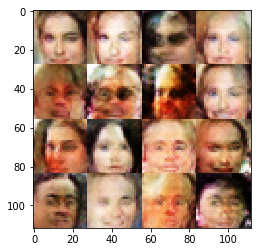

Epoch 1/1...Batch 5110 Discriminator Loss: 1.3625... Generator Loss: 0.5534
Epoch 1/1...Batch 5120 Discriminator Loss: 1.1087... Generator Loss: 0.9731
Epoch 1/1...Batch 5130 Discriminator Loss: 1.1666... Generator Loss: 1.2381
Epoch 1/1...Batch 5140 Discriminator Loss: 1.2118... Generator Loss: 0.7218
Epoch 1/1...Batch 5150 Discriminator Loss: 1.1501... Generator Loss: 0.9054
Epoch 1/1...Batch 5160 Discriminator Loss: 1.2512... Generator Loss: 0.6843
Epoch 1/1...Batch 5170 Discriminator Loss: 1.3839... Generator Loss: 0.5081
Epoch 1/1...Batch 5180 Discriminator Loss: 0.9592... Generator Loss: 1.0532
Epoch 1/1...Batch 5190 Discriminator Loss: 0.8471... Generator Loss: 1.5425
Epoch 1/1...Batch 5200 Discriminator Loss: 1.0209... Generator Loss: 0.8804


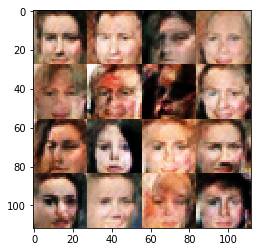

Epoch 1/1...Batch 5210 Discriminator Loss: 1.0268... Generator Loss: 1.1328
Epoch 1/1...Batch 5220 Discriminator Loss: 1.5433... Generator Loss: 0.4170
Epoch 1/1...Batch 5230 Discriminator Loss: 1.0486... Generator Loss: 1.5390
Epoch 1/1...Batch 5240 Discriminator Loss: 1.6680... Generator Loss: 0.3443
Epoch 1/1...Batch 5250 Discriminator Loss: 1.1756... Generator Loss: 1.2201
Epoch 1/1...Batch 5260 Discriminator Loss: 1.1946... Generator Loss: 0.8187
Epoch 1/1...Batch 5270 Discriminator Loss: 1.5338... Generator Loss: 1.4351
Epoch 1/1...Batch 5280 Discriminator Loss: 1.1910... Generator Loss: 0.6885
Epoch 1/1...Batch 5290 Discriminator Loss: 1.2984... Generator Loss: 0.6375
Epoch 1/1...Batch 5300 Discriminator Loss: 1.5579... Generator Loss: 0.4008


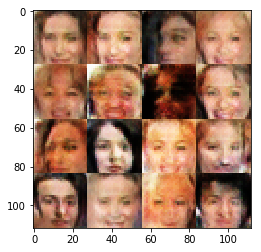

Epoch 1/1...Batch 5310 Discriminator Loss: 1.3730... Generator Loss: 0.5499
Epoch 1/1...Batch 5320 Discriminator Loss: 1.2552... Generator Loss: 0.6961
Epoch 1/1...Batch 5330 Discriminator Loss: 1.2557... Generator Loss: 0.6487
Epoch 1/1...Batch 5340 Discriminator Loss: 1.1236... Generator Loss: 1.1078
Epoch 1/1...Batch 5350 Discriminator Loss: 1.3153... Generator Loss: 0.7319
Epoch 1/1...Batch 5360 Discriminator Loss: 1.1198... Generator Loss: 0.7207
Epoch 1/1...Batch 5370 Discriminator Loss: 1.5690... Generator Loss: 0.3884
Epoch 1/1...Batch 5380 Discriminator Loss: 1.2248... Generator Loss: 1.1238
Epoch 1/1...Batch 5390 Discriminator Loss: 1.0353... Generator Loss: 0.8466
Epoch 1/1...Batch 5400 Discriminator Loss: 1.4472... Generator Loss: 1.6893


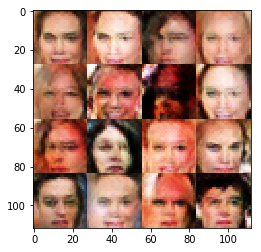

Epoch 1/1...Batch 5410 Discriminator Loss: 1.3233... Generator Loss: 0.7588
Epoch 1/1...Batch 5420 Discriminator Loss: 1.3660... Generator Loss: 0.5041
Epoch 1/1...Batch 5430 Discriminator Loss: 1.2922... Generator Loss: 0.7848
Epoch 1/1...Batch 5440 Discriminator Loss: 1.1369... Generator Loss: 0.7324
Epoch 1/1...Batch 5450 Discriminator Loss: 1.1921... Generator Loss: 1.2379
Epoch 1/1...Batch 5460 Discriminator Loss: 1.3710... Generator Loss: 0.5089
Epoch 1/1...Batch 5470 Discriminator Loss: 1.2486... Generator Loss: 0.6534
Epoch 1/1...Batch 5480 Discriminator Loss: 1.2198... Generator Loss: 0.6918
Epoch 1/1...Batch 5490 Discriminator Loss: 1.3801... Generator Loss: 1.5193
Epoch 1/1...Batch 5500 Discriminator Loss: 1.2501... Generator Loss: 1.2688


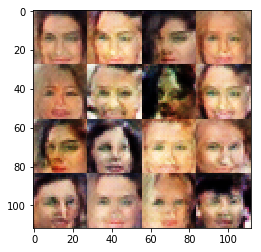

Epoch 1/1...Batch 5510 Discriminator Loss: 1.3323... Generator Loss: 0.5538
Epoch 1/1...Batch 5520 Discriminator Loss: 1.2699... Generator Loss: 0.5953
Epoch 1/1...Batch 5530 Discriminator Loss: 1.2778... Generator Loss: 0.6805
Epoch 1/1...Batch 5540 Discriminator Loss: 1.1353... Generator Loss: 0.7730
Epoch 1/1...Batch 5550 Discriminator Loss: 1.2966... Generator Loss: 1.3825
Epoch 1/1...Batch 5560 Discriminator Loss: 1.3363... Generator Loss: 0.6106
Epoch 1/1...Batch 5570 Discriminator Loss: 1.1693... Generator Loss: 0.6751
Epoch 1/1...Batch 5580 Discriminator Loss: 1.2636... Generator Loss: 0.7138
Epoch 1/1...Batch 5590 Discriminator Loss: 1.0777... Generator Loss: 1.1128
Epoch 1/1...Batch 5600 Discriminator Loss: 1.1730... Generator Loss: 1.2329


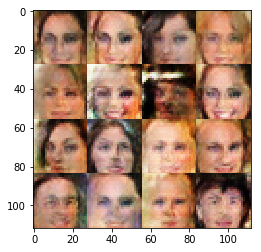

Epoch 1/1...Batch 5610 Discriminator Loss: 1.0949... Generator Loss: 0.9509
Epoch 1/1...Batch 5620 Discriminator Loss: 1.4419... Generator Loss: 0.5033
Epoch 1/1...Batch 5630 Discriminator Loss: 1.4256... Generator Loss: 0.4889
Epoch 1/1...Batch 5640 Discriminator Loss: 1.3143... Generator Loss: 0.5214
Epoch 1/1...Batch 5650 Discriminator Loss: 1.1902... Generator Loss: 0.8385
Epoch 1/1...Batch 5660 Discriminator Loss: 1.4607... Generator Loss: 0.4999
Epoch 1/1...Batch 5670 Discriminator Loss: 1.4453... Generator Loss: 0.5386
Epoch 1/1...Batch 5680 Discriminator Loss: 1.3751... Generator Loss: 0.5082
Epoch 1/1...Batch 5690 Discriminator Loss: 1.3180... Generator Loss: 0.6207
Epoch 1/1...Batch 5700 Discriminator Loss: 1.1209... Generator Loss: 1.0927


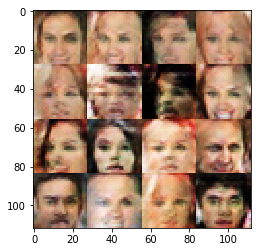

Epoch 1/1...Batch 5710 Discriminator Loss: 1.2656... Generator Loss: 0.6661
Epoch 1/1...Batch 5720 Discriminator Loss: 1.2557... Generator Loss: 0.7174
Epoch 1/1...Batch 5730 Discriminator Loss: 1.2447... Generator Loss: 0.6696
Epoch 1/1...Batch 5740 Discriminator Loss: 1.2392... Generator Loss: 1.0224
Epoch 1/1...Batch 5750 Discriminator Loss: 1.2413... Generator Loss: 0.7925
Epoch 1/1...Batch 5760 Discriminator Loss: 1.1848... Generator Loss: 0.8793
Epoch 1/1...Batch 5770 Discriminator Loss: 1.1753... Generator Loss: 0.7267
Epoch 1/1...Batch 5780 Discriminator Loss: 1.4670... Generator Loss: 0.4388
Epoch 1/1...Batch 5790 Discriminator Loss: 1.2382... Generator Loss: 0.8506
Epoch 1/1...Batch 5800 Discriminator Loss: 1.1303... Generator Loss: 0.7542


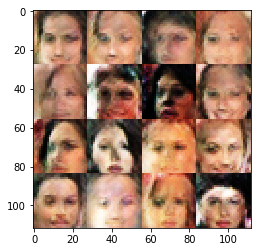

Epoch 1/1...Batch 5810 Discriminator Loss: 1.3274... Generator Loss: 1.1335
Epoch 1/1...Batch 5820 Discriminator Loss: 1.4013... Generator Loss: 0.7729
Epoch 1/1...Batch 5830 Discriminator Loss: 1.1609... Generator Loss: 1.1847
Epoch 1/1...Batch 5840 Discriminator Loss: 1.1814... Generator Loss: 0.6397
Epoch 1/1...Batch 5850 Discriminator Loss: 1.3457... Generator Loss: 0.5971
Epoch 1/1...Batch 5860 Discriminator Loss: 1.0981... Generator Loss: 0.9707
Epoch 1/1...Batch 5870 Discriminator Loss: 1.2816... Generator Loss: 0.6806
Epoch 1/1...Batch 5880 Discriminator Loss: 1.1758... Generator Loss: 0.6851
Epoch 1/1...Batch 5890 Discriminator Loss: 1.0912... Generator Loss: 0.7624
Epoch 1/1...Batch 5900 Discriminator Loss: 1.2329... Generator Loss: 0.7346


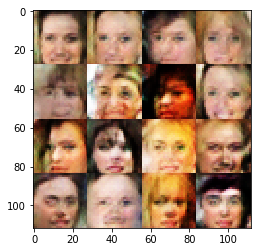

Epoch 1/1...Batch 5910 Discriminator Loss: 1.0826... Generator Loss: 1.0992
Epoch 1/1...Batch 5920 Discriminator Loss: 1.1704... Generator Loss: 0.8495
Epoch 1/1...Batch 5930 Discriminator Loss: 0.9403... Generator Loss: 1.1317
Epoch 1/1...Batch 5940 Discriminator Loss: 1.2328... Generator Loss: 0.6818
Epoch 1/1...Batch 5950 Discriminator Loss: 1.7859... Generator Loss: 0.3108
Epoch 1/1...Batch 5960 Discriminator Loss: 1.3346... Generator Loss: 0.6567
Epoch 1/1...Batch 5970 Discriminator Loss: 1.1518... Generator Loss: 0.8174
Epoch 1/1...Batch 5980 Discriminator Loss: 1.6666... Generator Loss: 0.3594
Epoch 1/1...Batch 5990 Discriminator Loss: 1.1366... Generator Loss: 0.8070
Epoch 1/1...Batch 6000 Discriminator Loss: 1.4555... Generator Loss: 0.6496


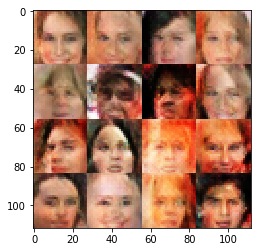

Epoch 1/1...Batch 6010 Discriminator Loss: 1.2685... Generator Loss: 1.2996
Epoch 1/1...Batch 6020 Discriminator Loss: 1.2529... Generator Loss: 0.8149
Epoch 1/1...Batch 6030 Discriminator Loss: 1.0768... Generator Loss: 0.9965
Epoch 1/1...Batch 6040 Discriminator Loss: 1.2916... Generator Loss: 0.6277
Epoch 1/1...Batch 6050 Discriminator Loss: 1.1856... Generator Loss: 0.7143
Epoch 1/1...Batch 6060 Discriminator Loss: 0.8748... Generator Loss: 1.2863
Epoch 1/1...Batch 6070 Discriminator Loss: 1.2185... Generator Loss: 0.7166
Epoch 1/1...Batch 6080 Discriminator Loss: 1.4449... Generator Loss: 0.4750
Epoch 1/1...Batch 6090 Discriminator Loss: 1.4444... Generator Loss: 0.5420
Epoch 1/1...Batch 6100 Discriminator Loss: 1.2656... Generator Loss: 0.8333


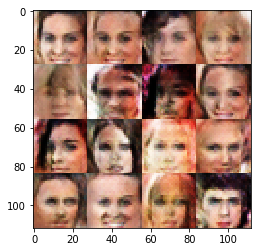

Epoch 1/1...Batch 6110 Discriminator Loss: 1.0679... Generator Loss: 0.9955
Epoch 1/1...Batch 6120 Discriminator Loss: 1.0701... Generator Loss: 0.8145
Epoch 1/1...Batch 6130 Discriminator Loss: 1.3097... Generator Loss: 0.6090
Epoch 1/1...Batch 6140 Discriminator Loss: 1.2763... Generator Loss: 0.5865
Epoch 1/1...Batch 6150 Discriminator Loss: 1.2126... Generator Loss: 1.0174
Epoch 1/1...Batch 6160 Discriminator Loss: 1.2820... Generator Loss: 0.8172
Epoch 1/1...Batch 6170 Discriminator Loss: 1.2369... Generator Loss: 0.7074
Epoch 1/1...Batch 6180 Discriminator Loss: 1.5762... Generator Loss: 0.4005
Epoch 1/1...Batch 6190 Discriminator Loss: 1.0802... Generator Loss: 0.8659
Epoch 1/1...Batch 6200 Discriminator Loss: 1.3363... Generator Loss: 0.6324


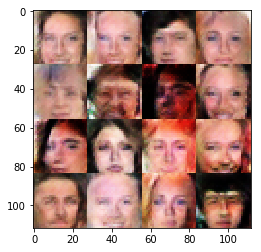

Epoch 1/1...Batch 6210 Discriminator Loss: 1.4320... Generator Loss: 0.5062
Epoch 1/1...Batch 6220 Discriminator Loss: 1.4274... Generator Loss: 0.4594
Epoch 1/1...Batch 6230 Discriminator Loss: 1.3228... Generator Loss: 0.6118
Epoch 1/1...Batch 6240 Discriminator Loss: 1.3192... Generator Loss: 0.9988
Epoch 1/1...Batch 6250 Discriminator Loss: 1.3881... Generator Loss: 0.5988
Epoch 1/1...Batch 6260 Discriminator Loss: 1.3200... Generator Loss: 0.6185
Epoch 1/1...Batch 6270 Discriminator Loss: 1.3353... Generator Loss: 0.7318
Epoch 1/1...Batch 6280 Discriminator Loss: 1.2913... Generator Loss: 1.0255
Epoch 1/1...Batch 6290 Discriminator Loss: 1.2807... Generator Loss: 0.6041
Epoch 1/1...Batch 6300 Discriminator Loss: 1.1536... Generator Loss: 0.8245


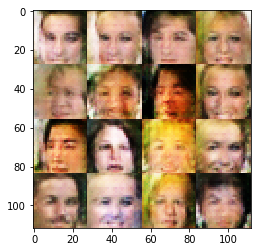

Epoch 1/1...Batch 6310 Discriminator Loss: 1.3266... Generator Loss: 0.5366
Epoch 1/1...Batch 6320 Discriminator Loss: 1.3964... Generator Loss: 0.6514
Epoch 1/1...Batch 6330 Discriminator Loss: 0.9816... Generator Loss: 1.5150
Epoch 1/1...Batch 6340 Discriminator Loss: 1.0971... Generator Loss: 0.8611
Epoch 1/1...Batch 6350 Discriminator Loss: 1.4110... Generator Loss: 0.4694
Epoch 1/1...Batch 6360 Discriminator Loss: 1.1964... Generator Loss: 0.6968
Epoch 1/1...Batch 6370 Discriminator Loss: 1.2400... Generator Loss: 0.6144
Epoch 1/1...Batch 6380 Discriminator Loss: 1.3722... Generator Loss: 0.7305
Epoch 1/1...Batch 6390 Discriminator Loss: 1.3169... Generator Loss: 0.6103
Epoch 1/1...Batch 6400 Discriminator Loss: 1.1101... Generator Loss: 0.8093


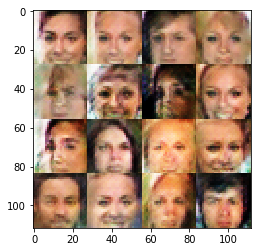

Epoch 1/1...Batch 6410 Discriminator Loss: 1.6688... Generator Loss: 0.3668
Epoch 1/1...Batch 6420 Discriminator Loss: 1.1119... Generator Loss: 0.9067
Epoch 1/1...Batch 6430 Discriminator Loss: 1.2687... Generator Loss: 0.6371
Epoch 1/1...Batch 6440 Discriminator Loss: 1.4332... Generator Loss: 0.5303
Epoch 1/1...Batch 6450 Discriminator Loss: 1.2065... Generator Loss: 0.9736
Epoch 1/1...Batch 6460 Discriminator Loss: 1.6962... Generator Loss: 0.3439
Epoch 1/1...Batch 6470 Discriminator Loss: 1.4225... Generator Loss: 0.5149
Epoch 1/1...Batch 6480 Discriminator Loss: 1.2049... Generator Loss: 0.9102
Epoch 1/1...Batch 6490 Discriminator Loss: 1.2442... Generator Loss: 0.6929
Epoch 1/1...Batch 6500 Discriminator Loss: 1.1082... Generator Loss: 0.8801


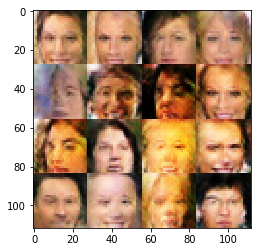

Epoch 1/1...Batch 6510 Discriminator Loss: 1.5029... Generator Loss: 0.5017
Epoch 1/1...Batch 6520 Discriminator Loss: 1.3841... Generator Loss: 0.5413
Epoch 1/1...Batch 6530 Discriminator Loss: 1.1905... Generator Loss: 0.7969
Epoch 1/1...Batch 6540 Discriminator Loss: 0.9575... Generator Loss: 0.9777
Epoch 1/1...Batch 6550 Discriminator Loss: 0.9630... Generator Loss: 1.1904
Epoch 1/1...Batch 6560 Discriminator Loss: 1.3537... Generator Loss: 0.5244
Epoch 1/1...Batch 6570 Discriminator Loss: 1.2548... Generator Loss: 1.0672
Epoch 1/1...Batch 6580 Discriminator Loss: 1.3757... Generator Loss: 0.9712
Epoch 1/1...Batch 6590 Discriminator Loss: 0.9578... Generator Loss: 0.9861
Epoch 1/1...Batch 6600 Discriminator Loss: 1.0808... Generator Loss: 1.0370


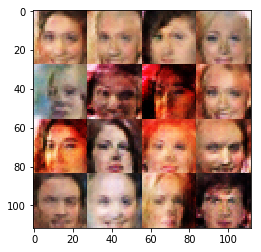

Epoch 1/1...Batch 6610 Discriminator Loss: 1.5590... Generator Loss: 0.4431
Epoch 1/1...Batch 6620 Discriminator Loss: 1.5952... Generator Loss: 0.3775
Epoch 1/1...Batch 6630 Discriminator Loss: 1.2541... Generator Loss: 0.6820
Epoch 1/1...Batch 6640 Discriminator Loss: 1.3110... Generator Loss: 0.5977
Epoch 1/1...Batch 6650 Discriminator Loss: 1.5550... Generator Loss: 0.4245
Epoch 1/1...Batch 6660 Discriminator Loss: 1.2661... Generator Loss: 0.7347
Epoch 1/1...Batch 6670 Discriminator Loss: 1.3713... Generator Loss: 0.6784
Epoch 1/1...Batch 6680 Discriminator Loss: 1.0927... Generator Loss: 0.9857
Epoch 1/1...Batch 6690 Discriminator Loss: 1.4682... Generator Loss: 0.5839
Epoch 1/1...Batch 6700 Discriminator Loss: 1.3848... Generator Loss: 0.5883


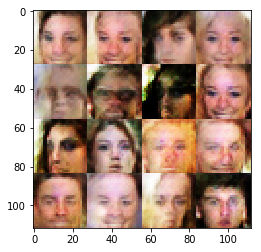

Epoch 1/1...Batch 6710 Discriminator Loss: 1.1173... Generator Loss: 1.0772
Epoch 1/1...Batch 6720 Discriminator Loss: 1.2279... Generator Loss: 0.8816
Epoch 1/1...Batch 6730 Discriminator Loss: 1.1230... Generator Loss: 0.7935
Epoch 1/1...Batch 6740 Discriminator Loss: 1.3395... Generator Loss: 0.6169
Epoch 1/1...Batch 6750 Discriminator Loss: 1.2907... Generator Loss: 0.5998
Epoch 1/1...Batch 6760 Discriminator Loss: 1.1210... Generator Loss: 0.7792
Epoch 1/1...Batch 6770 Discriminator Loss: 1.3395... Generator Loss: 0.5988
Epoch 1/1...Batch 6780 Discriminator Loss: 1.2563... Generator Loss: 0.6787
Epoch 1/1...Batch 6790 Discriminator Loss: 1.1002... Generator Loss: 0.7855
Epoch 1/1...Batch 6800 Discriminator Loss: 1.0404... Generator Loss: 1.4772


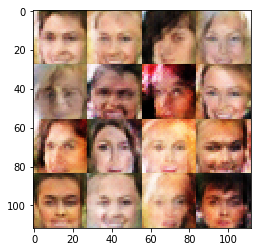

Epoch 1/1...Batch 6810 Discriminator Loss: 1.2645... Generator Loss: 0.6770
Epoch 1/1...Batch 6820 Discriminator Loss: 1.4261... Generator Loss: 0.4862
Epoch 1/1...Batch 6830 Discriminator Loss: 1.1960... Generator Loss: 0.9734
Epoch 1/1...Batch 6840 Discriminator Loss: 1.5626... Generator Loss: 0.4231
Epoch 1/1...Batch 6850 Discriminator Loss: 1.4962... Generator Loss: 0.4948
Epoch 1/1...Batch 6860 Discriminator Loss: 1.5458... Generator Loss: 0.4263
Epoch 1/1...Batch 6870 Discriminator Loss: 1.2928... Generator Loss: 0.5642
Epoch 1/1...Batch 6880 Discriminator Loss: 1.1342... Generator Loss: 0.7879
Epoch 1/1...Batch 6890 Discriminator Loss: 1.3625... Generator Loss: 0.6099
Epoch 1/1...Batch 6900 Discriminator Loss: 1.3332... Generator Loss: 0.5867


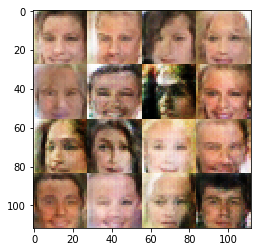

Epoch 1/1...Batch 6910 Discriminator Loss: 1.2734... Generator Loss: 0.5720
Epoch 1/1...Batch 6920 Discriminator Loss: 1.2580... Generator Loss: 0.6268
Epoch 1/1...Batch 6930 Discriminator Loss: 1.1664... Generator Loss: 0.7814
Epoch 1/1...Batch 6940 Discriminator Loss: 1.3673... Generator Loss: 0.5007
Epoch 1/1...Batch 6950 Discriminator Loss: 1.0725... Generator Loss: 0.8254
Epoch 1/1...Batch 6960 Discriminator Loss: 1.3839... Generator Loss: 0.5423
Epoch 1/1...Batch 6970 Discriminator Loss: 1.3043... Generator Loss: 0.5871
Epoch 1/1...Batch 6980 Discriminator Loss: 1.0954... Generator Loss: 1.3949
Epoch 1/1...Batch 6990 Discriminator Loss: 1.1520... Generator Loss: 0.6852
Epoch 1/1...Batch 7000 Discriminator Loss: 1.2041... Generator Loss: 0.6884


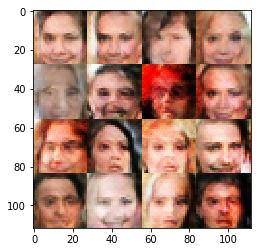

Epoch 1/1...Batch 7010 Discriminator Loss: 1.4893... Generator Loss: 0.5199
Epoch 1/1...Batch 7020 Discriminator Loss: 1.2338... Generator Loss: 0.7836
Epoch 1/1...Batch 7030 Discriminator Loss: 1.3048... Generator Loss: 0.5977
Epoch 1/1...Batch 7040 Discriminator Loss: 1.0779... Generator Loss: 1.0066
Epoch 1/1...Batch 7050 Discriminator Loss: 1.3807... Generator Loss: 0.5920
Epoch 1/1...Batch 7060 Discriminator Loss: 1.2821... Generator Loss: 1.0672
Epoch 1/1...Batch 7070 Discriminator Loss: 1.3378... Generator Loss: 0.5711
Epoch 1/1...Batch 7080 Discriminator Loss: 1.3507... Generator Loss: 0.7121
Epoch 1/1...Batch 7090 Discriminator Loss: 1.0819... Generator Loss: 0.9589
Epoch 1/1...Batch 7100 Discriminator Loss: 1.3995... Generator Loss: 0.7454


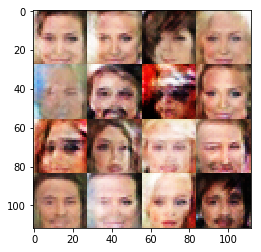

Epoch 1/1...Batch 7110 Discriminator Loss: 1.1192... Generator Loss: 0.8240
Epoch 1/1...Batch 7120 Discriminator Loss: 1.2846... Generator Loss: 0.6271
Epoch 1/1...Batch 7130 Discriminator Loss: 0.9855... Generator Loss: 1.1890
Epoch 1/1...Batch 7140 Discriminator Loss: 1.2802... Generator Loss: 0.5890
Epoch 1/1...Batch 7150 Discriminator Loss: 1.4628... Generator Loss: 1.0484
Epoch 1/1...Batch 7160 Discriminator Loss: 1.2587... Generator Loss: 0.6034
Epoch 1/1...Batch 7170 Discriminator Loss: 1.1225... Generator Loss: 0.9936
Epoch 1/1...Batch 7180 Discriminator Loss: 1.0234... Generator Loss: 0.8271
Epoch 1/1...Batch 7190 Discriminator Loss: 1.1530... Generator Loss: 0.7523
Epoch 1/1...Batch 7200 Discriminator Loss: 1.3558... Generator Loss: 1.1235


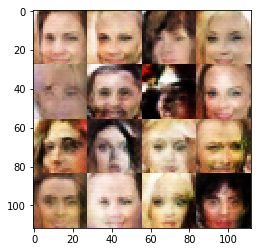

Epoch 1/1...Batch 7210 Discriminator Loss: 1.3312... Generator Loss: 0.5313
Epoch 1/1...Batch 7220 Discriminator Loss: 1.1070... Generator Loss: 1.1863
Epoch 1/1...Batch 7230 Discriminator Loss: 1.2431... Generator Loss: 0.7342
Epoch 1/1...Batch 7240 Discriminator Loss: 1.7529... Generator Loss: 0.3114
Epoch 1/1...Batch 7250 Discriminator Loss: 1.1938... Generator Loss: 0.8722
Epoch 1/1...Batch 7260 Discriminator Loss: 1.3285... Generator Loss: 0.6023
Epoch 1/1...Batch 7270 Discriminator Loss: 1.2439... Generator Loss: 0.7949
Epoch 1/1...Batch 7280 Discriminator Loss: 1.1489... Generator Loss: 0.8023
Epoch 1/1...Batch 7290 Discriminator Loss: 1.6298... Generator Loss: 0.3511
Epoch 1/1...Batch 7300 Discriminator Loss: 1.0096... Generator Loss: 1.0921


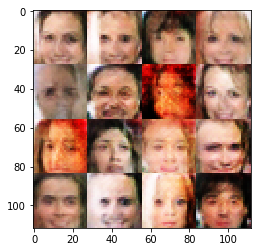

Epoch 1/1...Batch 7310 Discriminator Loss: 1.2760... Generator Loss: 0.8133
Epoch 1/1...Batch 7320 Discriminator Loss: 1.1986... Generator Loss: 0.7912
Epoch 1/1...Batch 7330 Discriminator Loss: 1.2362... Generator Loss: 0.7239
Epoch 1/1...Batch 7340 Discriminator Loss: 1.1192... Generator Loss: 0.9862
Epoch 1/1...Batch 7350 Discriminator Loss: 1.2605... Generator Loss: 0.8266
Epoch 1/1...Batch 7360 Discriminator Loss: 1.0854... Generator Loss: 0.8694
Epoch 1/1...Batch 7370 Discriminator Loss: 1.0935... Generator Loss: 0.9952
Epoch 1/1...Batch 7380 Discriminator Loss: 1.1560... Generator Loss: 0.7748
Epoch 1/1...Batch 7390 Discriminator Loss: 1.0017... Generator Loss: 0.9695
Epoch 1/1...Batch 7400 Discriminator Loss: 1.2305... Generator Loss: 0.8144


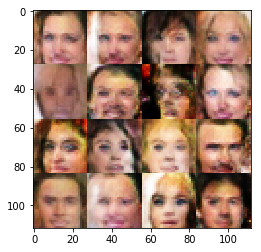

Epoch 1/1...Batch 7410 Discriminator Loss: 1.4353... Generator Loss: 0.8362
Epoch 1/1...Batch 7420 Discriminator Loss: 1.2785... Generator Loss: 0.6838
Epoch 1/1...Batch 7430 Discriminator Loss: 1.2138... Generator Loss: 0.7681
Epoch 1/1...Batch 7440 Discriminator Loss: 1.4418... Generator Loss: 0.4645
Epoch 1/1...Batch 7450 Discriminator Loss: 1.1559... Generator Loss: 0.7967
Epoch 1/1...Batch 7460 Discriminator Loss: 1.0755... Generator Loss: 0.9599
Epoch 1/1...Batch 7470 Discriminator Loss: 1.3163... Generator Loss: 0.7004
Epoch 1/1...Batch 7480 Discriminator Loss: 1.2390... Generator Loss: 0.6531
Epoch 1/1...Batch 7490 Discriminator Loss: 1.1820... Generator Loss: 0.6558
Epoch 1/1...Batch 7500 Discriminator Loss: 1.2186... Generator Loss: 0.6517


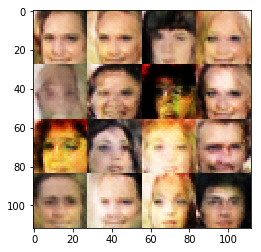

Epoch 1/1...Batch 7510 Discriminator Loss: 1.2826... Generator Loss: 0.5604
Epoch 1/1...Batch 7520 Discriminator Loss: 1.1693... Generator Loss: 0.7900
Epoch 1/1...Batch 7530 Discriminator Loss: 1.1311... Generator Loss: 0.8734
Epoch 1/1...Batch 7540 Discriminator Loss: 1.1094... Generator Loss: 0.7699
Epoch 1/1...Batch 7550 Discriminator Loss: 1.2725... Generator Loss: 0.6337
Epoch 1/1...Batch 7560 Discriminator Loss: 1.2376... Generator Loss: 0.7048
Epoch 1/1...Batch 7570 Discriminator Loss: 1.6132... Generator Loss: 0.3823
Epoch 1/1...Batch 7580 Discriminator Loss: 1.0547... Generator Loss: 0.9192
Epoch 1/1...Batch 7590 Discriminator Loss: 1.3030... Generator Loss: 0.6424
Epoch 1/1...Batch 7600 Discriminator Loss: 1.0963... Generator Loss: 0.8159


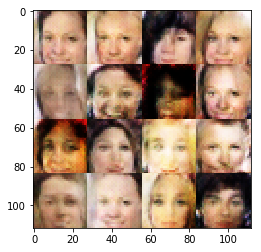

Epoch 1/1...Batch 7610 Discriminator Loss: 1.2684... Generator Loss: 0.6671
Epoch 1/1...Batch 7620 Discriminator Loss: 1.2082... Generator Loss: 0.7877
Epoch 1/1...Batch 7630 Discriminator Loss: 1.4022... Generator Loss: 0.4975
Epoch 1/1...Batch 7640 Discriminator Loss: 1.4750... Generator Loss: 0.4516
Epoch 1/1...Batch 7650 Discriminator Loss: 1.3420... Generator Loss: 0.5168
Epoch 1/1...Batch 7660 Discriminator Loss: 1.1700... Generator Loss: 0.7052
Epoch 1/1...Batch 7670 Discriminator Loss: 1.7936... Generator Loss: 0.2890
Epoch 1/1...Batch 7680 Discriminator Loss: 1.1330... Generator Loss: 1.0261
Epoch 1/1...Batch 7690 Discriminator Loss: 1.3931... Generator Loss: 0.5977
Epoch 1/1...Batch 7700 Discriminator Loss: 1.4754... Generator Loss: 0.4909


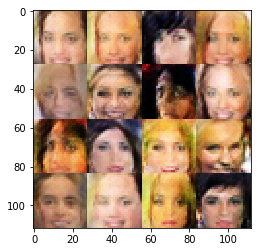

Epoch 1/1...Batch 7710 Discriminator Loss: 1.2215... Generator Loss: 0.6057
Epoch 1/1...Batch 7720 Discriminator Loss: 1.1090... Generator Loss: 0.7994
Epoch 1/1...Batch 7730 Discriminator Loss: 1.0569... Generator Loss: 1.0847
Epoch 1/1...Batch 7740 Discriminator Loss: 1.2837... Generator Loss: 0.8969
Epoch 1/1...Batch 7750 Discriminator Loss: 1.3210... Generator Loss: 0.5684
Epoch 1/1...Batch 7760 Discriminator Loss: 1.3815... Generator Loss: 0.5890
Epoch 1/1...Batch 7770 Discriminator Loss: 1.1397... Generator Loss: 0.7847
Epoch 1/1...Batch 7780 Discriminator Loss: 1.4228... Generator Loss: 0.5263
Epoch 1/1...Batch 7790 Discriminator Loss: 1.5846... Generator Loss: 0.3793
Epoch 1/1...Batch 7800 Discriminator Loss: 1.4921... Generator Loss: 0.5796


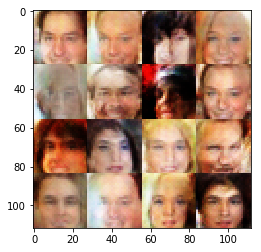

Epoch 1/1...Batch 7810 Discriminator Loss: 1.8106... Generator Loss: 0.2860
Epoch 1/1...Batch 7820 Discriminator Loss: 1.0804... Generator Loss: 0.7873
Epoch 1/1...Batch 7830 Discriminator Loss: 1.2504... Generator Loss: 0.6238
Epoch 1/1...Batch 7840 Discriminator Loss: 1.2574... Generator Loss: 0.6139
Epoch 1/1...Batch 7850 Discriminator Loss: 1.3700... Generator Loss: 0.5618
Epoch 1/1...Batch 7860 Discriminator Loss: 1.3920... Generator Loss: 0.5931
Epoch 1/1...Batch 7870 Discriminator Loss: 1.3048... Generator Loss: 0.6418
Epoch 1/1...Batch 7880 Discriminator Loss: 1.4506... Generator Loss: 0.4885
Epoch 1/1...Batch 7890 Discriminator Loss: 1.2800... Generator Loss: 1.0283
Epoch 1/1...Batch 7900 Discriminator Loss: 1.0316... Generator Loss: 0.9659


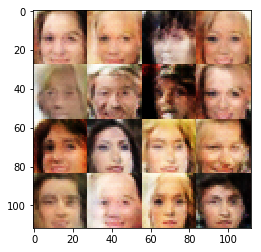

Epoch 1/1...Batch 7910 Discriminator Loss: 1.1487... Generator Loss: 0.8204
Epoch 1/1...Batch 7920 Discriminator Loss: 1.1763... Generator Loss: 0.7623
Epoch 1/1...Batch 7930 Discriminator Loss: 1.2702... Generator Loss: 1.0340
Epoch 1/1...Batch 7940 Discriminator Loss: 1.3093... Generator Loss: 0.5569
Epoch 1/1...Batch 7950 Discriminator Loss: 1.2563... Generator Loss: 0.7588
Epoch 1/1...Batch 7960 Discriminator Loss: 1.4340... Generator Loss: 0.4719
Epoch 1/1...Batch 7970 Discriminator Loss: 1.3265... Generator Loss: 0.7950
Epoch 1/1...Batch 7980 Discriminator Loss: 1.4947... Generator Loss: 0.4401
Epoch 1/1...Batch 7990 Discriminator Loss: 1.3186... Generator Loss: 0.9178
Epoch 1/1...Batch 8000 Discriminator Loss: 1.5493... Generator Loss: 0.3926


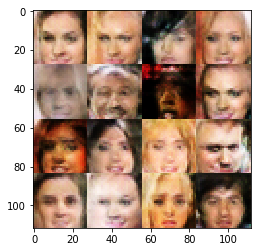

Epoch 1/1...Batch 8010 Discriminator Loss: 1.2147... Generator Loss: 0.9231
Epoch 1/1...Batch 8020 Discriminator Loss: 1.3370... Generator Loss: 0.5906
Epoch 1/1...Batch 8030 Discriminator Loss: 1.3768... Generator Loss: 0.5259
Epoch 1/1...Batch 8040 Discriminator Loss: 1.3860... Generator Loss: 0.5045
Epoch 1/1...Batch 8050 Discriminator Loss: 1.1627... Generator Loss: 0.9214
Epoch 1/1...Batch 8060 Discriminator Loss: 1.3372... Generator Loss: 0.5425
Epoch 1/1...Batch 8070 Discriminator Loss: 1.3203... Generator Loss: 0.5845
Epoch 1/1...Batch 8080 Discriminator Loss: 1.2981... Generator Loss: 0.6251
Epoch 1/1...Batch 8090 Discriminator Loss: 1.2472... Generator Loss: 0.6632
Epoch 1/1...Batch 8100 Discriminator Loss: 1.3339... Generator Loss: 0.6317


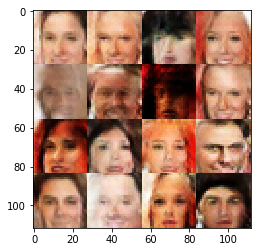

Epoch 1/1...Batch 8110 Discriminator Loss: 1.2365... Generator Loss: 0.8346
Epoch 1/1...Batch 8120 Discriminator Loss: 1.2559... Generator Loss: 0.6494
Epoch 1/1...Batch 8130 Discriminator Loss: 1.3422... Generator Loss: 0.5413
Epoch 1/1...Batch 8140 Discriminator Loss: 1.0953... Generator Loss: 0.8779
Epoch 1/1...Batch 8150 Discriminator Loss: 1.3640... Generator Loss: 0.5465
Epoch 1/1...Batch 8160 Discriminator Loss: 1.0783... Generator Loss: 0.9388
Epoch 1/1...Batch 8170 Discriminator Loss: 0.9892... Generator Loss: 1.1077
Epoch 1/1...Batch 8180 Discriminator Loss: 1.4747... Generator Loss: 0.5596
Epoch 1/1...Batch 8190 Discriminator Loss: 1.2373... Generator Loss: 0.6380
Epoch 1/1...Batch 8200 Discriminator Loss: 1.3615... Generator Loss: 0.5010


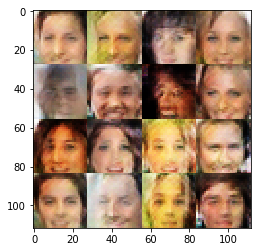

Epoch 1/1...Batch 8210 Discriminator Loss: 1.2592... Generator Loss: 0.6321
Epoch 1/1...Batch 8220 Discriminator Loss: 1.3425... Generator Loss: 0.5756
Epoch 1/1...Batch 8230 Discriminator Loss: 1.1143... Generator Loss: 0.7453
Epoch 1/1...Batch 8240 Discriminator Loss: 0.9902... Generator Loss: 1.1327
Epoch 1/1...Batch 8250 Discriminator Loss: 1.4539... Generator Loss: 0.4688
Epoch 1/1...Batch 8260 Discriminator Loss: 1.3594... Generator Loss: 0.5303
Epoch 1/1...Batch 8270 Discriminator Loss: 1.2677... Generator Loss: 0.6815
Epoch 1/1...Batch 8280 Discriminator Loss: 1.1322... Generator Loss: 0.7620
Epoch 1/1...Batch 8290 Discriminator Loss: 1.2351... Generator Loss: 0.6755
Epoch 1/1...Batch 8300 Discriminator Loss: 1.1971... Generator Loss: 1.0793


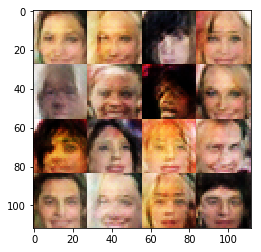

Epoch 1/1...Batch 8310 Discriminator Loss: 1.5949... Generator Loss: 0.4441
Epoch 1/1...Batch 8320 Discriminator Loss: 1.2368... Generator Loss: 1.1299
Epoch 1/1...Batch 8330 Discriminator Loss: 1.0713... Generator Loss: 1.0206
Epoch 1/1...Batch 8340 Discriminator Loss: 1.0630... Generator Loss: 1.4245
Epoch 1/1...Batch 8350 Discriminator Loss: 1.3732... Generator Loss: 0.5582
Epoch 1/1...Batch 8360 Discriminator Loss: 1.1898... Generator Loss: 0.8849
Epoch 1/1...Batch 8370 Discriminator Loss: 1.6504... Generator Loss: 0.4078
Epoch 1/1...Batch 8380 Discriminator Loss: 1.5648... Generator Loss: 0.4448
Epoch 1/1...Batch 8390 Discriminator Loss: 1.2751... Generator Loss: 0.6980
Epoch 1/1...Batch 8400 Discriminator Loss: 1.1886... Generator Loss: 1.0214


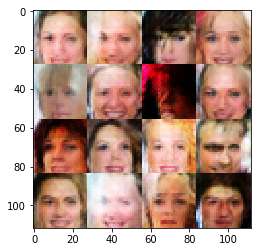

Epoch 1/1...Batch 8410 Discriminator Loss: 1.3096... Generator Loss: 0.7367
Epoch 1/1...Batch 8420 Discriminator Loss: 1.0894... Generator Loss: 0.9745
Epoch 1/1...Batch 8430 Discriminator Loss: 1.2671... Generator Loss: 0.6789
Epoch 1/1...Batch 8440 Discriminator Loss: 1.1842... Generator Loss: 0.6673
Epoch 1/1...Batch 8450 Discriminator Loss: 1.3811... Generator Loss: 0.5247
Epoch 1/1...Batch 8460 Discriminator Loss: 1.0868... Generator Loss: 1.0461
Epoch 1/1...Batch 8470 Discriminator Loss: 1.2942... Generator Loss: 0.6181
Epoch 1/1...Batch 8480 Discriminator Loss: 1.0739... Generator Loss: 1.0641
Epoch 1/1...Batch 8490 Discriminator Loss: 1.3341... Generator Loss: 0.5279
Epoch 1/1...Batch 8500 Discriminator Loss: 1.5660... Generator Loss: 0.4374


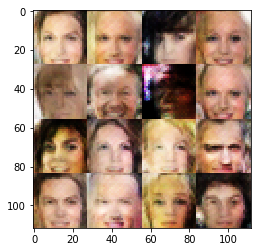

Epoch 1/1...Batch 8510 Discriminator Loss: 1.5658... Generator Loss: 0.4114
Epoch 1/1...Batch 8520 Discriminator Loss: 1.4118... Generator Loss: 0.5018
Epoch 1/1...Batch 8530 Discriminator Loss: 1.1121... Generator Loss: 0.9543
Epoch 1/1...Batch 8540 Discriminator Loss: 1.3848... Generator Loss: 0.4969
Epoch 1/1...Batch 8550 Discriminator Loss: 1.1357... Generator Loss: 1.2511
Epoch 1/1...Batch 8560 Discriminator Loss: 1.0740... Generator Loss: 0.9284
Epoch 1/1...Batch 8570 Discriminator Loss: 1.1576... Generator Loss: 0.9168
Epoch 1/1...Batch 8580 Discriminator Loss: 1.0860... Generator Loss: 0.9395
Epoch 1/1...Batch 8590 Discriminator Loss: 1.3484... Generator Loss: 0.6874
Epoch 1/1...Batch 8600 Discriminator Loss: 1.1110... Generator Loss: 0.7645


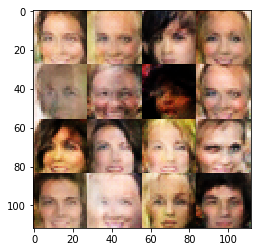

Epoch 1/1...Batch 8610 Discriminator Loss: 1.0875... Generator Loss: 1.0088
Epoch 1/1...Batch 8620 Discriminator Loss: 1.8928... Generator Loss: 0.2566
Epoch 1/1...Batch 8630 Discriminator Loss: 1.4311... Generator Loss: 0.4657
Epoch 1/1...Batch 8640 Discriminator Loss: 1.2001... Generator Loss: 0.6951
Epoch 1/1...Batch 8650 Discriminator Loss: 1.2969... Generator Loss: 0.6394
Epoch 1/1...Batch 8660 Discriminator Loss: 1.2622... Generator Loss: 0.7917
Epoch 1/1...Batch 8670 Discriminator Loss: 1.4352... Generator Loss: 0.6597
Epoch 1/1...Batch 8680 Discriminator Loss: 1.0392... Generator Loss: 0.8716
Epoch 1/1...Batch 8690 Discriminator Loss: 1.2818... Generator Loss: 0.5534
Epoch 1/1...Batch 8700 Discriminator Loss: 1.1163... Generator Loss: 0.8257


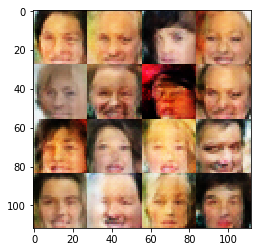

Epoch 1/1...Batch 8710 Discriminator Loss: 1.2112... Generator Loss: 0.9845
Epoch 1/1...Batch 8720 Discriminator Loss: 1.3429... Generator Loss: 0.5438
Epoch 1/1...Batch 8730 Discriminator Loss: 1.3442... Generator Loss: 0.5590
Epoch 1/1...Batch 8740 Discriminator Loss: 1.3061... Generator Loss: 0.6208
Epoch 1/1...Batch 8750 Discriminator Loss: 1.0464... Generator Loss: 1.2114
Epoch 1/1...Batch 8760 Discriminator Loss: 1.1384... Generator Loss: 0.8137
Epoch 1/1...Batch 8770 Discriminator Loss: 1.4652... Generator Loss: 0.4357
Epoch 1/1...Batch 8780 Discriminator Loss: 1.3518... Generator Loss: 0.9194
Epoch 1/1...Batch 8790 Discriminator Loss: 1.1937... Generator Loss: 0.7177
Epoch 1/1...Batch 8800 Discriminator Loss: 1.5004... Generator Loss: 0.4524


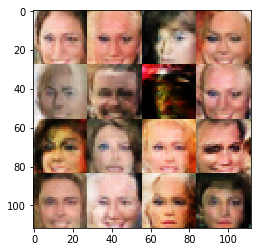

Epoch 1/1...Batch 8810 Discriminator Loss: 1.1319... Generator Loss: 0.8635
Epoch 1/1...Batch 8820 Discriminator Loss: 1.3727... Generator Loss: 0.6051
Epoch 1/1...Batch 8830 Discriminator Loss: 1.2289... Generator Loss: 0.6463
Epoch 1/1...Batch 8840 Discriminator Loss: 1.3671... Generator Loss: 0.5563
Epoch 1/1...Batch 8850 Discriminator Loss: 1.0561... Generator Loss: 0.9034
Epoch 1/1...Batch 8860 Discriminator Loss: 1.5447... Generator Loss: 0.4551
Epoch 1/1...Batch 8870 Discriminator Loss: 1.1949... Generator Loss: 0.7594
Epoch 1/1...Batch 8880 Discriminator Loss: 0.8911... Generator Loss: 1.1618
Epoch 1/1...Batch 8890 Discriminator Loss: 1.2185... Generator Loss: 0.6815
Epoch 1/1...Batch 8900 Discriminator Loss: 1.5717... Generator Loss: 0.4275


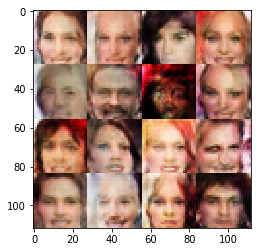

Epoch 1/1...Batch 8910 Discriminator Loss: 1.4223... Generator Loss: 0.5179
Epoch 1/1...Batch 8920 Discriminator Loss: 1.2295... Generator Loss: 0.6691
Epoch 1/1...Batch 8930 Discriminator Loss: 1.3334... Generator Loss: 0.5617
Epoch 1/1...Batch 8940 Discriminator Loss: 1.3397... Generator Loss: 0.7397
Epoch 1/1...Batch 8950 Discriminator Loss: 1.1903... Generator Loss: 0.8096
Epoch 1/1...Batch 8960 Discriminator Loss: 1.1414... Generator Loss: 0.6893
Epoch 1/1...Batch 8970 Discriminator Loss: 1.0529... Generator Loss: 0.8291
Epoch 1/1...Batch 8980 Discriminator Loss: 1.5004... Generator Loss: 0.4189
Epoch 1/1...Batch 8990 Discriminator Loss: 1.4968... Generator Loss: 0.4279
Epoch 1/1...Batch 9000 Discriminator Loss: 1.2168... Generator Loss: 0.8973


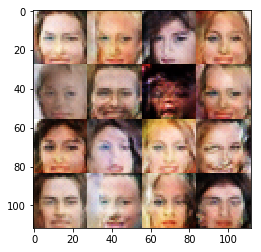

Epoch 1/1...Batch 9010 Discriminator Loss: 1.0725... Generator Loss: 0.9883
Epoch 1/1...Batch 9020 Discriminator Loss: 1.0789... Generator Loss: 0.7588
Epoch 1/1...Batch 9030 Discriminator Loss: 1.3311... Generator Loss: 0.6361
Epoch 1/1...Batch 9040 Discriminator Loss: 1.2633... Generator Loss: 0.6926
Epoch 1/1...Batch 9050 Discriminator Loss: 1.1704... Generator Loss: 0.7514
Epoch 1/1...Batch 9060 Discriminator Loss: 1.2853... Generator Loss: 0.7620
Epoch 1/1...Batch 9070 Discriminator Loss: 1.4409... Generator Loss: 0.4944
Epoch 1/1...Batch 9080 Discriminator Loss: 1.2977... Generator Loss: 0.6321
Epoch 1/1...Batch 9090 Discriminator Loss: 1.3138... Generator Loss: 0.6855
Epoch 1/1...Batch 9100 Discriminator Loss: 1.6872... Generator Loss: 0.3948


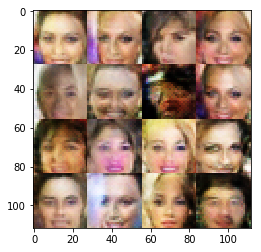

Epoch 1/1...Batch 9110 Discriminator Loss: 1.5463... Generator Loss: 0.5412
Epoch 1/1...Batch 9120 Discriminator Loss: 1.2275... Generator Loss: 0.7160
Epoch 1/1...Batch 9130 Discriminator Loss: 1.3043... Generator Loss: 0.7278
Epoch 1/1...Batch 9140 Discriminator Loss: 1.2636... Generator Loss: 0.6086
Epoch 1/1...Batch 9150 Discriminator Loss: 1.2655... Generator Loss: 0.7248
Epoch 1/1...Batch 9160 Discriminator Loss: 1.0477... Generator Loss: 0.9207
Epoch 1/1...Batch 9170 Discriminator Loss: 1.5177... Generator Loss: 0.4511
Epoch 1/1...Batch 9180 Discriminator Loss: 1.5725... Generator Loss: 0.4295
Epoch 1/1...Batch 9190 Discriminator Loss: 1.2785... Generator Loss: 0.7696
Epoch 1/1...Batch 9200 Discriminator Loss: 1.4166... Generator Loss: 0.4930


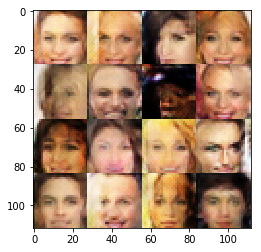

Epoch 1/1...Batch 9210 Discriminator Loss: 1.3007... Generator Loss: 0.5515
Epoch 1/1...Batch 9220 Discriminator Loss: 1.4284... Generator Loss: 0.5103
Epoch 1/1...Batch 9230 Discriminator Loss: 1.1242... Generator Loss: 0.7515
Epoch 1/1...Batch 9240 Discriminator Loss: 1.1379... Generator Loss: 0.7693
Epoch 1/1...Batch 9250 Discriminator Loss: 1.0387... Generator Loss: 0.9919
Epoch 1/1...Batch 9260 Discriminator Loss: 1.1241... Generator Loss: 0.9654
Epoch 1/1...Batch 9270 Discriminator Loss: 1.3084... Generator Loss: 0.6553
Epoch 1/1...Batch 9280 Discriminator Loss: 1.2354... Generator Loss: 0.6810
Epoch 1/1...Batch 9290 Discriminator Loss: 1.2564... Generator Loss: 0.7675
Epoch 1/1...Batch 9300 Discriminator Loss: 1.5013... Generator Loss: 0.4454


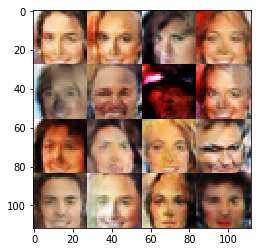

Epoch 1/1...Batch 9310 Discriminator Loss: 1.6187... Generator Loss: 0.3687
Epoch 1/1...Batch 9320 Discriminator Loss: 1.1660... Generator Loss: 0.9310
Epoch 1/1...Batch 9330 Discriminator Loss: 1.0683... Generator Loss: 0.8370
Epoch 1/1...Batch 9340 Discriminator Loss: 1.2342... Generator Loss: 0.5939
Epoch 1/1...Batch 9350 Discriminator Loss: 1.1315... Generator Loss: 1.0413
Epoch 1/1...Batch 9360 Discriminator Loss: 1.2563... Generator Loss: 0.9861
Epoch 1/1...Batch 9370 Discriminator Loss: 1.4179... Generator Loss: 0.4696
Epoch 1/1...Batch 9380 Discriminator Loss: 1.2578... Generator Loss: 0.5900
Epoch 1/1...Batch 9390 Discriminator Loss: 1.2219... Generator Loss: 0.7208
Epoch 1/1...Batch 9400 Discriminator Loss: 1.3142... Generator Loss: 0.5914


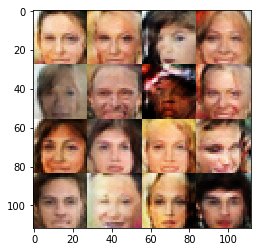

Epoch 1/1...Batch 9410 Discriminator Loss: 1.2656... Generator Loss: 0.6986
Epoch 1/1...Batch 9420 Discriminator Loss: 1.2775... Generator Loss: 0.7836
Epoch 1/1...Batch 9430 Discriminator Loss: 1.1669... Generator Loss: 0.7958
Epoch 1/1...Batch 9440 Discriminator Loss: 1.1566... Generator Loss: 0.7117
Epoch 1/1...Batch 9450 Discriminator Loss: 1.2777... Generator Loss: 0.8338
Epoch 1/1...Batch 9460 Discriminator Loss: 1.1532... Generator Loss: 0.7046
Epoch 1/1...Batch 9470 Discriminator Loss: 1.0496... Generator Loss: 0.8731
Epoch 1/1...Batch 9480 Discriminator Loss: 1.0462... Generator Loss: 0.9039
Epoch 1/1...Batch 9490 Discriminator Loss: 1.1424... Generator Loss: 1.2704
Epoch 1/1...Batch 9500 Discriminator Loss: 1.1945... Generator Loss: 0.8799


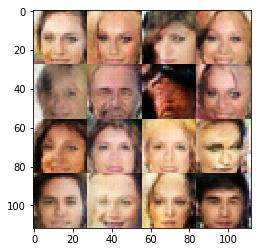

Epoch 1/1...Batch 9510 Discriminator Loss: 1.1431... Generator Loss: 0.8056
Epoch 1/1...Batch 9520 Discriminator Loss: 1.2842... Generator Loss: 0.5809
Epoch 1/1...Batch 9530 Discriminator Loss: 1.1791... Generator Loss: 0.7787
Epoch 1/1...Batch 9540 Discriminator Loss: 1.1090... Generator Loss: 0.8107
Epoch 1/1...Batch 9550 Discriminator Loss: 1.2688... Generator Loss: 0.7053
Epoch 1/1...Batch 9560 Discriminator Loss: 1.4799... Generator Loss: 0.4205
Epoch 1/1...Batch 9570 Discriminator Loss: 1.4439... Generator Loss: 0.5079
Epoch 1/1...Batch 9580 Discriminator Loss: 1.1219... Generator Loss: 0.7871
Epoch 1/1...Batch 9590 Discriminator Loss: 1.0692... Generator Loss: 1.0169
Epoch 1/1...Batch 9600 Discriminator Loss: 0.9862... Generator Loss: 1.1306


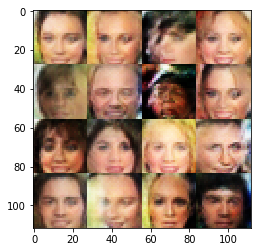

Epoch 1/1...Batch 9610 Discriminator Loss: 1.1688... Generator Loss: 0.6165
Epoch 1/1...Batch 9620 Discriminator Loss: 1.5497... Generator Loss: 0.4053
Epoch 1/1...Batch 9630 Discriminator Loss: 1.2694... Generator Loss: 0.6107
Epoch 1/1...Batch 9640 Discriminator Loss: 1.2272... Generator Loss: 0.7076
Epoch 1/1...Batch 9650 Discriminator Loss: 1.1950... Generator Loss: 0.7497
Epoch 1/1...Batch 9660 Discriminator Loss: 1.2065... Generator Loss: 1.0882
Epoch 1/1...Batch 9670 Discriminator Loss: 1.2309... Generator Loss: 0.5838
Epoch 1/1...Batch 9680 Discriminator Loss: 1.5082... Generator Loss: 0.4284
Epoch 1/1...Batch 9690 Discriminator Loss: 1.2070... Generator Loss: 0.7335
Epoch 1/1...Batch 9700 Discriminator Loss: 1.3513... Generator Loss: 0.5962


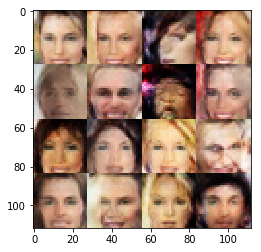

Epoch 1/1...Batch 9710 Discriminator Loss: 1.3501... Generator Loss: 0.7443
Epoch 1/1...Batch 9720 Discriminator Loss: 1.4644... Generator Loss: 0.4467
Epoch 1/1...Batch 9730 Discriminator Loss: 1.0321... Generator Loss: 1.2310
Epoch 1/1...Batch 9740 Discriminator Loss: 1.2378... Generator Loss: 0.6869
Epoch 1/1...Batch 9750 Discriminator Loss: 1.2530... Generator Loss: 0.7156
Epoch 1/1...Batch 9760 Discriminator Loss: 1.1575... Generator Loss: 1.0897
Epoch 1/1...Batch 9770 Discriminator Loss: 1.0793... Generator Loss: 1.0491
Epoch 1/1...Batch 9780 Discriminator Loss: 1.1238... Generator Loss: 0.8641
Epoch 1/1...Batch 9790 Discriminator Loss: 1.2610... Generator Loss: 0.7386
Epoch 1/1...Batch 9800 Discriminator Loss: 1.4702... Generator Loss: 0.4661


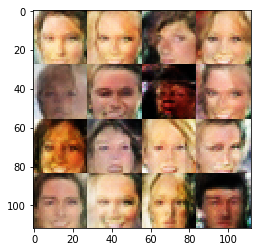

Epoch 1/1...Batch 9810 Discriminator Loss: 1.1589... Generator Loss: 0.7768
Epoch 1/1...Batch 9820 Discriminator Loss: 1.3597... Generator Loss: 0.6302
Epoch 1/1...Batch 9830 Discriminator Loss: 1.7980... Generator Loss: 0.3003
Epoch 1/1...Batch 9840 Discriminator Loss: 1.4005... Generator Loss: 0.6117
Epoch 1/1...Batch 9850 Discriminator Loss: 1.7031... Generator Loss: 0.3124
Epoch 1/1...Batch 9860 Discriminator Loss: 1.4431... Generator Loss: 0.5483
Epoch 1/1...Batch 9870 Discriminator Loss: 1.3462... Generator Loss: 1.4035
Epoch 1/1...Batch 9880 Discriminator Loss: 1.2296... Generator Loss: 0.8213
Epoch 1/1...Batch 9890 Discriminator Loss: 1.2403... Generator Loss: 0.7299
Epoch 1/1...Batch 9900 Discriminator Loss: 1.4547... Generator Loss: 0.4699


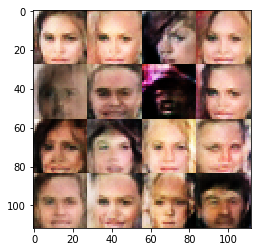

Epoch 1/1...Batch 9910 Discriminator Loss: 1.1535... Generator Loss: 0.7523
Epoch 1/1...Batch 9920 Discriminator Loss: 1.2491... Generator Loss: 0.6631
Epoch 1/1...Batch 9930 Discriminator Loss: 1.5182... Generator Loss: 0.4187
Epoch 1/1...Batch 9940 Discriminator Loss: 1.0280... Generator Loss: 0.9681
Epoch 1/1...Batch 9950 Discriminator Loss: 1.3329... Generator Loss: 0.5153
Epoch 1/1...Batch 9960 Discriminator Loss: 1.2502... Generator Loss: 0.6180
Epoch 1/1...Batch 9970 Discriminator Loss: 1.1845... Generator Loss: 0.7124
Epoch 1/1...Batch 9980 Discriminator Loss: 1.1403... Generator Loss: 0.7066
Epoch 1/1...Batch 9990 Discriminator Loss: 1.1446... Generator Loss: 0.7913
Epoch 1/1...Batch 10000 Discriminator Loss: 1.3474... Generator Loss: 0.6331


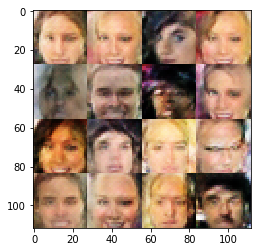

Epoch 1/1...Batch 10010 Discriminator Loss: 1.3108... Generator Loss: 0.6701
Epoch 1/1...Batch 10020 Discriminator Loss: 1.4071... Generator Loss: 0.5367
Epoch 1/1...Batch 10030 Discriminator Loss: 1.3996... Generator Loss: 0.4738
Epoch 1/1...Batch 10040 Discriminator Loss: 1.0843... Generator Loss: 0.8539
Epoch 1/1...Batch 10050 Discriminator Loss: 1.1465... Generator Loss: 0.9375
Epoch 1/1...Batch 10060 Discriminator Loss: 1.3066... Generator Loss: 1.3468
Epoch 1/1...Batch 10070 Discriminator Loss: 1.5227... Generator Loss: 0.4448
Epoch 1/1...Batch 10080 Discriminator Loss: 1.2506... Generator Loss: 0.5773
Epoch 1/1...Batch 10090 Discriminator Loss: 0.9017... Generator Loss: 1.3196
Epoch 1/1...Batch 10100 Discriminator Loss: 1.0504... Generator Loss: 0.9709


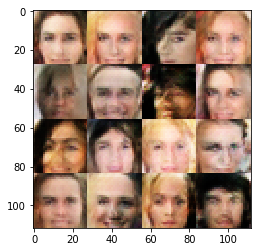

Epoch 1/1...Batch 10110 Discriminator Loss: 1.3082... Generator Loss: 0.7493
Epoch 1/1...Batch 10120 Discriminator Loss: 1.3424... Generator Loss: 0.5398
Epoch 1/1...Batch 10130 Discriminator Loss: 1.3427... Generator Loss: 0.5323
Epoch 1/1...Batch 10140 Discriminator Loss: 1.2598... Generator Loss: 0.6119
Epoch 1/1...Batch 10150 Discriminator Loss: 1.2349... Generator Loss: 0.6804
Epoch 1/1...Batch 10160 Discriminator Loss: 1.2262... Generator Loss: 0.9469
Epoch 1/1...Batch 10170 Discriminator Loss: 1.5789... Generator Loss: 0.4350
Epoch 1/1...Batch 10180 Discriminator Loss: 1.3405... Generator Loss: 0.9998
Epoch 1/1...Batch 10190 Discriminator Loss: 1.1351... Generator Loss: 0.9040
Epoch 1/1...Batch 10200 Discriminator Loss: 1.1883... Generator Loss: 0.7516


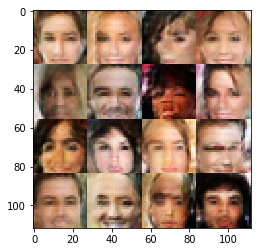

Epoch 1/1...Batch 10210 Discriminator Loss: 1.2157... Generator Loss: 0.6787
Epoch 1/1...Batch 10220 Discriminator Loss: 1.4404... Generator Loss: 0.5118
Epoch 1/1...Batch 10230 Discriminator Loss: 1.3050... Generator Loss: 0.5549
Epoch 1/1...Batch 10240 Discriminator Loss: 1.0643... Generator Loss: 0.9864
Epoch 1/1...Batch 10250 Discriminator Loss: 1.0709... Generator Loss: 0.9458
Epoch 1/1...Batch 10260 Discriminator Loss: 1.1197... Generator Loss: 1.0905
Epoch 1/1...Batch 10270 Discriminator Loss: 1.3268... Generator Loss: 0.5506
Epoch 1/1...Batch 10280 Discriminator Loss: 1.3510... Generator Loss: 0.6521
Epoch 1/1...Batch 10290 Discriminator Loss: 1.2454... Generator Loss: 0.6838
Epoch 1/1...Batch 10300 Discriminator Loss: 1.1796... Generator Loss: 0.7670


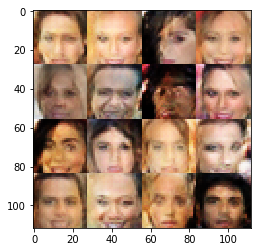

Epoch 1/1...Batch 10310 Discriminator Loss: 1.6417... Generator Loss: 0.3465
Epoch 1/1...Batch 10320 Discriminator Loss: 1.3909... Generator Loss: 0.4951
Epoch 1/1...Batch 10330 Discriminator Loss: 1.9190... Generator Loss: 0.2652
Epoch 1/1...Batch 10340 Discriminator Loss: 1.3233... Generator Loss: 0.5658
Epoch 1/1...Batch 10350 Discriminator Loss: 1.2084... Generator Loss: 0.7920
Epoch 1/1...Batch 10360 Discriminator Loss: 1.1747... Generator Loss: 0.7570
Epoch 1/1...Batch 10370 Discriminator Loss: 1.3726... Generator Loss: 0.5950
Epoch 1/1...Batch 10380 Discriminator Loss: 1.3409... Generator Loss: 0.5264
Epoch 1/1...Batch 10390 Discriminator Loss: 1.2586... Generator Loss: 0.8125
Epoch 1/1...Batch 10400 Discriminator Loss: 1.1999... Generator Loss: 0.7078


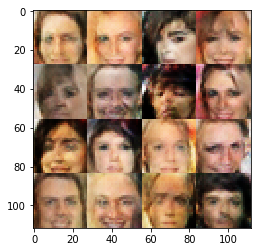

Epoch 1/1...Batch 10410 Discriminator Loss: 1.1451... Generator Loss: 0.7992
Epoch 1/1...Batch 10420 Discriminator Loss: 1.1151... Generator Loss: 0.8345
Epoch 1/1...Batch 10430 Discriminator Loss: 1.1973... Generator Loss: 0.8275
Epoch 1/1...Batch 10440 Discriminator Loss: 1.0275... Generator Loss: 0.8863
Epoch 1/1...Batch 10450 Discriminator Loss: 1.5479... Generator Loss: 0.6870
Epoch 1/1...Batch 10460 Discriminator Loss: 1.2417... Generator Loss: 0.7139
Epoch 1/1...Batch 10470 Discriminator Loss: 1.3303... Generator Loss: 0.6384
Epoch 1/1...Batch 10480 Discriminator Loss: 1.2527... Generator Loss: 1.0961
Epoch 1/1...Batch 10490 Discriminator Loss: 1.4026... Generator Loss: 0.5544
Epoch 1/1...Batch 10500 Discriminator Loss: 1.0366... Generator Loss: 0.9762


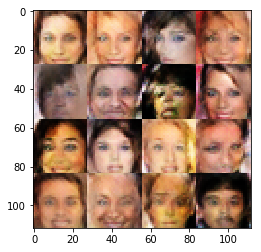

Epoch 1/1...Batch 10510 Discriminator Loss: 1.0329... Generator Loss: 0.9689
Epoch 1/1...Batch 10520 Discriminator Loss: 1.0361... Generator Loss: 1.0692
Epoch 1/1...Batch 10530 Discriminator Loss: 1.0641... Generator Loss: 0.7824
Epoch 1/1...Batch 10540 Discriminator Loss: 1.1881... Generator Loss: 0.7294
Epoch 1/1...Batch 10550 Discriminator Loss: 1.2943... Generator Loss: 0.5981
Epoch 1/1...Batch 10560 Discriminator Loss: 1.1253... Generator Loss: 0.8610
Epoch 1/1...Batch 10570 Discriminator Loss: 1.3007... Generator Loss: 0.6876
Epoch 1/1...Batch 10580 Discriminator Loss: 1.1729... Generator Loss: 0.7269
Epoch 1/1...Batch 10590 Discriminator Loss: 1.4142... Generator Loss: 0.4855
Epoch 1/1...Batch 10600 Discriminator Loss: 1.3344... Generator Loss: 0.5665


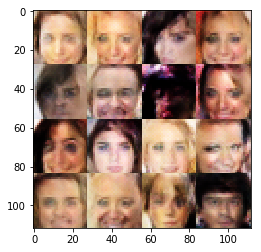

Epoch 1/1...Batch 10610 Discriminator Loss: 0.9885... Generator Loss: 1.1965
Epoch 1/1...Batch 10620 Discriminator Loss: 1.0864... Generator Loss: 1.0573
Epoch 1/1...Batch 10630 Discriminator Loss: 1.2043... Generator Loss: 0.6891
Epoch 1/1...Batch 10640 Discriminator Loss: 1.0644... Generator Loss: 1.0278
Epoch 1/1...Batch 10650 Discriminator Loss: 1.3019... Generator Loss: 0.7502
Epoch 1/1...Batch 10660 Discriminator Loss: 1.3136... Generator Loss: 0.5435
Epoch 1/1...Batch 10670 Discriminator Loss: 1.2497... Generator Loss: 1.1172
Epoch 1/1...Batch 10680 Discriminator Loss: 0.9462... Generator Loss: 1.1256
Epoch 1/1...Batch 10690 Discriminator Loss: 1.2986... Generator Loss: 0.5314
Epoch 1/1...Batch 10700 Discriminator Loss: 1.3774... Generator Loss: 0.6422


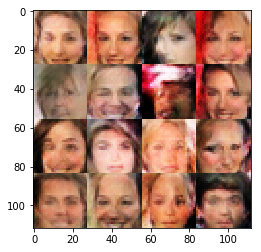

Epoch 1/1...Batch 10710 Discriminator Loss: 1.2941... Generator Loss: 0.6223
Epoch 1/1...Batch 10720 Discriminator Loss: 1.0740... Generator Loss: 0.9208
Epoch 1/1...Batch 10730 Discriminator Loss: 1.4756... Generator Loss: 0.4429
Epoch 1/1...Batch 10740 Discriminator Loss: 1.2397... Generator Loss: 0.7460
Epoch 1/1...Batch 10750 Discriminator Loss: 1.1320... Generator Loss: 0.9305
Epoch 1/1...Batch 10760 Discriminator Loss: 1.2433... Generator Loss: 0.6681
Epoch 1/1...Batch 10770 Discriminator Loss: 1.3824... Generator Loss: 0.8407
Epoch 1/1...Batch 10780 Discriminator Loss: 1.4586... Generator Loss: 0.4473
Epoch 1/1...Batch 10790 Discriminator Loss: 1.4165... Generator Loss: 0.4634
Epoch 1/1...Batch 10800 Discriminator Loss: 1.2287... Generator Loss: 0.6945


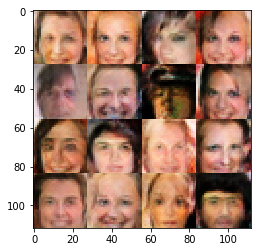

Epoch 1/1...Batch 10810 Discriminator Loss: 1.3945... Generator Loss: 0.4650
Epoch 1/1...Batch 10820 Discriminator Loss: 1.1550... Generator Loss: 0.7113
Epoch 1/1...Batch 10830 Discriminator Loss: 1.1100... Generator Loss: 0.8472
Epoch 1/1...Batch 10840 Discriminator Loss: 1.0629... Generator Loss: 1.1139
Epoch 1/1...Batch 10850 Discriminator Loss: 1.1681... Generator Loss: 1.0485
Epoch 1/1...Batch 10860 Discriminator Loss: 1.2227... Generator Loss: 0.6542
Epoch 1/1...Batch 10870 Discriminator Loss: 1.4748... Generator Loss: 0.4461
Epoch 1/1...Batch 10880 Discriminator Loss: 1.1784... Generator Loss: 0.6627
Epoch 1/1...Batch 10890 Discriminator Loss: 1.1089... Generator Loss: 0.9011
Epoch 1/1...Batch 10900 Discriminator Loss: 1.4293... Generator Loss: 0.5452


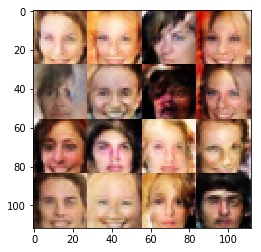

Epoch 1/1...Batch 10910 Discriminator Loss: 1.5071... Generator Loss: 0.4948
Epoch 1/1...Batch 10920 Discriminator Loss: 1.6385... Generator Loss: 0.5343
Epoch 1/1...Batch 10930 Discriminator Loss: 1.1811... Generator Loss: 0.7774
Epoch 1/1...Batch 10940 Discriminator Loss: 1.0974... Generator Loss: 0.7955
Epoch 1/1...Batch 10950 Discriminator Loss: 1.2286... Generator Loss: 0.6623
Epoch 1/1...Batch 10960 Discriminator Loss: 1.2085... Generator Loss: 0.7230
Epoch 1/1...Batch 10970 Discriminator Loss: 1.1665... Generator Loss: 0.6648
Epoch 1/1...Batch 10980 Discriminator Loss: 1.3760... Generator Loss: 0.8467
Epoch 1/1...Batch 10990 Discriminator Loss: 1.7868... Generator Loss: 0.2831
Epoch 1/1...Batch 11000 Discriminator Loss: 1.0990... Generator Loss: 0.9409


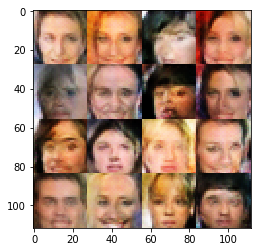

Epoch 1/1...Batch 11010 Discriminator Loss: 1.2912... Generator Loss: 0.6630
Epoch 1/1...Batch 11020 Discriminator Loss: 1.2702... Generator Loss: 0.7505
Epoch 1/1...Batch 11030 Discriminator Loss: 1.4739... Generator Loss: 0.4508
Epoch 1/1...Batch 11040 Discriminator Loss: 1.0782... Generator Loss: 0.9199
Epoch 1/1...Batch 11050 Discriminator Loss: 0.8918... Generator Loss: 1.2259
Epoch 1/1...Batch 11060 Discriminator Loss: 1.1402... Generator Loss: 0.8430
Epoch 1/1...Batch 11070 Discriminator Loss: 1.2927... Generator Loss: 0.5710
Epoch 1/1...Batch 11080 Discriminator Loss: 1.2900... Generator Loss: 0.8279
Epoch 1/1...Batch 11090 Discriminator Loss: 1.2878... Generator Loss: 0.7580
Epoch 1/1...Batch 11100 Discriminator Loss: 1.3831... Generator Loss: 0.5777


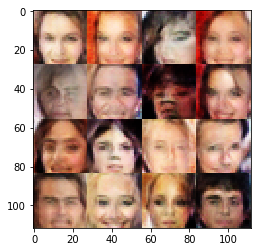

Epoch 1/1...Batch 11110 Discriminator Loss: 1.4794... Generator Loss: 0.4428
Epoch 1/1...Batch 11120 Discriminator Loss: 1.6522... Generator Loss: 0.4408
Epoch 1/1...Batch 11130 Discriminator Loss: 0.9646... Generator Loss: 1.1949
Epoch 1/1...Batch 11140 Discriminator Loss: 1.1346... Generator Loss: 0.8575
Epoch 1/1...Batch 11150 Discriminator Loss: 1.3642... Generator Loss: 0.5770
Epoch 1/1...Batch 11160 Discriminator Loss: 1.2714... Generator Loss: 0.6375
Epoch 1/1...Batch 11170 Discriminator Loss: 1.2969... Generator Loss: 1.0979
Epoch 1/1...Batch 11180 Discriminator Loss: 1.5315... Generator Loss: 0.3952
Epoch 1/1...Batch 11190 Discriminator Loss: 1.1939... Generator Loss: 0.6740
Epoch 1/1...Batch 11200 Discriminator Loss: 1.1489... Generator Loss: 1.0842


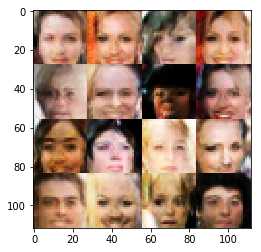

Epoch 1/1...Batch 11210 Discriminator Loss: 1.3363... Generator Loss: 0.5800
Epoch 1/1...Batch 11220 Discriminator Loss: 1.5046... Generator Loss: 0.4457
Epoch 1/1...Batch 11230 Discriminator Loss: 1.2287... Generator Loss: 0.6814
Epoch 1/1...Batch 11240 Discriminator Loss: 1.6890... Generator Loss: 0.3169
Epoch 1/1...Batch 11250 Discriminator Loss: 1.0298... Generator Loss: 0.8827
Epoch 1/1...Batch 11260 Discriminator Loss: 0.8912... Generator Loss: 1.1310
Epoch 1/1...Batch 11270 Discriminator Loss: 1.1586... Generator Loss: 0.7524
Epoch 1/1...Batch 11280 Discriminator Loss: 1.2579... Generator Loss: 0.5870
Epoch 1/1...Batch 11290 Discriminator Loss: 1.2986... Generator Loss: 0.6002
Epoch 1/1...Batch 11300 Discriminator Loss: 1.0639... Generator Loss: 0.8817


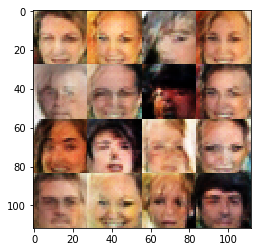

Epoch 1/1...Batch 11310 Discriminator Loss: 1.4813... Generator Loss: 0.4186
Epoch 1/1...Batch 11320 Discriminator Loss: 1.1354... Generator Loss: 0.7884
Epoch 1/1...Batch 11330 Discriminator Loss: 1.0860... Generator Loss: 0.8484
Epoch 1/1...Batch 11340 Discriminator Loss: 1.1824... Generator Loss: 0.8679
Epoch 1/1...Batch 11350 Discriminator Loss: 1.0935... Generator Loss: 0.9062
Epoch 1/1...Batch 11360 Discriminator Loss: 1.5838... Generator Loss: 0.3863
Epoch 1/1...Batch 11370 Discriminator Loss: 1.1029... Generator Loss: 0.8983
Epoch 1/1...Batch 11380 Discriminator Loss: 0.9622... Generator Loss: 1.3121
Epoch 1/1...Batch 11390 Discriminator Loss: 1.2054... Generator Loss: 0.7729
Epoch 1/1...Batch 11400 Discriminator Loss: 1.3649... Generator Loss: 0.7789


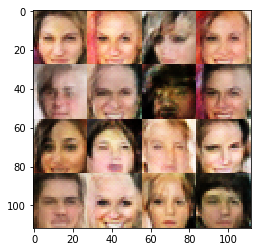

Epoch 1/1...Batch 11410 Discriminator Loss: 1.1406... Generator Loss: 1.1251
Epoch 1/1...Batch 11420 Discriminator Loss: 1.2778... Generator Loss: 0.7369
Epoch 1/1...Batch 11430 Discriminator Loss: 1.4576... Generator Loss: 0.4848
Epoch 1/1...Batch 11440 Discriminator Loss: 0.9759... Generator Loss: 0.9079
Epoch 1/1...Batch 11450 Discriminator Loss: 1.6186... Generator Loss: 0.3554
Epoch 1/1...Batch 11460 Discriminator Loss: 1.1887... Generator Loss: 0.7190
Epoch 1/1...Batch 11470 Discriminator Loss: 1.0146... Generator Loss: 0.9810
Epoch 1/1...Batch 11480 Discriminator Loss: 1.2093... Generator Loss: 0.9809
Epoch 1/1...Batch 11490 Discriminator Loss: 1.4871... Generator Loss: 0.4578
Epoch 1/1...Batch 11500 Discriminator Loss: 1.3204... Generator Loss: 0.5783


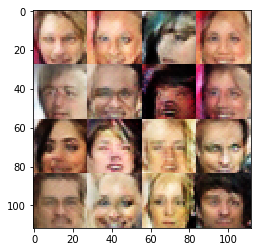

Epoch 1/1...Batch 11510 Discriminator Loss: 1.2226... Generator Loss: 0.7677
Epoch 1/1...Batch 11520 Discriminator Loss: 1.1748... Generator Loss: 0.7210
Epoch 1/1...Batch 11530 Discriminator Loss: 1.5887... Generator Loss: 0.3788
Epoch 1/1...Batch 11540 Discriminator Loss: 0.9659... Generator Loss: 1.0192
Epoch 1/1...Batch 11550 Discriminator Loss: 1.3484... Generator Loss: 0.5540
Epoch 1/1...Batch 11560 Discriminator Loss: 1.3021... Generator Loss: 0.6042
Epoch 1/1...Batch 11570 Discriminator Loss: 1.2115... Generator Loss: 0.6088
Epoch 1/1...Batch 11580 Discriminator Loss: 0.9013... Generator Loss: 1.3068
Epoch 1/1...Batch 11590 Discriminator Loss: 1.3730... Generator Loss: 0.6045
Epoch 1/1...Batch 11600 Discriminator Loss: 1.4086... Generator Loss: 0.9720


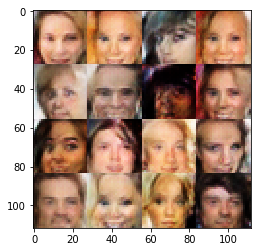

Epoch 1/1...Batch 11610 Discriminator Loss: 1.2281... Generator Loss: 0.6300
Epoch 1/1...Batch 11620 Discriminator Loss: 1.3165... Generator Loss: 0.6294
Epoch 1/1...Batch 11630 Discriminator Loss: 1.1395... Generator Loss: 0.7591
Epoch 1/1...Batch 11640 Discriminator Loss: 1.3672... Generator Loss: 0.6255
Epoch 1/1...Batch 11650 Discriminator Loss: 1.3830... Generator Loss: 0.5122
Epoch 1/1...Batch 11660 Discriminator Loss: 1.1968... Generator Loss: 0.7858
Epoch 1/1...Batch 11670 Discriminator Loss: 1.4450... Generator Loss: 0.5544
Epoch 1/1...Batch 11680 Discriminator Loss: 1.1030... Generator Loss: 0.9874
Epoch 1/1...Batch 11690 Discriminator Loss: 1.5599... Generator Loss: 0.3965
Epoch 1/1...Batch 11700 Discriminator Loss: 1.3377... Generator Loss: 1.0128


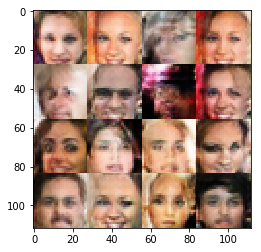

Epoch 1/1...Batch 11710 Discriminator Loss: 1.3378... Generator Loss: 0.5689
Epoch 1/1...Batch 11720 Discriminator Loss: 1.1581... Generator Loss: 0.7345
Epoch 1/1...Batch 11730 Discriminator Loss: 1.0971... Generator Loss: 0.8567
Epoch 1/1...Batch 11740 Discriminator Loss: 1.3455... Generator Loss: 0.5373
Epoch 1/1...Batch 11750 Discriminator Loss: 1.2482... Generator Loss: 0.5904
Epoch 1/1...Batch 11760 Discriminator Loss: 1.4565... Generator Loss: 0.5792
Epoch 1/1...Batch 11770 Discriminator Loss: 1.2096... Generator Loss: 0.8217
Epoch 1/1...Batch 11780 Discriminator Loss: 1.2679... Generator Loss: 0.5673
Epoch 1/1...Batch 11790 Discriminator Loss: 1.5177... Generator Loss: 0.4429
Epoch 1/1...Batch 11800 Discriminator Loss: 1.3460... Generator Loss: 0.6503


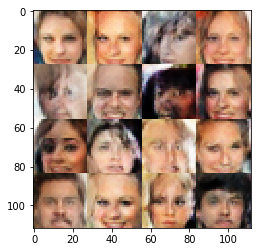

Epoch 1/1...Batch 11810 Discriminator Loss: 1.0180... Generator Loss: 0.8740
Epoch 1/1...Batch 11820 Discriminator Loss: 1.3332... Generator Loss: 0.6505
Epoch 1/1...Batch 11830 Discriminator Loss: 1.2357... Generator Loss: 0.7305
Epoch 1/1...Batch 11840 Discriminator Loss: 1.1897... Generator Loss: 0.8252
Epoch 1/1...Batch 11850 Discriminator Loss: 1.1217... Generator Loss: 0.8785
Epoch 1/1...Batch 11860 Discriminator Loss: 1.2547... Generator Loss: 0.7243
Epoch 1/1...Batch 11870 Discriminator Loss: 1.2415... Generator Loss: 0.6799
Epoch 1/1...Batch 11880 Discriminator Loss: 0.9259... Generator Loss: 1.1003
Epoch 1/1...Batch 11890 Discriminator Loss: 1.4242... Generator Loss: 1.2372
Epoch 1/1...Batch 11900 Discriminator Loss: 1.1119... Generator Loss: 0.8151


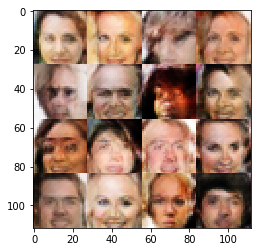

Epoch 1/1...Batch 11910 Discriminator Loss: 1.2079... Generator Loss: 0.7975
Epoch 1/1...Batch 11920 Discriminator Loss: 1.2021... Generator Loss: 0.6507
Epoch 1/1...Batch 11930 Discriminator Loss: 1.3473... Generator Loss: 0.6626
Epoch 1/1...Batch 11940 Discriminator Loss: 1.0192... Generator Loss: 1.2059
Epoch 1/1...Batch 11950 Discriminator Loss: 1.4549... Generator Loss: 0.5009
Epoch 1/1...Batch 11960 Discriminator Loss: 1.2714... Generator Loss: 0.8106
Epoch 1/1...Batch 11970 Discriminator Loss: 1.4526... Generator Loss: 0.4466
Epoch 1/1...Batch 11980 Discriminator Loss: 1.1169... Generator Loss: 0.7546
Epoch 1/1...Batch 11990 Discriminator Loss: 1.0255... Generator Loss: 1.1406
Epoch 1/1...Batch 12000 Discriminator Loss: 1.2372... Generator Loss: 0.6275


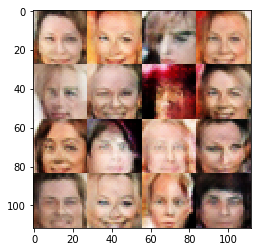

Epoch 1/1...Batch 12010 Discriminator Loss: 1.4834... Generator Loss: 0.4601
Epoch 1/1...Batch 12020 Discriminator Loss: 1.1899... Generator Loss: 1.1554
Epoch 1/1...Batch 12030 Discriminator Loss: 1.6589... Generator Loss: 0.3333
Epoch 1/1...Batch 12040 Discriminator Loss: 1.2561... Generator Loss: 0.6087
Epoch 1/1...Batch 12050 Discriminator Loss: 1.7786... Generator Loss: 0.3126
Epoch 1/1...Batch 12060 Discriminator Loss: 1.3179... Generator Loss: 0.7866
Epoch 1/1...Batch 12070 Discriminator Loss: 1.2830... Generator Loss: 0.7792
Epoch 1/1...Batch 12080 Discriminator Loss: 1.4060... Generator Loss: 0.6206
Epoch 1/1...Batch 12090 Discriminator Loss: 1.4105... Generator Loss: 0.4775
Epoch 1/1...Batch 12100 Discriminator Loss: 1.2489... Generator Loss: 0.7254


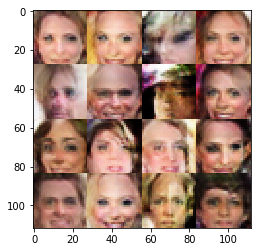

Epoch 1/1...Batch 12110 Discriminator Loss: 1.4291... Generator Loss: 0.5231
Epoch 1/1...Batch 12120 Discriminator Loss: 1.2903... Generator Loss: 0.7353
Epoch 1/1...Batch 12130 Discriminator Loss: 1.2401... Generator Loss: 0.6672
Epoch 1/1...Batch 12140 Discriminator Loss: 1.6473... Generator Loss: 0.3866
Epoch 1/1...Batch 12150 Discriminator Loss: 1.3524... Generator Loss: 0.5972
Epoch 1/1...Batch 12160 Discriminator Loss: 1.3765... Generator Loss: 0.5157
Epoch 1/1...Batch 12170 Discriminator Loss: 1.1783... Generator Loss: 0.8134
Epoch 1/1...Batch 12180 Discriminator Loss: 1.1487... Generator Loss: 0.8427
Epoch 1/1...Batch 12190 Discriminator Loss: 1.3113... Generator Loss: 0.5391
Epoch 1/1...Batch 12200 Discriminator Loss: 0.9917... Generator Loss: 0.8572


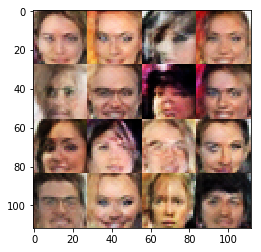

Epoch 1/1...Batch 12210 Discriminator Loss: 1.3858... Generator Loss: 0.7544
Epoch 1/1...Batch 12220 Discriminator Loss: 1.4562... Generator Loss: 0.4869
Epoch 1/1...Batch 12230 Discriminator Loss: 1.2126... Generator Loss: 0.8449
Epoch 1/1...Batch 12240 Discriminator Loss: 1.5065... Generator Loss: 0.4226
Epoch 1/1...Batch 12250 Discriminator Loss: 1.1202... Generator Loss: 0.7961
Epoch 1/1...Batch 12260 Discriminator Loss: 1.2192... Generator Loss: 0.7022
Epoch 1/1...Batch 12270 Discriminator Loss: 1.2679... Generator Loss: 0.6085
Epoch 1/1...Batch 12280 Discriminator Loss: 1.3172... Generator Loss: 0.5852
Epoch 1/1...Batch 12290 Discriminator Loss: 1.2614... Generator Loss: 0.8279
Epoch 1/1...Batch 12300 Discriminator Loss: 1.3285... Generator Loss: 0.6659


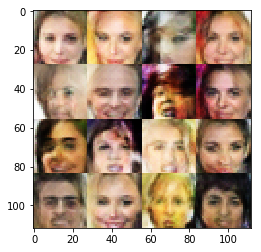

Epoch 1/1...Batch 12310 Discriminator Loss: 1.2294... Generator Loss: 0.6235
Epoch 1/1...Batch 12320 Discriminator Loss: 1.6588... Generator Loss: 0.4807
Epoch 1/1...Batch 12330 Discriminator Loss: 1.1821... Generator Loss: 0.7238
Epoch 1/1...Batch 12340 Discriminator Loss: 1.2624... Generator Loss: 0.6056
Epoch 1/1...Batch 12350 Discriminator Loss: 1.4723... Generator Loss: 0.4333
Epoch 1/1...Batch 12360 Discriminator Loss: 1.0826... Generator Loss: 0.7640
Epoch 1/1...Batch 12370 Discriminator Loss: 1.4113... Generator Loss: 0.5156
Epoch 1/1...Batch 12380 Discriminator Loss: 1.0889... Generator Loss: 1.2770
Epoch 1/1...Batch 12390 Discriminator Loss: 1.2488... Generator Loss: 0.7399
Epoch 1/1...Batch 12400 Discriminator Loss: 1.1158... Generator Loss: 0.8754


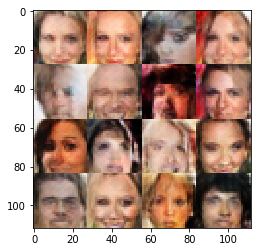

Epoch 1/1...Batch 12410 Discriminator Loss: 1.1718... Generator Loss: 0.7399
Epoch 1/1...Batch 12420 Discriminator Loss: 1.0738... Generator Loss: 0.9450
Epoch 1/1...Batch 12430 Discriminator Loss: 1.2934... Generator Loss: 0.6769
Epoch 1/1...Batch 12440 Discriminator Loss: 1.0828... Generator Loss: 0.9884
Epoch 1/1...Batch 12450 Discriminator Loss: 1.0932... Generator Loss: 0.7139
Epoch 1/1...Batch 12460 Discriminator Loss: 1.3460... Generator Loss: 0.6382
Epoch 1/1...Batch 12470 Discriminator Loss: 1.2953... Generator Loss: 0.6484
Epoch 1/1...Batch 12480 Discriminator Loss: 0.8892... Generator Loss: 1.2344
Epoch 1/1...Batch 12490 Discriminator Loss: 1.4768... Generator Loss: 0.4290
Epoch 1/1...Batch 12500 Discriminator Loss: 1.9483... Generator Loss: 0.2808


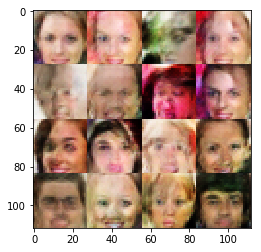

Epoch 1/1...Batch 12510 Discriminator Loss: 1.6195... Generator Loss: 0.3615
Epoch 1/1...Batch 12520 Discriminator Loss: 1.5095... Generator Loss: 0.4455
Epoch 1/1...Batch 12530 Discriminator Loss: 1.0916... Generator Loss: 0.8705
Epoch 1/1...Batch 12540 Discriminator Loss: 1.4543... Generator Loss: 0.4620
Epoch 1/1...Batch 12550 Discriminator Loss: 1.2462... Generator Loss: 0.6599
Epoch 1/1...Batch 12560 Discriminator Loss: 1.4227... Generator Loss: 0.5719
Epoch 1/1...Batch 12570 Discriminator Loss: 0.9684... Generator Loss: 1.0904
Epoch 1/1...Batch 12580 Discriminator Loss: 1.4396... Generator Loss: 0.4923
Epoch 1/1...Batch 12590 Discriminator Loss: 0.9058... Generator Loss: 1.4065
Epoch 1/1...Batch 12600 Discriminator Loss: 1.4600... Generator Loss: 0.4340


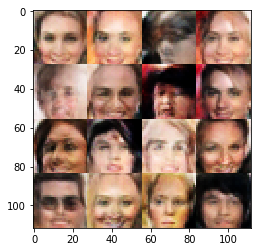

Epoch 1/1...Batch 12610 Discriminator Loss: 0.9621... Generator Loss: 1.2627
Epoch 1/1...Batch 12620 Discriminator Loss: 1.2449... Generator Loss: 0.6974
Epoch 1/1...Batch 12630 Discriminator Loss: 1.0338... Generator Loss: 1.0991
Epoch 1/1...Batch 12640 Discriminator Loss: 1.2759... Generator Loss: 0.7459
Epoch 1/1...Batch 12650 Discriminator Loss: 1.3676... Generator Loss: 0.5105
Epoch 1/1...Batch 12660 Discriminator Loss: 1.3693... Generator Loss: 0.5296
Generating new sample noise


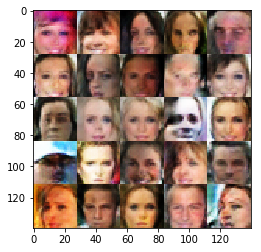

In [39]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.